Pour ce projet, nous avons suivi le schéma présenté dans cet article:
https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420

# Introduction: Home Credit Default Risk Competition
-----------------

## Data

Les données sont fournies par [Home Credit] (http://www.homecredit.net/about-us.aspx), un service dédié à la fourniture de lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera ou non un prêt ou s'il rencontrera des difficultés est un besoin commercial essentiel, et Home Credit organise ce concours sur Kaggle pour voir quel type de modèles la communauté de l'apprentissage automatique peut développer pour l'aider dans cette tâche. 

Il existe 7 sources de données différentes :


* **application_train/application_test**: the main training and testing data avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. Les données du train sont accompagnées de la  `TARGET` qui indique 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé. 
* **bureau**: les données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.
* **bureau_balance**: données mensuelles sur les crédits antérieurs dans le bureau. Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit. 
* **previous_application**: les demandes de crédit antérieures auprès de Home Credit. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs. Chaque demande antérieure a une ligne et est identifiée par la caractéristique `SK_ID_PREV`. 
* **POS_CASH_BALANCE**: des données mensuelles sur les prêts au point de vente ou au comptant que les clients ont contractés auprès de Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt au comptant antérieur, et un seul prêt antérieur peut avoir plusieurs lignes.
* **credit_card_balance**: des données mensuelles sur les cartes de crédit que les clients ont eues précédemment avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
* **installments_payment** l'historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué. 



Voir schéma tables pour assemblage : "C:\Users\belou\Projet 7\input\schéma_tables.png"
Voir dico variables : "C:\Users\belou\Projet 7\input\dico_variables.xlsx"

## Metric: ROC AUC

La mesure de classification courante utilisée c'est la COURBE ROC :

https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it
https://en.wikipedia.org/wiki/Receiver_operating_characteristic
https://darwin.unmc.edu/dxtests/roc3.htm


Lorsqu'on mesure une classification en fonction de l'AUC, on ne génère pas des prédictions 0 ou 1, mais plutôt une probabilité entre 0 et 1. Cela peut être déroutant car nous aimons généralement penser en termes de précision, mais lorsque nous rencontrons des problèmes avec des classes déséquilibrées (nous verrons que c'est le cas), la précision n'est pas la meilleure métrique. Par exemple, si je voulais construire un modèle capable de détecter les terroristes avec une précision de 99,9999 %, je me contenterais de créer un modèle prédisant que chaque personne n'est pas un terroriste. Il est clair que cela ne serait pas efficace (le rappel serait nul) et nous utilisons des mesures plus avancées telles que la SSC ROC ou le score F1 pour refléter plus précisément les performances d'un classificateur. 

https://en.wikipedia.org/wiki/F-score

Un modèle ayant un ROC AUC élevé aura également une grande précision, mais l'AUC est une meilleure représentation de la performance du modèle.

https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy


# 1 - Exploration des datasets Train et Test
--------------

Dans ce NB, nous nous en tiendrons à utiliser uniquement les données d'entraînement et de test de l'application principale. Bien que nous devions utiliser toutes les données si nous voulions avoir un espoir de rivaliser sérieusement, nous nous en tiendrons pour l'instant à un seul fichier, ce qui devrait être plus facile à gérer. Cela nous permettra d'établir une base de référence que nous pourrons ensuite améliorer. Dans ce genre de projet, il est préférable de comprendre le problème petit à petit plutôt que de s'y plonger complètement et de s'y perdre ! 

## 1.1 - Imports


In [1]:
import mlflow
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from mlflow.models import infer_signature

import shap
# Memory management
import gc 

## 1.2 - Read in Data 

In [2]:
# List files available
print(os.listdir("../input/"))

['.ipynb_checkpoints', '1 - start-here-a-gentle-introduction.ipynb', '10- idem 9 with FI.ipynb', '11-idem 10 with FE.ipynb', '12-idem 11 with F._Selection.ipynb', '13-idem 12 with tunng LGBM.ipynb', '14 - idem 13 with interpretation.ipynb', '2 - with set de validation et création de métrique.ipynb', '3 - train_test__features_metier.ipynb', '4 - train_test__features_metier.ipynb', '5 - idem_4 sans cv.ipynb', '6 - idem 5 mais avec fonction.ipynb', '7 - idem 6 avec RF.ipynb', '8 - idem 7 avec smote.ipynb', '9 - final_before FE_and_FI.ipynb', 'application_test.csv', 'application_train.csv', 'app_train_domain.csv', 'baseline_lgb.csv', 'baseline_lgb_domain_features.csv', 'bureau.csv', 'bureaux.csv', 'bureau_balance.csv', 'bureau_balances.csv', 'columns_description.ipynb', 'credit_card_balance.csv', 'credit_card_balances.csv', 'cxl_12-idem 10 with automatic FE.ipynb', 'dico_train_test.csv', 'dico_variables.xlsx', 'Démo-CBS.ipynb', 'HomeCredit_columns_description.csv', 'installments_payment.cs

In [3]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

Le train comporte 307511 observations (chacune étant un prêt distinct) et 122 variables, y compris la target

In [4]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

Le test comporte bcp moins d'observations (48744) et ne comporte pas de  TARGET. Nous n'en tiendrons pas compte dans un 1er temps

## 1.3 - Exploratory Data Analysis

### 1.3.1 -  Distribution de la target

In [5]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [6]:
app_train['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

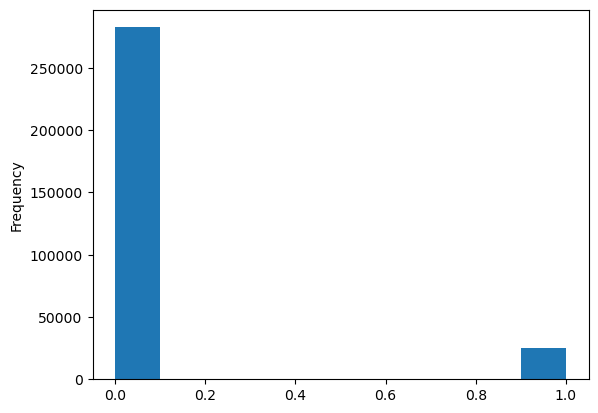

In [7]:
app_train['TARGET'].plot.hist();

Ces informations montrent qu'il s'agit d'un problème de classe déséquilibrée :  http://www.chioka.in/class-imbalance-problem/. 

Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Lorsque nous utiliserons des modèles d'apprentissage automatique plus sophistiqués, nous pourrons pondérer les classes : http://xgboost.readthedocs.io/en/latest/parameter.html en fonction de leur représentation dans les données afin de refléter ce déséquilibre :

- scale_pos_weight : C'est l'un des hyperparamètres les plus importants pour les ensembles de données déséquilibrés dans les problèmes de classification binaire. Ce paramètre donne plus de poids à la classe minoritaire pendant l'entraînement, aidant le modèle à accorder une attention appropriée à cette classe.
- max_delta_step : Cet hyperparamètre aide à rendre la mise à jour du gradient plus conservatrice, souvent utile dans les ensembles de données très déséquilibrés. Il est généralement utilisé en conjonction avec scale_pos_weight pour améliorer la performance du modèle.

Paramètres relatifs à l'échantillonnage :

- subsample : Le pourcentage d'échantillons utilisés pour chaque arbre. Réduire cette valeur peut aider à éviter le surajustement.
- colsample_bytree, colsample_bylevel, colsample_bynode : Ces paramètres contrôlent le sous-échantillonnage des caractéristiques à différents niveaux de la construction des arbres. Ils peuvent être utiles pour gérer les surajustements.

En général, ajuster scale_pos_weight est un bon point de départ pour traiter des ensembles de données déséquilibrés. Il est également recommandé de faire une validation croisée pour déterminer les valeurs optimales de ces hyperparamètres pour votre ensemble de données spécifique.

### 1.3.2 - Missing Values

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

Lorsqu'il s'agira de construire nos modèles d'apprentissage automatique, nous devrons imputer ces valeurs manquantes. Dans un travail ultérieur, nous utiliserons des modèles tels que XGBoost qui peuvent traiter les valeurs manquantes sans nécessiter d'imputation : https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase.
Une autre option consisterait à supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. 
Par conséquent, nous conserverons toutes les colonnes pour l'instant.

### 1.3.3 - Column Types

In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [11]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques.

### 1.3.4 - Anomalies

Les anomalies dans les données sont un problème que nous devons toujours surveiller lorsque nous faisons de l'AED. Celles-ci peuvent être dues à des chiffres mal saisis, à des erreurs dans les mesures ou à des mesures valables mais extrêmes. L'une des façons de détecter les anomalies de manière quantitative est d'examiner les statistiques d'une colonne à l'aide de la méthode `describe`. 

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
app_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

Les chiffres de la colonne `DAYS_BIRTH` sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année :

In [14]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure. Qu'en est-il des jours d'emploi ? 

In [15]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans !

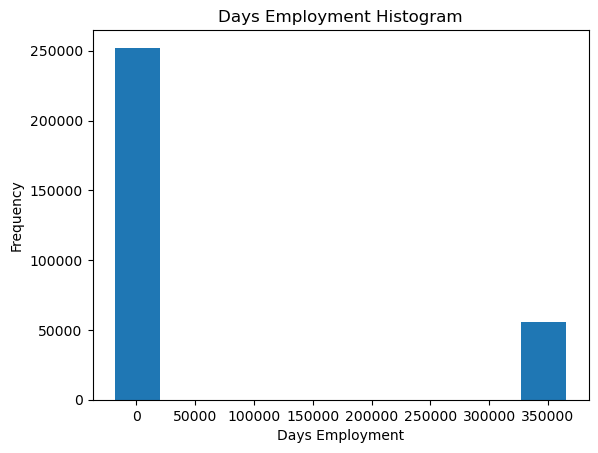

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Par simple curiosité, nous allons regrouper les clients présentant des anomalies et voir s'ils ont tendance à avoir des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [17]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Il s'avère que les anomalies ont un taux de défaillance plus faible. 

Le traitement des anomalies dépend de la situation exacte et il n'existe pas de règles fixes. L'une des approches les plus sûres consiste à définir les anomalies comme des valeurs manquantes et à les compléter (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, comme toutes les anomalies ont exactement la même valeur, nous voulons les compléter avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Comme solution, nous allons remplir les valeurs anormales avec un nombre (`np.nan`) et ensuite créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.



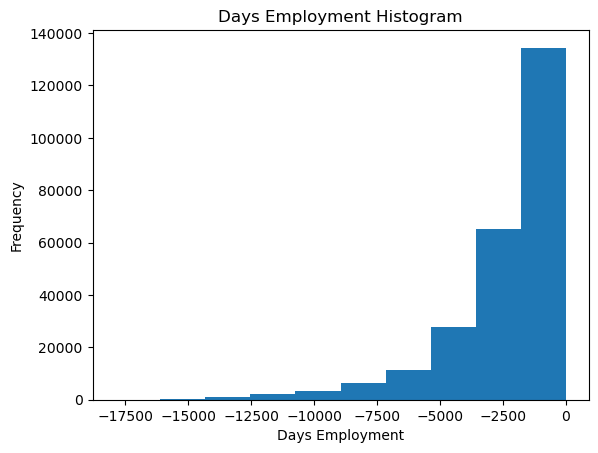

In [18]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

La distribution semble beaucoup plus conforme à ce que nous attendons, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (parce que nous devrons remplir les nans avec une valeur, probablement la médiane de la colonne). Les autres colonnes avec `DAYS` dans le cadre de données semblent être à peu près ce que nous attendons, sans valeurs aberrantes évidentes. 

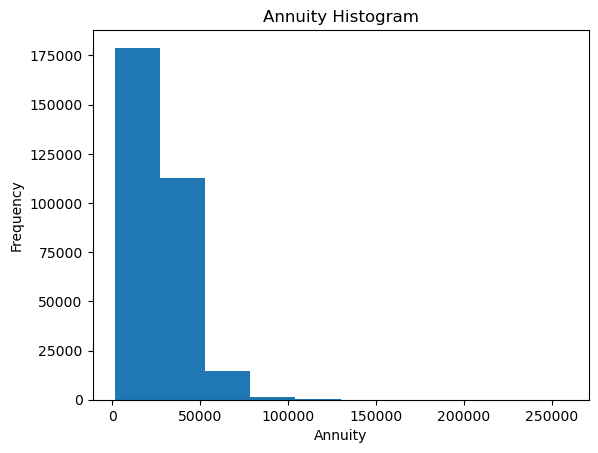

In [19]:
app_train['AMT_ANNUITY'].plot.hist(title = 'Annuity Histogram');
plt.xlabel('Annuity');

### 1.3.5 - Correlations

Une façon d'essayer de comprendre les données est de rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible à l'aide de la méthode .corr dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la « pertinence » d'une caractéristique, mais il nous donne une idée des relations possibles entre les données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [20]:
numeric_columns=app_train.select_dtypes(include=np.number).columns.tolist()
numeric_columns

# Matrice de corrélation
correlations = app_train[numeric_columns].corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227


La corrélation `DAYS_BIRTH` est la plus positive. En regardant la documentation, `DAYS_BIRTH` est l'âge en jours du client au moment du prêt en jours négatifs (pour une raison quelconque !). La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique et la corrélation sera négative.

#### 1.3.5.1 - Effect of Age on Repayment

In [21]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

Plus le client est âgé, plus il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps. 

Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. L'axe des x sera exprimé en années pour rendre le graphique un peu plus compréhensible.

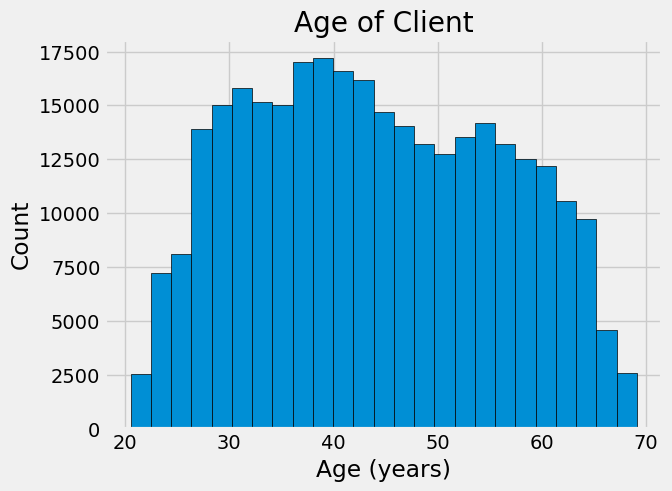

In [22]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables.
Pour visualiser l'effet de l'âge sur la cible, nous ferons ensuite un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la cible. Un graphique d'estimation de la densité du noyau montre la distribution d'une seule variable et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement une gaussienne, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le `kdeplot` de seaborn pour ce graphique.

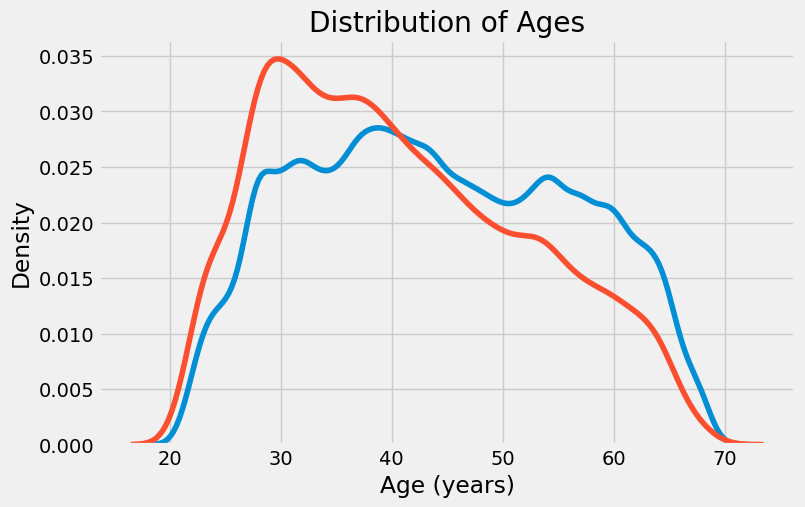

In [23]:
plt.figure(figsize = (8, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

La courbe de la Target == 1 penche vers l'extrémité la plus jeune de la fourchette. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge. 

Pour créer ce graphique, nous commençons par « découper » la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [24]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [25]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

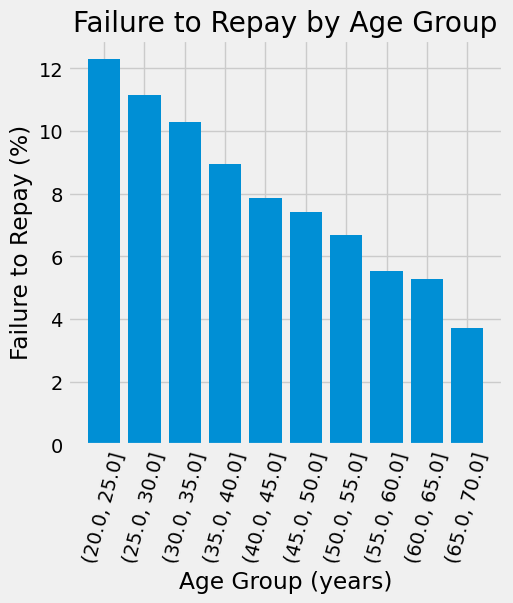

In [26]:
plt.figure(figsize = (5, 5))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe le plus âgé.

Il s'agit d'une information qui pourrait être directement utilisée par la banque : étant donné que les jeunes clients sont moins susceptibles de rembourser le prêt, il conviendrait peut-être de leur fournir davantage de conseils ou d'astuces en matière de planification financière. Cela ne signifie pas que la banque doive discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour les aider à rembourser à temps.

#### 1.3.5.2 - Exterior Sources

Les 3 variables ayant les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`.
Selon la documentation, ces caractéristiques représentent un « score normalisé de la source de données externe ». Je ne suis pas sûr de ce que cela signifie exactement, mais il pourrait s'agir d'une sorte d'évaluation de crédit cumulative réalisée à partir de nombreuses sources de données. 

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques `EXT_SOURCE` avec la cible et entre elles.

In [27]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

In [28]:
# plt.figure(figsize = (8, 6))

# # Heatmap of correlations
# sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
# plt.title('Correlation Heatmap');

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également constater que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'âge du client est peut-être l'un des facteurs de ce score.

Nous pouvons ensuite examiner la distribution de chacune de ces caractéristiques en fonction de la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

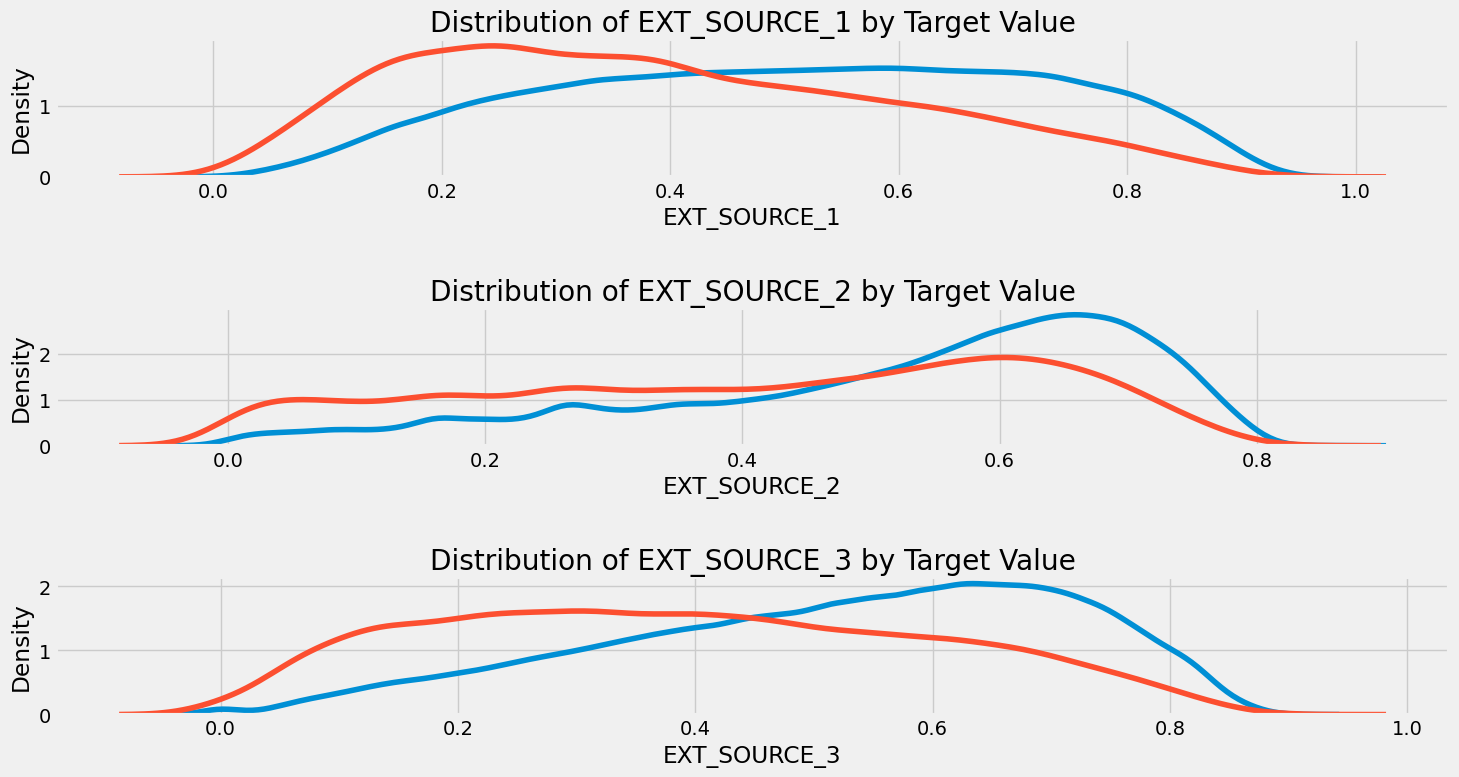

In [29]:
plt.figure(figsize = (15, 8))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles, mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique permettant de prédire si un demandeur remboursera ou non un prêt dans les délais.

### 1.3.6 - Pairs Plot

En guise de dernier graphique exploratoire, nous pouvons faire un pairplot des variables `EXT_SOURCE` et de la variable `DAYS_BIRTH`. Le Pairplot (https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) est un excellent outil d'exploration car il nous permet de voir les relations entre plusieurs paires de variables ainsi que les distributions de variables uniques. 

In [30]:
# # Copy the data for plotting
# plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# # Add in the age of the client in years
# plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# # Drop na values and limit to first 100000 rows
# plot_data = plot_data.dropna().loc[:100000, :]

# # Function to calculate correlation coefficient between two columns
# def corr_func(x, y, **kwargs):
#     r = np.corrcoef(x, y)[0][1]
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r),
#                 xy=(.2, .8), xycoords=ax.transAxes,
#                 size = 20)

# # Create the pairgrid object
# grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
#                     hue = 'TARGET', 
#                     vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# # Upper is a scatter plot
# grid.map_upper(plt.scatter, alpha = 0.2)

# # Diagonal is a histogram
# grid.map_diag(sns.kdeplot)

# # Bottom is density plot
# grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

# plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

Dans ce graphique, le rouge indique les prêts non remboursés et le bleu les prêts remboursés. Nous pouvons voir les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre EXT_SOURCE_1 et DAYS_BIRTH (ou YEARS_BIRTH), ce qui indique que cette caractéristique peut prendre en compte l'âge du client.

## 1.4 - Feature Engineering

Le Feature Engineering a un meilleur retour sur investissement que la construction de modèles et l'ajustement des hyperparamètres. 

Feature Engineering se réfère à un processus général et peut impliquer à la fois la construction de caractéristiques : l'ajout de nouvelles caractéristiques à partir des données existantes, et la sélection de caractéristiques : le choix des caractéristiques les plus importantes ou d'autres méthodes de réduction de la dimensionnalité. Il existe de nombreuses techniques permettant de créer et de sélectionner des caractéristiques.


Nous pouvons créer quelques caractéristiques qui tentent de capturer ce que nous pensons être important pour savoir si un client va manquer à ses obligations de remboursement d'un prêt. Ici, je vais utiliser cinq caractéristiques qui ont été inspirées par ce script (https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) d'Aguiar :

* `CREDIT_INCOME_PERCENT` : le pourcentage du montant du crédit par rapport au revenu du client.
* `ANNUITY_INCOME_PERCENT` : le pourcentage de l'annuité du prêt par rapport au revenu du client
* `CREDIT_TERM` : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû).
* `DAYS_EMPLOYED_PERCENT` : le pourcentage des jours de travail par rapport à l'âge du client.


In [31]:
app_train_domain = app_train.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

Nous devrions explorer ces variables de __connaissance du domaine__ visuellement dans un graphique. Pour toutes ces variables, nous ferons le même graphique KDE coloré par la valeur de la `TARGET`.

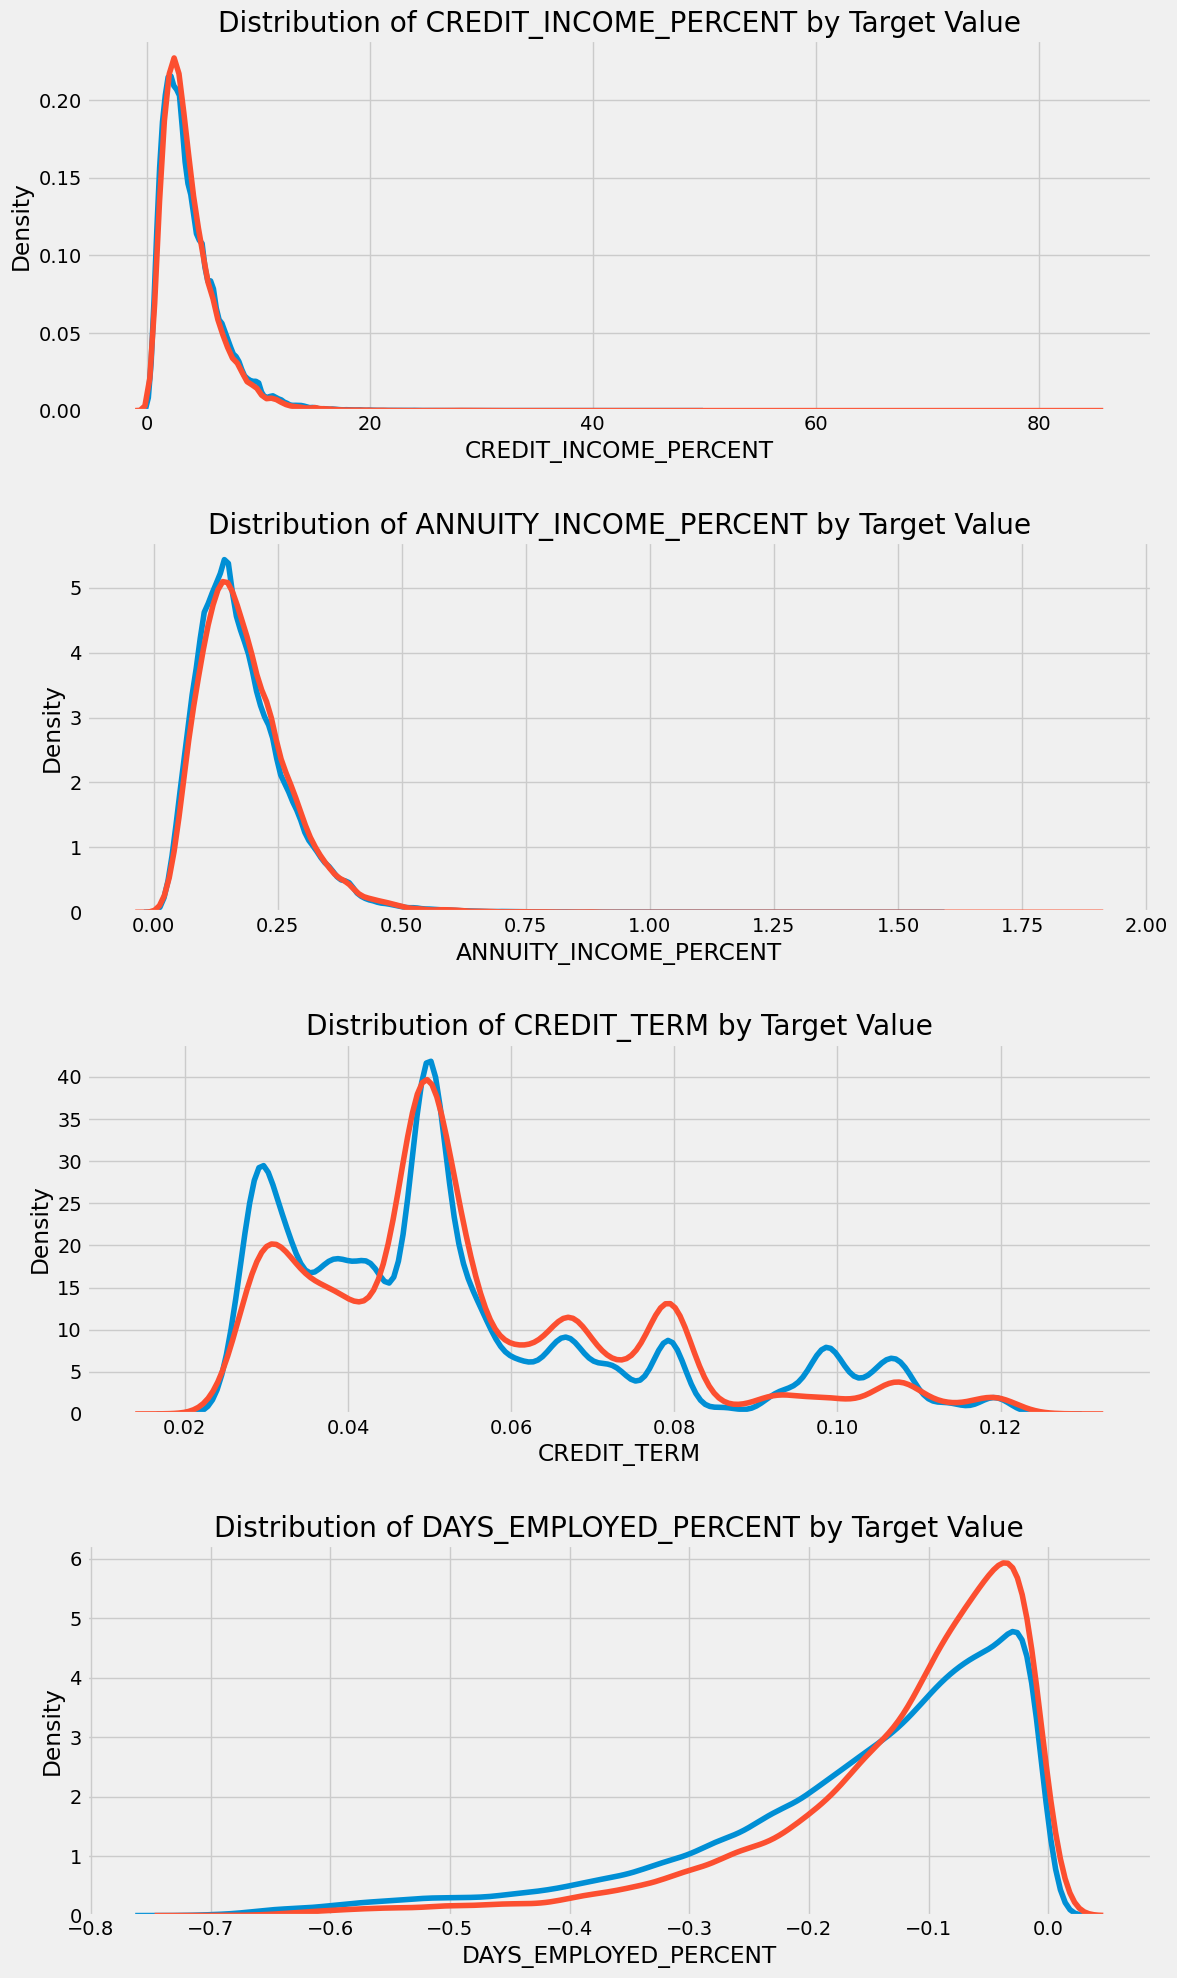

In [32]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Il est difficile de dire à l'avance si ces nouvelles fonctionnalités seront utiles. Le seul moyen d'en être sûr est de les essayer ! 

In [33]:
app_train_domain.to_csv('app_train_domain.csv', index=False)

# 2 - Modélisation

In [34]:
# démarrage du tracking
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

### 2.1 - Split train en train/test

Je garde une copie du df intact avec les id clients et la target

In [35]:
app_train_origin=app_train_domain.copy()

In [36]:
ID = app_train_domain['SK_ID_CURR'] 
X = app_train_domain.drop(['SK_ID_CURR','TARGET'], axis=1)  
y = app_train_domain['TARGET']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 2.2 - Encoding Variables catégorielles

Un modèle d'apprentissage automatique ne peut pas traiter les variables catégorielles (à l'exception de certains modèles tels que LightGBM : http://lightgbm.readthedocs.io/en/latest/Features.html. 

Nous devons donc trouver un moyen d'encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle. Il y a deux façons principales d'effectuer ce processus :
- Label encoding: attribue un nombre entier à chaque catégorie unique d'une variable catégorielle.
- One-hot encoding: créé une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne de la catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

Le problème du Label encoding est qu'il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire et ne reflète aucun aspect inhérent à la catégorie. Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le scientifique des données un 1, mais si nous refaisions le même processus, les étiquettes pourraient être inversées ou complètement différentes. L'affectation réelle des nombres entiers est arbitraire. Par conséquent, lorsque nous procédons à l'encodage des étiquettes, le modèle peut utiliser la valeur relative de la caractéristique (par exemple, programmeur = 4 et scientifique = 1) pour attribuer des poids, ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (telle que Homme/Femme), le Label Encoding convient, mais pour plus de deux catégories uniques, le One Hot Encoding est l'option la plus sûre.


Le seul inconvénient du One Hot Encoding est que le nombre de caractéristiques (dimensions des données) peut exploser avec des variables catégorielles comportant de nombreuses catégories. Pour y remédier, nous pouvons effectuer un OHE suivi d'une ACP ou d'autres méthodes de réduction de la dimensionnalité afin de réduire le nombre de dimensions tout en essayant de préserver l'information. 


Dans ce NB, nous utiliserons le Label Encoding pour toutes les variables catégorielles comportant seulement deux catégories et le OHE pour toutes les variables catégorielles comportant plus de deux catégories. Il se peut que ce processus doive être modifié au fur et à mesure que nous avançons dans le projet, mais pour l'instant, nous allons voir où cela nous mène. Nous n'utiliserons pas non plus de réduction de la dimensionnalité dans ce carnet, mais nous l'explorerons dans des itérations futures.

In [37]:
# Create a label encoder object
le = LabelEncoder()

# Iterate through the columns
le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
        # Apply the label encoder to both training and test sets
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


In [38]:
print('Training Features shape: ', X_train.shape)
print('Test Features shape: ', X_test.shape)

Training Features shape:  (246008, 125)
Test Features shape:  (61503, 125)


In [39]:
# Prétraitement : One-Hot Encoding pour les variables catégorielles
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

print('Training Features shape: ', X_train_ohe.shape)
print('Test Features shape: ', X_test_ohe.shape)


Training Features shape:  (246008, 246)
Test Features shape:  (61503, 246)


Il doit y avoir les mêmes colonnes dans le train et dans le test. Si le OHE a créé plus de colonnes dans le train que dans le test (parce qu'il y avait des variables catégorielles dont les catégories n'étaient pas représentées dans les données de test), alors il faut supprimer les colonnes des données d'apprentissage qui ne se trouvent pas dans les données de test. Pour ça, nous devons « aligner » les cadres de données. 

In [40]:
# Assurons-nous que X_train et X_test ont les mêmes colonnes
X_train_ohe, X_test_ohe = X_train_ohe.align(X_test_ohe, join='inner', axis=1)

print('Training Features shape: ', X_train_ohe.shape)
print('Val Features shape: ', X_test_ohe.shape)


Training Features shape:  (246008, 246)
Val Features shape:  (61503, 246)


Rmq : Lorsqu'on utilise la méthode align() avec l'option join='inner' pour aligner deux DataFrames pandas sur l'axe des colonnes, toutes les colonnes qui ne sont pas communes aux deux DataFrames sont supprimées du résultat final. Cela signifie que toute information contenue dans ces colonnes supprimées est perdue dans les DataFrames retournés par la méthode.

## 2.3 - Imputation MV et normalisation avec un min max scaler

Récupération des noms des colonnes avant imputation des MV et Standard Scaling pour extraire la feature importance après modélisation

In [41]:
from sklearn.preprocessing import MinMaxScaler

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))


X_train_imp = pd.DataFrame(imputer.fit_transform(X_train_ohe), columns=X_train_ohe.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test_ohe), columns=X_test_ohe.columns)
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=X_train_imp.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test_imp), columns=X_test_imp.columns)



print('Training data shape: ', X_train_sc.shape)
print('Testing data shape: ', X_test_sc.shape)


Training data shape:  (246008, 246)
Testing data shape:  (61503, 246)


In [42]:
X_train_sc.head()

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                 0.0           1.0              0.0      0.000000   
1                 0.0           0.0              1.0      0.052632   
2                 0.0           1.0              1.0      0.000000   
3                 0.0           1.0              1.0      0.052632   
4                 0.0           0.0              1.0      0.000000   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.010787    0.127409     0.057529         0.105499   
1          0.009785    0.038224     0.085890         0.032548   
2          0.008115    0.182598     0.091874         0.151515   
3          0.010278    0.213483     0.137171         0.214366   
4          0.014795    0.122015     0.076746         0.108866   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.491595    0.894025       0.908106           0.846472   
1                    0.134897    0.193461       0.993468           0.817176   
2                    0.491595    0.886359       0.879578           0.757431   
3                    0.421848    0.181172       0.858754           0.888196   
4                    0.344429    0.468377       0.803484           0.658097   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.387523     0.340659         1.0             0.0              0.0   
1         0.527720     0.098901         1.0             1.0              1.0   
2         0.304016     0.087912         1.0             1.0              0.0   
3         0.617757     0.164835         1.0             1.0              1.0   
4         0.305127     0.098901         1.0             1.0              0.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0               1.0         0.0         0.0         0.000000   
1               1.0         1.0         0.0         0.105263   
2               1.0         0.0         0.0         0.052632   
3               1.0         1.0         0.0         0.105263   
4               1.0         0.0         0.0         0.052632   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                   0.5                          0.5                 0.391304   
1                   0.5                          0.5                 0.304348   
2                   0.5                          0.5                 0.565217   
3                   0.5                          0.5                 0.434783   
4                   0.5                          0.5                 0.521739   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                     0.0                      0.0      0.544382   
1                     0.0                      0.0      0.245832   
2                     0.0                      0.0      0.524898   
3                     1.0                      1.0      0.292484   
4                     0.0                      0.0      0.827744   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.419378      0.629055          0.0876            0.0763   
1      0.573456      0.664367          0.0784            0.0633   
2      0.752520      0.788042        

## 2.4 - Baseline = Dummy Classifier

Pour obtenir une baseline :
- nous utiliserons toutes les caractéristiques après avoir encodé les variables catégorielles.
- Nous allons prétraiter les données en remplissant les valeurs manquantes (imputation)
- et normaliser les caractéristiques.


### 2.4.1 - Entrainement et prédictions

Pour avoir une référence et, comme le jeu de données est déséquilibré, on va tester un modèle naïf avec la stratégie 'stratified', qui va générer des prédictions en respectant la distribution des classes de l'ensemble d'entrainement

In [43]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)

# Entraînement du Dummy Classifier
start_time=time.time()

dummy_clf.fit(X_train_sc, y_train)

end_time = time.time()
training_execution_time = round(end_time - start_time, 2)
print(f"Le temps d'entrainement est de {training_execution_time} secondes.")

Le temps d'entrainement est de 0.01 secondes.


Maintenant que le modèle a été entraîné, nous pouvons l'utiliser pour faire des prédictions. Nous voulons prédire les probabilités de ne pas rembourser un prêt, nous utilisons donc la méthode `predict.proba` du modèle. Celle-ci renvoie un tableau m x 2 où m est le nombre d'observations. La première colonne est la probabilité que la cible soit 0 et la deuxième colonne est la probabilité que la cible soit 1 (donc pour une seule ligne, la somme des deux colonnes doit être égale à 1). Nous voulons connaître la probabilité que le prêt ne soit pas remboursé, nous sélectionnerons donc la deuxième colonne.

Le code suivant effectue les prédictions et sélectionne la colonne correcte.

In [44]:
# Prédictions 
start_time=time.time()

y_pred_dummy_train = dummy_clf.predict(X_train_sc)
dummy_pred_train = dummy_clf.predict_proba(X_train_sc)[:, 1]

end_time = time.time()
predicting_execution_time = round(end_time - start_time, 2)
print(f"Le temps de prédiction sur le train est de {predicting_execution_time} secondes.")

y_pred_dummy_test = dummy_clf.predict(X_test_sc)
dummy_pred_test = dummy_clf.predict_proba(X_test_sc)[:, 1]


Le temps de prédiction sur le train est de 0.01 secondes.


### 2.4.2 - Evaluation

#### 2.4.2.1 - Confusion matrix et Classification Reports

In [45]:
pd.crosstab(y_test, y_pred_dummy_test, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites      0     1
Classes réelles              
0                 52008  4546
1                  4576   373

In [46]:
print(classification_report(y_test, y_pred_dummy_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



#### 2.4.2.2 - AUC du train et du test

In [47]:
# Calculer l'AUC sur le train
auc_train = round(roc_auc_score(y_train, dummy_pred_train),2)
print("Train AUC:", auc_train)

Train AUC: 0.5


In [48]:
# Calculer l'AUC sur le test
auc_test = round(roc_auc_score(y_test, dummy_pred_test),2)
print("Test AUC:", auc_test)

Test AUC: 0.5


Avec ce modèle, on a 50% de chance que, en prenant 2 individus aléatoirement, l'individu le mieux scoré ait une target = 1.

### 2.4.3 - Elaboration du score métier

#### 2.4.3.1 - Définition de la matrice de coûts

- Faux Négatif (FN) : un mauvais client est prédit comme bon. Fixons ce coût à 10.
- Faux Positif (FP) : un bon client est prédit comme mauvais. Fixons ce coût à 1.

#### 2.4.3.2 - Calcul du coût total des erreurs

Pour chaque seuil de probabilité p utilisé pour classifier les observations en positives (clients défaillants) ou négatives (bons clients), on calcule le coût total des erreurs comme suit :
- on va calculer le nombre de FN et FP pour le seuil p
- on va calculer le coût total : coût total (p) = coût FN x Nbre FN + Coût FP x Nbre FP

In [49]:
# fonction qui va établir un seuil pour convertir les probabiliiéts en étiquettes de classe binaire. 
# à partir de la matrice de confusion, on va calculer le coût

def calculate_cost_threshold(y_true, probas, threshold, cost_fn, cost_fp):
    y_pred = (probas >= threshold).astype(int) # transforme les probas en prédictions binaires en utilisant un seuil. 
                                                # Les probabilités >= au seuil sont marquées comme 1 (positives),
                                                # les autres comme 0 (négatives).

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() # .ravel() convertit la matrice 2x2 en un tableau à une dimension [tn, fp, fn, tp]
                                                            # permet une extraction facile de chaque valeur
    return cost_fn * fn + cost_fp * fp

#### 2.4.3.3 - Optimisation du seuil

Il va s'agir d'utiliser une méthode pour trouver le seuil p qui minimise le Cout total.  
Cette étape peut impliquer :
- Analyse de la courbe des coûts : Tracage du coût total en fonction de différents seuils pour identifier visuellement le minimum.
- Recherche algorithmique :  Utilisation de techniques comme la recherche exhaustive dans un intervalle de seuils ou des méthodes plus sophistiquées comme l'optimisation numérique.

In [50]:
thresholds = np.linspace(0, 1, 100) # génére 100 valeurs de seuil uniformément réparties entre 0 et 1

costs = [calculate_cost_threshold(y_test, dummy_pred_test, thr, cost_fn=10, cost_fp=1) for thr in thresholds]


In [51]:
# on chrehce le seuil qui minimise le coût
optimal_threshold = round(thresholds[np.argmin(costs)],2) # détermine le seuil optimal en trouvant l'indice du coût minimal 
                                                        # dans la liste costs à l'aide de np.argmin(), 
                                                        # puis en récupérant la valeur correspondante dans thresholds. La valeur est arrondie à 2 décimales pour plus de lisibilité.
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.01


### 2.4.4 - Analyse des résultats du test au seuil optimal

#### 2.4.4.1 - Confusion matrix et Classification Reports au seuil optimal

In [52]:
y_pred_optimal = (dummy_pred_test >= optimal_threshold).astype(int)

Rmq : (dummy_pred_test >= optimal_threshold) effectue une comparaison élément par élément entre les probabilités prédites et le seuil optimal. Cela crée un tableau de booléens où chaque élément est True si la probabilité prédite est supérieure ou égale au seuil optimal, sinon False.
.astype(int) est utilisé pour convertir les valeurs booléennes (True/False) en entiers (1/0). Ainsi, les valeurs supérieures ou égales au seuil optimal seront converties en 1 et les autres en 0.
Le résultat final, y_pred_optimal, est un tableau de prédictions binaires où chaque élément est 1 si la probabilité prédite correspondante est supérieure ou égale au seuil optimal, sinon 0.

In [53]:
pd.crosstab(y_test, y_pred_optimal, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites      0     1
Classes réelles              
0                 52008  4546
1                  4576   373

In [54]:
print(classification_report(y_test, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56554
           1       0.08      0.08      0.08      4949

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503



#### 2.4.4.2 - recall et f1 score de la classe 1 au seuil optimal

In [55]:
report = classification_report(y_test, y_pred_optimal, output_dict=True) # output_dict=True indique à la fonction classification_report 
                                                    # de renvoyer le rapport sous forme de dictionnaire Python plutôt que sous forme de chaîne de caractères.

In [56]:
report

{'0': {'precision': 0.9191290824261276,
  'recall': 0.9196166495738586,
  'f1-score': 0.919372801357634,
  'support': 56554.0},
 '1': {'precision': 0.07582842041065257,
  'recall': 0.07536876136593251,
  'f1-score': 0.07559789217673288,
  'support': 4949.0},
 'accuracy': 0.8516820317708079,
 'macro avg': {'precision': 0.49747875141839004,
  'recall': 0.49749270546989555,
  'f1-score': 0.4974853467671834,
  'support': 61503.0},
 'weighted avg': {'precision': 0.851270685659879,
  'recall': 0.8516820317708079,
  'f1-score': 0.8514762430509452,
  'support': 61503.0}}

In [57]:
recall_1_test = round(report['1']['recall'],2)
print(f"Recall for class '1': {recall_1_test}")

Recall for class '1': 0.08


In [58]:
f1_score_1_test = round(report['1']['f1-score'],2)
print(f"F1 Score for class '1': {f1_score_1_test}")

F1 Score for class '1': 0.08


#### 2.4.4.3 - Accuracy du test au seuil optimal

In [59]:
accuracy_test = round(accuracy_score(y_test, y_pred_optimal),2)
print("Accuracy du test:", accuracy_test)

Accuracy du test: 0.85


### 2.4.5 - Enregistrement du modèle dans MLFlow

In [60]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     # mlflow.log_params(params)

#     # Log la métrique de perte que j'ai déclarée au dessus
    
#     mlflow.log_metric("optimal_threshold", optimal_threshold)

#     mlflow.log_metric("recall_1_test", recall_1_test)
#     mlflow.log_metric("f1_score_1_test", f1_score_1_test)
#     mlflow.log_metric("accuracy du test", accuracy_test)
    
#     mlflow.log_metric("auc_train", auc_train)
#     mlflow.log_metric("auc_test", auc_test)
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", predicting_execution_time)

    
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Dummy model _ Methode Stratified ")

#     # Infer the model signature
#     signature = infer_signature(X_train, dummy_clf.predict(X_train)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=dummy_clf, # le modèle
#         artifact_path="dummy_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=X_train, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-dummy", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


## 2.2 - Régression logistique 

### 2.2.1 - Définition des fonctions de scoring

In [61]:
def custom_f1(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_f1 = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_f1 = f1
            best_threshold = threshold
            best_cost = cost
    
    return best_f1

In [62]:


def custom_recall(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_recall = 0
    best_cost = float('inf')
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_true, y_pred)
        # Calculer les coûts
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        cost = fn * 10 + fp
        
        # Sélectionner le seuil basé sur le coût le plus bas
        if cost < best_cost:
            best_recall = recall
            best_threshold = threshold
            best_cost = cost
    
    return best_recall

### 2.2.2 - Entrainement

In [63]:
X_train_sc.head()

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                 0.0           1.0              0.0      0.000000   
1                 0.0           0.0              1.0      0.052632   
2                 0.0           1.0              1.0      0.000000   
3                 0.0           1.0              1.0      0.052632   
4                 0.0           0.0              1.0      0.000000   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.010787    0.127409     0.057529         0.105499   
1          0.009785    0.038224     0.085890         0.032548   
2          0.008115    0.182598     0.091874         0.151515   
3          0.010278    0.213483     0.137171         0.214366   
4          0.014795    0.122015     0.076746         0.108866   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.491595    0.894025       0.908106           0.846472   
1                    0.134897    0.193461       0.993468           0.817176   
2                    0.491595    0.886359       0.879578           0.757431   
3                    0.421848    0.181172       0.858754           0.888196   
4                    0.344429    0.468377       0.803484           0.658097   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.387523     0.340659         1.0             0.0              0.0   
1         0.527720     0.098901         1.0             1.0              1.0   
2         0.304016     0.087912         1.0             1.0              0.0   
3         0.617757     0.164835         1.0             1.0              1.0   
4         0.305127     0.098901         1.0             1.0              0.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0               1.0         0.0         0.0         0.000000   
1               1.0         1.0         0.0         0.105263   
2               1.0         0.0         0.0         0.052632   
3               1.0         1.0         0.0         0.105263   
4               1.0         0.0         0.0         0.052632   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                   0.5                          0.5                 0.391304   
1                   0.5                          0.5                 0.304348   
2                   0.5                          0.5                 0.565217   
3                   0.5                          0.5                 0.434783   
4                   0.5                          0.5                 0.521739   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                     0.0                      0.0      0.544382   
1                     0.0                      0.0      0.245832   
2                     0.0                      0.0      0.524898   
3                     1.0                      1.0      0.292484   
4                     0.0                      0.0      0.827744   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.419378      0.629055          0.0876            0.0763   
1      0.573456      0.664367          0.0784            0.0633   
2      0.752520      0.788042        

In [64]:
# Fonction pour run la grid search. J'y ajoute le fit_params dans le quel j'ajouterai l'early stopping pour le lgbm

def run_grid_search(X_train, y_train, model, param_grid, fit_params=None, train_size=1.0):
    # Définir les scorers personnalisés
    scorers = {
        'AUC': 'roc_auc',
        'F1_opt': make_scorer(custom_f1, needs_proba=True),
        'recall_opt': make_scorer(custom_recall, needs_proba=True)
    }

    # Créer un pipeline avec SMOTE et le modèle
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Mettre à jour le param_grid pour correspondre au pipeline
    # Les paramètres du modèle doivent être préfixés par 'model__'
    param_grid = {f'model__{key}': value for key, value in param_grid.items()}

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scorers,
        refit='AUC',
        cv=2,
        verbose=3,
        return_train_score=True
    )

     # Fractionnement des données si train_size < 1.0
    if train_size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
        data_to_fit = (X_train_sample, y_train_sample)
    else:
        data_to_fit = (X_train, y_train)

    # Entraînement
    start_time = time.time()
    grid_search.fit(*data_to_fit)
    end_time = time.time()

    execution_time = round(end_time - start_time, 2)
    print(f"Le temps d'execution est de {execution_time} secondes.")

    return {
        'best_model' : grid_search.best_estimator_,
        'best_params_': grid_search.best_params_,
        'best_score_': grid_search.best_score_,
        'cv_results_': grid_search.cv_results_
    }

In [65]:
# Configuration du modèle
model_logit = LogisticRegression(
    solver='saga', 
    class_weight = 'balanced',
    random_state=42
)
model_logit

In [66]:
# Paramètres à passer au Grid Search
param_grid_logit = {
    'C': np.logspace(-4, 4, 2),
    'penalty': ['l1', 'l2']

}
param_grid_logit

Notes :  

1. **solver='saga'**
Le paramètre solver spécifie l'algorithme à utiliser pour l'optimisation des poids du modèle dans le processus d'apprentissage. saga est une variante de l'algorithme de descente de gradient stochastique qui est bien adaptée pour les grands jeux de données, car elle est efficace en termes de mémoire et supporte les deux types de régularisation L1 ((pour la sélection de caractéristiques) et L2 (pour éviter le surajustement)

2. **max_iter=10000**
Le paramètre max_iter définit le nombre maximal d'itérations que l'algorithme de résolution peut exécuter pour atteindre la convergence. Une valeur élevée comme 10000 assure que l'algorithme a suffisamment de temps pour converger, particulièrement utile dans des scénarios où le modèle a du mal à converger ou lorsque le jeu de données est complexe ou très grand.
Augmenter max_iter permet à l'algorithme plus d'itérations pour trouver les poids optimaux, réduisant ainsi le risque d'arrêter l'apprentissage trop tôt avant que le modèle n'atteigne la stabilité. Bien que permettre plus d'itérations puisse améliorer la précision du modèle, cela peut également augmenter le temps de calcul. Il est donc important de trouver un équilibre entre le nombre d'itérations et les ressources de calcul disponibles.

3. **'F2': make_scorer(fbeta_score, beta=2)**.fbeta_score : Utilise la fonction fbeta_score, qui est une généralisation du F1-score. Le F1-score est en fait un fbeta_score avec beta=1.
beta=2 : Le paramètre beta ajuste l'importance relative du rappel par rapport à la précision. Un beta de 2 donne deux fois plus d'importance au rappel qu'à la précision. Cela peut être utile dans des situations où il est plus critique de minimiser les faux négatifs que les faux positifs.5.


In [67]:
# X_train_original = X_train_sc.copy()

In [68]:
# Execution de la fonction
start_training_time = time.time()
results_logit = run_grid_search(X_train_sc, y_train, model_logit, param_grid_logit, train_size=1)
end_training_time = time.time()


In [69]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

In [70]:
# Vérification du X_train Post-entraînement
print("Vérification des modifications dans X_train:", (X_train_original == X_train_sc).all().all())

In [71]:
best_model_logit = results_logit['best_model']
best_params_logit = results_logit['best_params_']
best_score_logit = results_logit['best_score_']
cv_results_logit = results_logit['cv_results_']


print("Best Params:", best_params_logit)
print("Best AUC:", best_score_logit)


### 2.2.3 - Analyse de la cross_validation

In [72]:
def extract_best_auc_result(results):
    """
    Extracts the best model configuration based on AUC score from the cv_results of a GridSearchCV.
    
    Parameters:
    - results (dict): A dictionary output from the run_grid_search function containing 'cv_results_'.
    
    Returns:
    - DataFrame: A DataFrame containing the best scoring row based on the AUC rank.
    """
    # Conversion of cv_results_ into a DataFrame
    cv_results = results['cv_results_']
    df_cv_results = pd.DataFrame(cv_results)
    
    # Sorting the DataFrame by the rank of the AUC test scores
    df_cv_results = df_cv_results.sort_values(by="rank_test_AUC", ascending=True)
    
    # Returning the top entry
    return df_cv_results.head(1)

In [73]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [74]:
best_auc_result = extract_best_auc_result(results_logit)
best_auc_result.head(1)


La meilleure combinaison d'hyperparamètres est déterminée en maximisant le F1 score, grâce au paramètre refit='F1_opt' de GridSearchCV. Les autres métriques sont calculées pour fournir une évaluation complète des performances du modèle, mais elles ne sont pas utilisées pour le choix final des hyperparamètres.

In [75]:
# Les résultats de la combinaison la mieux classée
best_auc_result.iloc[0]

On obtient une ligne par combinaison de variables :
- **'mean_fit_time'** et **'std_fit_time'** : Temps moyen et écart-type du temps d'ajustement, respectivement, à travers toutes les folds et les combinaisons de paramètres.  
- **'mean_score_time'** et **'std_score_time'** : Temps moyen et écart-type du temps d'évaluation, respectivement, à travers toutes les folds et les combinaisons de paramètres.
  
- **'param_C'** et **'param_penalty'** etc.. : Les valeurs des hyperparamètres pour chaque combinaison.  
- **'params'** : Liste de dictionnaires représentant les combinaisons de paramètres.
  
- **'split0_test_AUC'**, **'split1_test_AUC'**, ...,  : AUC du test pour chaque fold.  
- **'mean_test_AUC'** et **'std_test_AUC'** : Moyenne et écart-type des AUC à travers toutes les folds pour chaque combinaison de paramètres.  
- **'rank_test_AUC'** : Le classement de chaque combinaison de paramètres basé sur la moyenne des AUC.  


Etc...


=> Dans notre exemple, c'est la combinaison :
{'C': 0.3593813663804626, 'penalty': 'l2'}	
 qui a obtenu la meilleure AUC, comme indiqué par le rang 1 dans les deux cas.

In [76]:
def plot_auc_scores(best_auc_result):
    """
    Plots the AUC scores from cross-validation folds for the best model configuration based on rank.
    
    Parameters:
    - best_auc_result (DataFrame): A DataFrame with the top row from cv_results_ sorted by AUC.
    - full_cv_results (DataFrame): The full cv_results DataFrame to extract mean scores for rank 1.
    """
    # Extract the AUC scores for each fold for the best AUC configuration
    df_train_results_auc = best_auc_result[[
        'split0_train_AUC', 
        'split1_train_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    df_test_results_auc = best_auc_result[[
        'split0_test_AUC', 
        'split1_test_AUC', 
        # 'split2_test_AUC', 
        # 'split3_test_AUC', 
        # 'split4_test_AUC'
    ]][best_auc_result['rank_test_AUC'] == 1].values
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plot the train scores
    ax.plot(range(0, 2), df_test_results_auc.reshape(-1), label='Scores de validation')
    
    # Plot the test scores
    ax.plot(range(0, 2), df_train_results_auc.reshape(-1), label='Scores de train')

    # # Plot the average for the combinations with rank_test_AUC == 1
    # mean_scores_rank_1 = best_auc_result.loc[best_auc_result['rank_test_AUC'] == 1, 'mean_test_AUC']
    # ax.axhline(y=mean_scores_rank_1.values[0], color='g', linestyle='--', label='Moyenne (rank 1)')
    
    # Set the properties of the axis
    ax.set_xticks(range(0, 2))
    ax.set_xlabel("Folds de cross-validation")
    ax.set_ylabel('AUC')
    ax.set_title("AUC de chaque fold \n pour la combinaison d'hyperparamètres \n qui arrive au rang 1 en terme d'AUC", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")
    
    # Add a legend
    ax.legend()

    fig.tight_layout()
    
    plt.show()


In [77]:
plot_auc_scores(best_auc_result)

### 2.2.4 - Prédictions et métriques d'évaluation

In [78]:
def evaluate_model (X_train, y_train, X_test, y_test, best_model):

    start_predict_time = time.time()
    # Predict on the training data
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    
    # Predict on the test data
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    end_predict_time = time.time()

    # Calculate AUC for training and test data
    auc_train = round(roc_auc_score(y_train, y_train_pred_proba),2)
    auc_test = round(roc_auc_score(y_test, y_test_pred_proba),2)

    # Find the optimal threshold for cost function on the training data
    thresholds = np.linspace(0, 1, 100)
    costs = [calculate_cost_threshold(y_test, y_test_pred_proba, thr, cost_fn=10, cost_fp=1) for thr in thresholds]
    optimal_threshold = round(thresholds[np.argmin(costs)],2) 

    # Metrics at the optimal threshold
    y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
    
    f1_score_1_test = f1_score(y_test, y_test_pred_opt)
    recall_1_test = recall_score(y_test, y_test_pred_opt)
    accuracy_test = accuracy_score(y_test, y_test_pred_opt)
    
    return {
        'predicting_execution_time': round(end_predict_time - start_predict_time, 2),
        'auc_train': auc_train,
        'auc_test': auc_test,
        'optimal_threshold': optimal_threshold,
        'f1_score_1_test': round(f1_score_1_test,2),
        'recall_1_test': round(recall_1_test,2),
        'accuracy_test': round(accuracy_test,2)
    }

In [79]:
result_logit=evaluate_model (X_train_sc, y_train, X_test_sc, y_test, best_model_logit)
result_logit

### 2.2.5 - Enregistrement du modèle dans ML Flow

In [80]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_logit)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_logit['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_logit['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_logit['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_logit['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_logit['auc_train'])
#     mlflow.log_metric("auc_test", result_logit['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_logit['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Logistic Regression with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_logit.predict(X_train_sc)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_logit, # le modèle
#         artifact_path="logistic_regression_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=X_train_sc, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-logistic-regression", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


### 2.4.6 - Feature Importance

In [81]:
importances = best_model_logit.named_steps['model'].coef_
importances = importances.flatten()

In [82]:
feature_importances = pd.DataFrame({
    'feature': X_train_sc.columns, 
    'importance': importances
})

In [83]:
feature_importances_sorted=feature_importances.sort_values(by='importance', ascending=False).reset_index()
feature_importances_sorted=feature_importances_sorted.head(10)

In [84]:
feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()

In [85]:
feature_importances_sorted

In [86]:
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances_sorted.index[:15]))), 
feature_importances_sorted['importance_normalized'].head(15), 
align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances_sorted.index[:15]))))
ax.set_yticklabels(feature_importances_sorted['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

Les 5 premières variables :
- 'AMT_INCOME_TOTAL'	= Revenus du client
- 'AMT_CREDIT' =	Montant du prêt
- 'COMMONAREA_MODE' = Informations normalisées sur l'immeuble où vit le client : taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, surface commune, surface habitable, âge de l'immeuble, nombre d'ascenseurs, nombre d'entrées, état de l'immeuble, nombre d'étages, etc.
- 'DEF_30_CNT_SOCIAL_CIRCLE' = Cette phrase interroge sur le nombre d'occasions où les entourages sociaux du client ont été enregistrés comme ayant un retard de paiement exactement de 30 jours après la date d'échéance.
- 'ANNUITY_INCOME_PERCENT' = le pourcentage de la mensualité du prêt par rapport au revenu du client

## 2.3 - Random Forest

###  2.3.1 - Entrainement

In [87]:
model_RF = RandomForestClassifier(random_state = 50, 
                                  class_weight='balanced')
param_grid_RF = {
   'n_estimators': [120,150],  
   'max_depth': [7,8],
   # 'max_features': [0.0],
   # 'min_samples_leaf': [0.01,0.05],
   # 'min_samples_split': [0.03,0.05]
    
}

In [88]:
# Execution de la fonction
start_training_time = time.time()

results_RF = run_grid_search(X_train_sc, y_train, model_RF, param_grid_RF)

end_training_time = time.time()

In [89]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

In [90]:
best_model_RF = results_RF['best_model']
best_params_RF = results_RF['best_params_']
best_score_RF = results_RF['best_score_']
cv_results_RF = results_RF['cv_results_']

print("Best Params:", best_params_RF)
print("Best AUC:", best_score_RF)

###  2.3.2 - Analyse de la cross_validation

In [91]:
best_auc_result_RF = extract_best_auc_result(results_RF)
best_auc_result_RF.head(1)

In [92]:
# Les résultats de la combinaison la mieux classée
best_auc_result_RF.iloc[0]

In [93]:
plot_auc_scores(best_auc_result_RF)

###  2.3.3 - Prédictions et métriques d'évaluation

In [94]:
result_RF=evaluate_model(X_train_sc, y_train, X_test_sc, y_test, best_model_RF)
result_RF

### 2.3.4 - Enregistrement dans ML Flow

In [95]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_RF)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_RF['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_RF['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_RF['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_RF['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_RF['auc_train'])
#     mlflow.log_metric("auc_test", result_RF['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_RF['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "Random forest Classifier with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train, best_model_RF.predict(X_train)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_RF, # le modèle
#         artifact_path="random_forest_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=X_train, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-random-forest_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


### 2.3.5 - Feature Importance

In [96]:
importances = best_model_RF.named_steps['model'].feature_importances_
features= X_train_sc.columns

In [97]:
def show_feature_importances(importances, features):
    # Création du DataFrame

    importances = importances.flatten()
    
    feature_importances = pd.DataFrame({
        'feature': features, 
        'importance': importances
    })
    
    # Tri et sélection des 10 caractéristiques les plus importantes
    feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    feature_importances_sorted = feature_importances_sorted.head(10)
    
    # Normalisation des importances
    feature_importances_sorted['importance_normalized'] = feature_importances_sorted['importance'] / feature_importances_sorted['importance'].sum()
    
    # Création du graphique à barres horizontales
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()
    
    # Inversion de l'index pour afficher la plus importante en haut
    indices = list(reversed(list(feature_importances_sorted.index)))
    ax.barh(indices, feature_importances_sorted['importance_normalized'], align='center', edgecolor='k')
    
    # Définition des étiquettes y
    ax.set_yticks(indices)
    ax.set_yticklabels(feature_importances_sorted['feature'])
    
    # Étiquetage du graphique
    plt.xlabel('Normalized Importance')
    plt.title('Top 10 Feature Importances')
    plt.show()
    
    return feature_importances_sorted

# Exemple d'utilisation
# importances = [valeur1, valeur2, ..., valeurN] # remplacez par vos valeurs d'importance réelles
# features = ['nom1', 'nom2', ..., 'nomN'] # remplacez par vos noms de caractéristiques réels
# feature_importances_sorted = plot_feature_importances(importances, features)


In [98]:
show_feature_importances(importances, features)

Les variables les+ influentes :
- 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1'	 : Les variables de score normalisé provenant d'une source de données externe sont présentes dans le top 8 des variables les plus influentes
- 'AMT_REQ_CREDIT_BUREAU_YEAR' : Nombre de demandes de renseignements au bureau de crédit concernant le client xxx temps avant la demande (à l'exclusion de XXXX avant la demande)
- 'OBS_60_CNT_SOCIAL_CIRCLE' et 'OBS_30_CNT_SOCIAL_CIRCLE' : Cette phrase cherche à quantifier le nombre d'observations où l'on peut constater que les entourages sociaux du client ont des défauts de paiement dépassant 60 jours et 30 jours après l'échéance prévue.
- 'CNT_CHILDREN' : Nbre d'enfants

Les variables qui ont le plus de poids dans le Random Forest sont très différentes de la Regression logistique

## 2.4 - Light Gradient Boosting Machine

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/ 
The LightGBM library : http://lightgbm.readthedocs.io/en/latest/Quick-Start.html

LightGBM est un framework d'apprentissage automatique développé par Microsoft, qui est largement utilisé pour les tâches de classification, de régression et de classement. Il appartient à la catégorie des algorithmes de boosting basés sur des arbres de décision, similaire à XGBoost et CatBoost. Voici quelques points clés pour comprendre LightGBM :

LightGBM utilise le gradient boosting, une technique qui construit de manière itérative des modèles de prévision en ajoutant des arbres de décision faibles, chaque nouvel arbre étant construit pour corriger les erreurs des arbres précédents. Ces arbres sont ajoutés séquentiellement jusqu'à ce qu'un nombre spécifié d'arbres soit atteint ou que les améliorations deviennent négligeables.

**Son fonctionnement** :
1. Initialisation 
- LightGBM commence par créer un modèle initial très simple, souvent appelé "base learner". Ce modèle peut être quelque chose d’aussi simple qu’une régression ou un arbre de décision très basique. L'idée est de créer un point de départ pour l'algorithme.
- Ce premier modèle fait une prédiction basique qui est généralement loin d'être parfaite mais fournit une base sur laquelle construire.
2. Apprendre des Erreurs
- Après avoir fait ses premières prédictions, LightGBM examine les erreurs — les différences entre les valeurs prédites et les valeurs réelles. Ces erreurs sont aussi appelées résidus.
- Un nouveau modèle est ensuite entraîné, mais au lieu de prédire la valeur cible originale, il essaie de prédire ces résidus (les erreurs du premier modèle). L’idée est de corriger là où le premier modèle s’est trompé.
3. Répéter
- Ce processus de correction des erreurs en entraînant un nouveau modèle sur les résidus est répété plusieurs fois. Chaque nouveau modèle est conçu pour améliorer les prédictions là où les modèles précédents ont échoué.
- À chaque étape, l’algorithme se concentre de plus en plus sur les cas les plus difficiles à prédire, raffinant progressivement sa capacité à modéliser les données de manière précise.
4. Combiner
- Tous les modèles simples créés lors des différentes itérations sont combinés pour former le modèle final. Chaque modèle individuel apporte sa contribution spécifique, aidant à prédire une partie différente du problème.
- Dans LightGBM, comme dans d'autres algorithmes de boosting, les contributions de chaque modèle peuvent être pondérées pour optimiser les performances globales. Certains modèles peuvent se voir attribuer plus d'importance en fonction de leur précision.

**Particularités du LightGBM**
- Contrairement à d'autres algorithmes qui construisent des arbres en se développant niveau par niveau, LightGBM utilise une stratégie de croissance par feuilles. Dans cette approche, plutôt que d'ajouter une rangée complète de branches, vous ajoutez la branche la plus nécessaire ou la plus "utile" à chaque étape, indépendamment du niveau. Cela permet de se concentrer plus intensément sur les parties de l'arbre qui réduiront le plus rapidement l'erreur globale. Cela permet souvent de réduire plus rapidement l'erreur globale, bien que le risque de surajustement puisse être légèrement plus élevé, surtout avec des ensembles de données plus petits.
- LightGBM utilise des techniques telles que le partage basé sur des histogrammes pour accélérer l'entraînement. Au lieu de regarder chaque point de donnée unique, il regroupe les valeurs en "bacs" (comme les barres d'un histogramme), et ces bacs sont utilisés pour trouver le meilleur endroit pour diviser les données. Cette méthode réduit considérablement le nombre de calculs nécessaires, car il y a moins de points de division à considérer. Cela rend l'algorithme beaucoup plus rapide et moins gourmand en mémoire, particulièrement avantageux quand on travaille avec de grands ensembles de données.

En résumé, LightGBB utilise une série de modèles qui apprennent progressivement des erreurs des modèles précédents, chacun ajoutant sa propre correction jusqu'à ce qu'un modèle final complet et précis soit formé. C'est une méthode puissante car elle transforme de nombreux apprenants faibles en un prédicteur fort et fiable.

**Avantages** :
- Vitesse et efficacité : L'une des principales forces de LightGBM est sa vitesse d'entraînement rapide et son utilisation efficace de la mémoire.
- Prise en charge des données catégorielles : LightGBM peut gérer directement les caractéristiques catégorielles sans nécessiter de codage préalable, ce qui est une différence significative par rapport à d'autres algorithmes de boosting.
- Facilité d'utilisation et flexibilité : Il est facile à configurer avec une large gamme de paramètres ajustables pour optimiser les performances du modèle.
  
**Applications** :
- LightGBM est utilisé dans une variété de domaines allant de la prédiction de risques financiers à la détection de fraudes, en passant par les recommandations de produits et la prédiction de demandes. Sa capacité à fournir des résultats rapides et précis avec des ensembles de données volumineux le rend particulièrement précieux dans les environnements où les performances et la vitesse sont critiques.



**Quelle différence avec XGboost ?**
LightGBM et XGBoost sont deux des frameworks les plus populaires pour le boosting d'arbres de décision, mais ils présentent des différences clés en termes de méthodologie, d'optimisation, et d'applications typiques. Voici une comparaison des deux, ainsi que les détails sur leur apparition :

XGBoost (eXtreme Gradient Boosting)
Apparition: XGBoost a été développé par Tianqi Chen dans le cadre d'un projet de recherche à l'Université de Washington et a été rendu public en 2014. Il a rapidement gagné en popularité en raison de sa performance dans de nombreuses compétitions de machine learning.

Caractéristiques:
- Utilise un modèle de boosting de gradient, construisant des arbres de manière séquentielle.
- Employe un algorithme basé sur le pré-partitionnement des données en structure de bloc pour gérer les grands ensembles de données de manière plus efficace.
- Propose des régularisations (L1 et L2) pour prévenir le surajustement.
- Utilise la croissance par niveaux des arbres (level-wise), qui équilibre mieux la croissance des arbres mais peut être moins efficace en termes de réduction de l'erreur par rapport à la croissance par feuilles.

LightGBM
Apparition: LightGBM a été développé par Microsoft et introduit en janvier 2017. Il a été conçu pour surmonter certaines des limitations de vitesse et d'échelle de XGBoost et d'autres algorithmes de boosting.

Caractéristiques:
- Utilise également le boosting de gradient mais incorpore plusieurs optimisations pour la vitesse et l'efficacité, comme le partage basé sur des histogrammes.
- Utilise la croissance par feuilles (leaf-wise) qui peut réduire l'erreur plus rapidement mais risque le surajustement sur des petits ensembles de données.
- Gère efficacement les données catégorielles sans prétraitement.
- Optimisé pour la performance en vitesse et en utilisation de mémoire, particulièrement sur des ensembles de données de grande taille.

Différences Clés
- Méthode de construction des arbres : XGBoost construit les arbres niveau par niveau tandis que LightGBM le fait feuille par feuille.
- Gestion des caractéristiques catégorielles : LightGBM peut gérer directement les caractéristiques catégorielles, alors que XGBoost nécessite généralement un prétraitement comme le one-hot encoding.
- Efficacité et vitesse : LightGBM est généralement plus rapide qu'XGBoost, en particulier sur des ensembles de données très grands ou avec de nombreuses caractéristiques, en raison de ses optimisations spécifiques.

Choix entre les deux
Le choix entre XGBoost et LightGBM dépend souvent de la taille de l'ensemble de données et des ressources disponibles :
- XGBoost peut être préférable pour des ensembles de données de taille modérée ou lorsque la prévention du surajustement est critique.
- LightGBM est souvent le choix pour des ensembles de données très volumineux ou pour des applications nécessitant une grande efficacité de calcul.

Dans l'ensemble, les deux frameworks sont hautement performants et le choix entre eux peut aussi dépendre de la familiarité et des préférences personnelles des utilisateurs en matière d'outils d'apprentissage automatique.

### 2.4.1 - Entrainement

In [99]:
from lightgbm import early_stopping

model_LGBM = lgb.LGBMClassifier(objective='binary', # spécifie que le modèle est utilisé pour une classification binaire
                                boosting_type = 'goss',# boosting_type détermine l'algorithme de boosting à utiliser. 
                                                   # GOSS signifie Gradient-based One-Side Sampling. 
                                                   # GOSS est une méthode avancée qui améliore l'efficacité du modèle en conservant toutes les instances
                                                   # avec des gradients importants (ceux qui sont mal prédits) 
                                                   # et en sous-échantillonnant de manière aléatoire les instances avec des gradients faibles 
                                                   # (ceux qui sont bien prédits). 
                                                   # Cette technique permet de réduire la quantité de données tout en conservant 
                                                   # les informations les plus utiles pour l'apprentissage, 
                                                   # accélérant ainsi la formation sans perte significative de précision.

                                class_weight='balanced',
                                random_state = 50)
        
param_grid_LGBM = {
    'num_leaves': [20,25],
    # 'learning_rate' : [0.01,0.1], 
    'n_estimators': [100,200]
}

# Paramètres pour early_stopping
fit_params = {
    'eval_metric': 'auc',
    'callbacks':[early_stopping(stopping_rounds=50)]
}

- num_leaves : définit le nombre maximal de feuilles (nœuds terminaux) qu'un arbre peut avoir. Cela détermine la complexité et la capacité d'apprentissage de chaque arbre individuel. Par défaut 31
- learning_rate : contrôle la vitesse à laquelle le modèle apprend. Un taux d'apprentissage, ou learning rate, plus bas signifie que le modèle mettra plus de temps à converger vers une solution optimale, mais cela peut aussi aider à éviter le surapprentissage en faisant des pas plus prudents pendant l'entraînement. Par défaut =0.1
- n_estimators = le nombre d'arbres à construire dans le modèle. par défaut =100

In [100]:
# X_train_sc.columns

In [101]:
X_train_sc.columns= [col.replace('{', '').replace('}', '').replace(':', '').replace('[', '').replace(']', '').replace(',', '').replace('"', '').replace("'", '') for col in X_train_sc.columns]

In [102]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM = run_grid_search(X_train_sc, y_train, model_LGBM, param_grid_LGBM,fit_params)

end_training_time = time.time()

In [103]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

In [104]:
best_model_lgbm = results_LGBM['best_model']
best_params_lgbm = results_LGBM['best_params_']
best_score_lgbm = results_LGBM['best_score_']
cv_results_lgbm = results_LGBM['cv_results_']

print("Best Params:", best_params_lgbm)
print("Best AUC:", best_score_lgbm)

### 2.4.2 - Analyse de la cross_validation

In [105]:
best_auc_result_LGBM = extract_best_auc_result(results_LGBM)
best_auc_result_LGBM.head(1)

In [106]:
# Les résultats de la combinaison la mieux classée
best_auc_result_LGBM.iloc[0]

In [107]:
plot_auc_scores(best_auc_result_LGBM)

### 2.4.3 - Prédictions et métriques d'évaluation

In [108]:
result_lgbm=evaluate_model (X_train_sc, y_train, X_test_sc, y_test, best_model_lgbm)
result_lgbm

### 2.4.4 - Enregistrement dans ML Flow

In [109]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_lgbm)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_lgbm['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_lgbm['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_lgbm['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_lgbm['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_lgbm['auc_train'])
#     mlflow.log_metric("auc_test", result_lgbm['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_lgbm['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "LGBM with GridSearchCV ")

#     # Infer the model signature
#     signature = infer_signature(X_train_sc, best_model_lgbm.predict(X_train_sc)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_lgbm, # le modèle
#         artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=X_train_sc, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


### 2.4.5 - Feature importance

In [110]:
importances = best_model_lgbm.named_steps['model'].feature_importances_
features= X_train_sc.columns

In [111]:
show_feature_importances(importances, features)

- 'HOUR_APPR_PROCESS_START' = À quelle heure environ le client a-t-il demandé le prêt ?
- 'AMT_REQ_CREDIT_BUREAU_YEAR' = Nombre de demandes de renseignements au bureau de crédit concernant le client par jour et par an (à l'exclusion des trois derniers mois précédant la demande)
- 'OBS_30_CNT_SOCIAL_CIRCLE' : nombre de fois où l' entourage  du client a eu des défauts de paiement > 30 jours après l'échéance prévue.
- 'CREDIT_TERM' : montant de la mensualité / montant du prêt

### 2.4.6 - Interpétation globale

In [112]:
# # Création de l'explainer SHAP pour le modèle LightGBM
# best_model_explainer = shap.TreeExplainer(best_model_lgbm.named_steps['model'])

In [113]:
# shap.summary_plot(best_model_explainer.shap_values(X_test_sc),
#                   features = X_test_sc,
#                   plot_type="bar",
#                   feature_names=features,
#                    max_display=10,
#                    plot_size=(8, 5))



On retrouve des similitudes avec la feature Importance mais dans un ordre différent. Shap nous donne 'AMT_REQ_CREDIT_BUREAU_YEAR' comme la variable la plus importante. On note aussi que quelque soit les variables, elles impactent de maière égale la target 0 et la target 1 

Si on regarde ce qui se passe pour la classe 1 :

In [114]:
# shap.summary_plot(best_model_explainer.shap_values(X_test_sc)[1],
#                   features = X_test_sc,
#                   feature_names=features,
#                    max_display=10,
#                    plot_size=(8, 5))

- plus l'entourage de l'emprunteur a des défauts de paeiement de plus de 30 jours, plus le client est risqué
- moins il a d'enfants plus il est risqué
- plus les valeurs d'ext_source 1_2_3 sont faibles, plus le client est risqué

# 3 - More Feature Engineering
--------------

Nous allons d'abord nous intéresser au nombre de prêts précédents des clients auprès d'autres institutions financières. 

## 3.1 - Depuis le dataframe "bureau"

In [115]:
bureau = pd.read_csv('bureaux.csv')
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [116]:
bureau.shape

(1716428, 17)

In [117]:
# Groupby par client id (SK_ID_CURR), comptage du nbre de prêts précédents
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False).agg(previous_loan_counts=('SK_ID_BUREAU','count'))
previous_loan_counts.head()

SK_ID_CURR  previous_loan_counts
0      100001                     7
1      100002                     8
2      100003                     4
3      100004                     2
4      100005                     3

In [118]:
previous_loan_counts.shape

(305811, 2)

In [119]:
# Ajout de cette colonne au dataframe d'origine (=le train auquel on a ajouté les premières variables métier)
train = app_train_domain.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
train.shape

(307511, 128)

In [120]:
# Imputation des MV par 0
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   
3                    0.008019       19005        -3039.0            -9833.0   
4                    0.028663       19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

Pour déterminer si la nouvelle variable est utile, nous pouvons calculer le coefficient de corrélation de Pearson (valeur r) entre cette variable et la cible. Ce coefficient mesure la force d'une relation linéaire entre deux variables et va de -1 (parfaitement linéaire négativement) à +1 (parfaitement linéaire positivement). La valeur r n'est pas la meilleure mesure de l'« utilité » d'une nouvelle variable, mais elle peut donner une première approximation de l'utilité d'une variable pour un modèle d'apprentissage automatique. Plus la valeur r d'une variable est élevée par rapport à la cible, plus une modification de cette variable est susceptible d'affecter la valeur de la cible. Par conséquent, nous recherchons les variables dont la valeur absolue de r est la plus élevée par rapport à la cible.

Nous pouvons également inspecter visuellement une relation avec la cible à l'aide du graphique de l'estimation de la densité du noyau (KDE).

Le KDE Plot montre la distribution d'une seule variable (il s'agit d'un histogramme lissé). Pour voir les différentes distributions dépendant de la valeur d'une variable catégorielle, nous pouvons colorer les distributions différemment en fonction de la catégorie. Par exemple, nous pouvons afficher le KDE du nombre de prêts précédents en fonction de la valeur de TARGET = 1 ou 0. Le KDE résultant montrera toute différence significative dans la distribution de la variable entre les personnes qui n'ont pas remboursé leur prêt (TARGET == 1) et les personnes qui l'ont remboursé (TARGET == 0). Cela peut servir d'indicateur pour déterminer si une variable sera « pertinente » pour un modèle d'apprentissage automatique.

Nous placerons cette fonctionnalité de traçage dans une fonction à réutiliser pour n'importe quelle variable.

In [121]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

Nous pouvons tester cette fonction en utilisant la variable EXT_SOURCE_3 qui s'est avérée être l'une des variables les plus importantes selon une Random Forest et une Gradient Boosting Machine.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


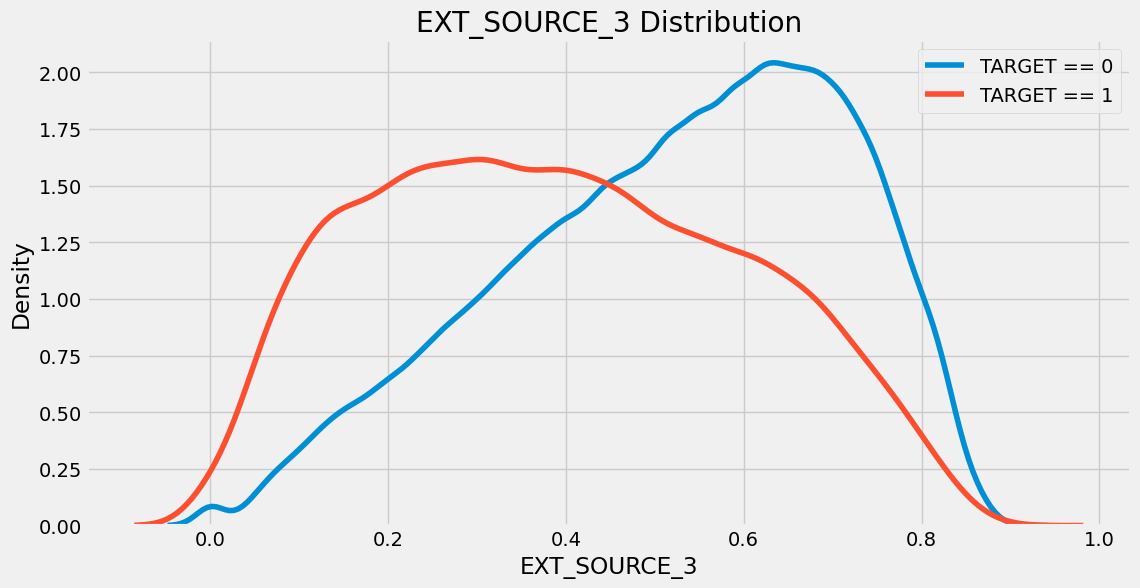

In [122]:
kde_target('EXT_SOURCE_3', train)

Passons maintenant à la nouvelle variable que nous venons de créer, à savoir le nombre de prêts antérieurs contractés auprès d'autres institutions.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


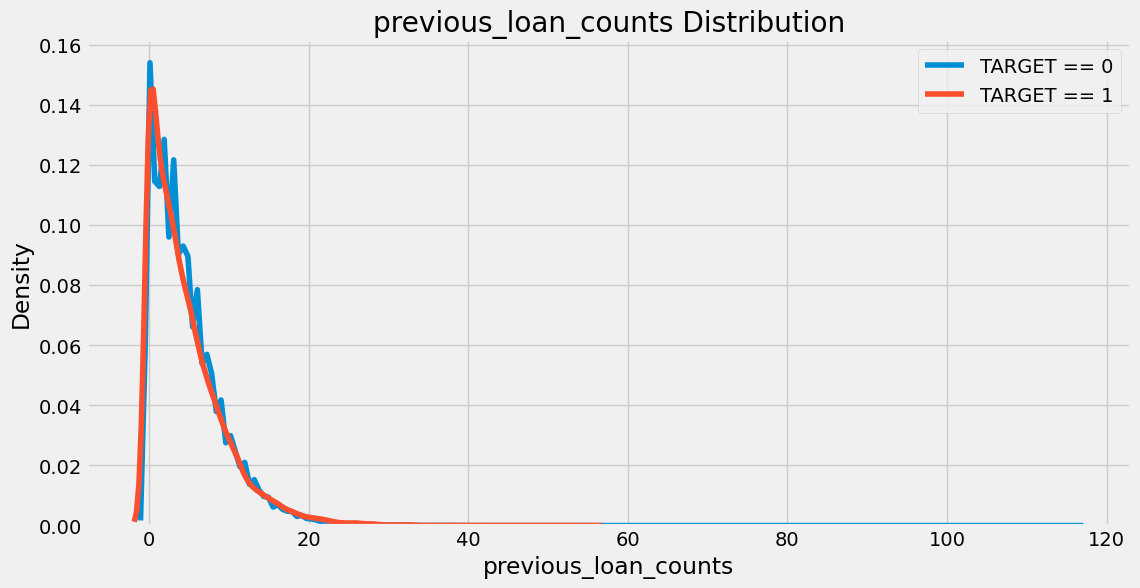

In [123]:
kde_target('previous_loan_counts', train)

Il est donc difficile de dire si cette variable sera importante. Le coefficient de corrélation est extrêmement faible et il n'y a pratiquement aucune différence notable dans les distributions.

Passons maintenant à la création de quelques autres variables à partir de la base de données du bureau. Nous prendrons la moyenne, la valeur minimale et la valeur maximale de chaque colonne numérique de la base de données Bureau.

### 3.1.1 - Aggregation des variables numériques

Nous allons faire un groupby sur l'ID Client et calculer le 'mean', 'max', 'min', 'sum' des prêts précédents

In [124]:
numeric_cols = bureau.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

['SK_ID_CURR',
 'SK_ID_BUREAU',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

Mémo : 
SK_ID_CURR	: ID du prêt qui nous intéresse - Un prêt peut avoir plusieurs précédents dans le credit bureau 
SK_BUREAU_ID :	 ID des prêts précédents

In [125]:
# Construction d'un dictionaire à passer dans agg, à partir des variables numériques, en excluant les ID
agg_dict = {col: ['count', 'mean', 'max', 'min', 'sum'] for col in numeric_cols[2:]}

In [126]:
agg_dict

{'DAYS_CREDIT': ['count', 'mean', 'max', 'min', 'sum'],
 'CREDIT_DAY_OVERDUE': ['count', 'mean', 'max', 'min', 'sum'],
 'DAYS_CREDIT_ENDDATE': ['count', 'mean', 'max', 'min', 'sum'],
 'DAYS_ENDDATE_FACT': ['count', 'mean', 'max', 'min', 'sum'],
 'AMT_CREDIT_MAX_OVERDUE': ['count', 'mean', 'max', 'min', 'sum'],
 'CNT_CREDIT_PROLONG': ['count', 'mean', 'max', 'min', 'sum'],
 'AMT_CREDIT_SUM': ['count', 'mean', 'max', 'min', 'sum'],
 'AMT_CREDIT_SUM_DEBT': ['count', 'mean', 'max', 'min', 'sum'],
 'AMT_CREDIT_SUM_LIMIT': ['count', 'mean', 'max', 'min', 'sum'],
 'AMT_CREDIT_SUM_OVERDUE': ['count', 'mean', 'max', 'min', 'sum'],
 'DAYS_CREDIT_UPDATE': ['count', 'mean', 'max', 'min', 'sum'],
 'AMT_ANNUITY': ['count', 'mean', 'max', 'min', 'sum']}

In [127]:
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index=False).agg(agg_dict)
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                   DAYS_CREDIT_ENDDATE                                      \
  mean max min sum               count        mean     max     min     sum   
0  0.0   0   0   0                   7   82.428571  1778.0 -1329.0   577.0   
1  0.0   0   0   0                   6 -349.000000   780.0 -1072.0 -2094.0   
2  0.0   0   0   0                   4 -544.500000  1216.0 -2434.0 -2178.0   
3  0.0   0   0   0                   2 -488.500000  -382.0  -595.0  -977.0   
4  0.0   0   0   0                   3  439.333333  1324.0  -128.0  1318.0   

  DAYS_ENDDATE_FACT                                      \
              count         mean    max     min     sum   
0                 4  -825.500000 -544.0 -1328.0 -3302.0   
1                 6  -697.500000  -36.0 -1185.0 -4185.0   
2                 3 -1097.333333 -540.0 -2131.0 -3292.0   
3                 2  -532.500000 -382.0  -683.0 -1065.0   
4                 1  -123.000000 -123.0  -123.0  -123.0   

  AMT_CREDIT_MAX_OVERDUE                                     \
                   count      mean       max  min       sum   
0                      0       NaN       NaN  NaN     0.000   
1                      5  1681.029  5043.645  0.0  8405.145   
2                      4     0.000     0.000  0.0     0.000   
3                      1     0.000     0.000  0.0     0.000   
4                      1     0.000     0.000  0.0     0.000   

  CNT_CREDIT_PROLONG                  AMT_CREDIT_SUM                           \
               count mean max min sum          count           mean       max   
0                  7  0.0   0   0   0              7  207623.571429  378000.0   
1                  8  0.0   0   0   0              8  108131.945625  450000.0   
2                  4  0.0   0   0   0              4  254350.125000  810000.0   
3                  2  0.0   0   0   0              2   94518.900000   94537.8   
4                  3  0.0   0   0   0              3  219042.000000  568800.0   

                        AMT_CREDIT_SUM_DEBT                                \
       min          sum               count           mean       max  min   
0  85500.0  1453365.000                   7   85240.928571  373239.0  0.0   
1      0.0   865055.565                   5   49156.200000  245781.0  0.0   
2  22248.0  1017400.500                   4       0.000000       0.0  0.0   
3  94500.0   189037.800                   2       0.000000       0.0  0.0   
4  29826.0   657126.000                   3  189469.500000  543087.0  0.0   

            AMT_CREDIT_SUM_LIMIT                                             \
        sum                count          mean         max  min         sum   
0  596686.5                    6       0.00000       0.000  0.0       0.000   
1  245781.0                    4    7997.14125   31988.565  0.0   31988.565   
2       0.0                    4  202500.00000  810000.000  0.0  810000.000   
3       0.0                    2       0.00000       0.000  0.0       0.000   
4  568408.5                    3       0.00000       0.000  0.0       0.000   

  AMT_CREDIT_SUM_OVERDUE                     DAYS_CREDIT_UPDATE              \
                   count mean  max  min  sum              count        mean   
0                      7  0.0  0.0  0.0  0.0                  7  -93.142857   
1                      8  0.0  0.0  0.0  0.0                  8 -499.875000   
2                      4  0.0  0.0  0.0  0.0                  4 -816.000000   
3 

Nous devons créer de nouveaux noms pour chacune de ces colonnes. Le code suivant crée de nouveaux noms en ajoutant le statut au nom. Ici, nous devons tenir compte du fait que la base de données a un index à plusieurs niveaux. Je trouve ces index déroutants et difficiles à utiliser, c'est pourquoi j'essaie de les réduire à un index à un seul niveau aussi rapidement que possible.

In [128]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [129]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   bureau_CREDIT_DAY_OVERDUE_sum  bureau_DAYS_CREDIT_ENDDATE_count  \
0                              0                                 7   
1                              0                                 6   
2                              0                                 4   
3                              0                                 2   
4                              0                                 3   

   bureau_DAYS_CREDIT_ENDDATE_mean  bureau_DAYS_CREDIT_ENDDATE_max  \
0                        82.428571                          1778.0   
1                      -349.000000                           780.0   
2                      -544.500000                          1216.0   
3                      -488.500000                          -382.0   
4                       439.333333                          1324.0   

   bureau_DAYS_CREDIT_ENDDATE_min  bureau_DAYS_CREDIT_ENDDATE_sum  \
0                         -1329.0                           577.0   
1                         -1072.0                         -2094.0   
2                         -2434.0                         -2178.0   
3                          -595.0                          -977.0   
4                          -128.0                          1318.0   

   bureau_DAYS_ENDDATE_FACT_count  bureau_DAYS_ENDDATE_FACT_mean  \
0                               4                    -825.500000   
1                               6                    -697.500000   
2                               3                   -1097.333333   
3                               2                    -532.500000   
4                               1                    -123.000000   

   bureau_DAYS_ENDDATE_FACT_max  bureau_DAYS_ENDDATE_FACT_min  \
0                        -544.0                       -1328.0   
1                         -36.0                       -1185.0   
2                        -540.0                       -2131.0   
3                        -382.0                        -683.0   
4                        -123.0                        -123.0   

   bureau_DAYS_ENDDATE_FACT_sum  bureau_AMT_CREDIT_MAX_OVERDUE_count  \
0                       -3302.0                                    0   
1                       -4185.0                                    5   
2                       -3292.0   

Merge avec le train

In [130]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   
3                    0.008019       19005        -3039.0            -9833.0   
4                    0.028663       19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

Nous pouvons calculer la corrélation de toutes les nouvelles valeurs avec la cible. Là encore, nous pouvons utiliser ces valeurs comme une approximation des variables qui peuvent être importantes pour la modélisation.

In [131]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

In [132]:
# Tri des corrélations par valeur absolue
# Inversement du tri pour placer les plus grandes valeurs en début de liste
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.089728967219981),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010374),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968684),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920795),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020585),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758622),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997309),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115936),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483553),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073023),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484667),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.0414036353530601),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632898),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332547)]

Aucune des nouvelles variables n'a de corrélation significative avec la cible. Nous pouvons examiner le graphique KDE de la variable la plus corrélée, bureau_DAYS_CREDIT_mean, avec la cible en termes de corrélation de magnitude absolue.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


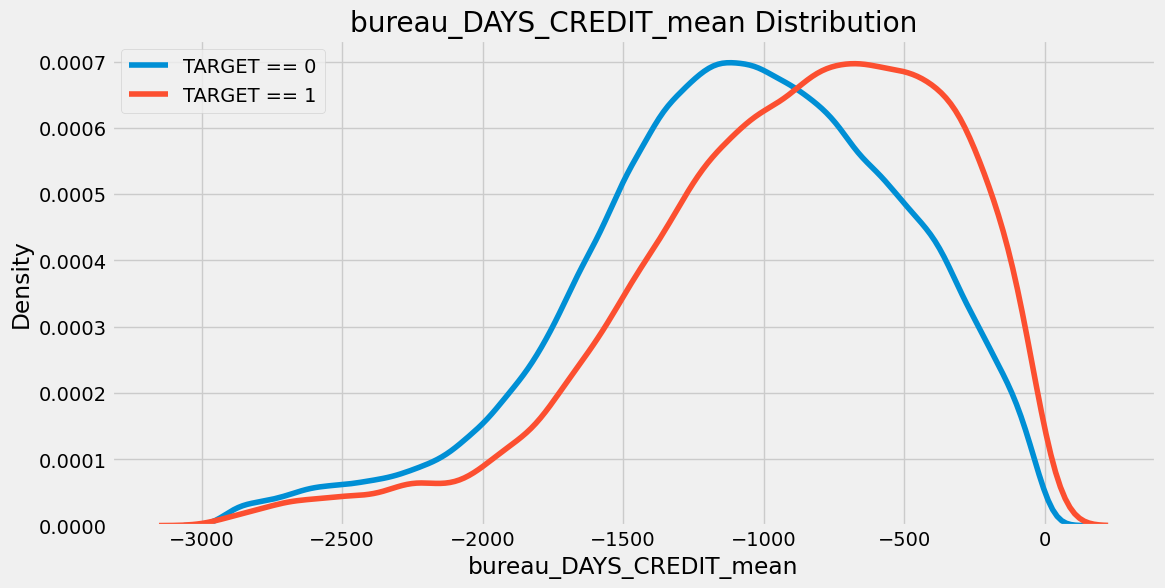

In [133]:
kde_target('bureau_DAYS_CREDIT_mean', train)

DAYS_CREDIT : Combien de jours avant la demande actuelle le client a-t-il demandé un crédit au Credit Bureau ?

Nous constatons une relation positive extrêmement faible entre la moyenne de cette variable et l'objectif, ce qui signifie que les clients qui ont demandé des prêts plus longtemps dans le passé sont potentiellement plus susceptibles de rembourser les prêts auprès de Home Credit. Cependant, avec une corrélation aussi faible, il est tout aussi probable qu'il s'agisse d'un bruit que d'un signal.

Lorsque nous disposons d'un grand nombre de variables, nous nous attendons à ce que certaines d'entre elles soient corrélées par pur hasard, un problème connu sous le nom de comparaisons multiples. Nous pouvons créer des centaines de caractéristiques, et certaines s'avéreront corrélées avec la cible simplement en raison du bruit aléatoire dans les données. Ensuite, lorsque notre modèle s'entraîne, il peut se surajuster à ces variables parce qu'il pense qu'elles ont une relation avec la cible dans l'ensemble d'apprentissage, mais cela ne se généralise pas nécessairement à l'ensemble de test. Il y a de nombreuses considérations à prendre en compte lorsque l'on crée des caractéristiques !

Encapsulons tout le travail précédent dans une fonction. Cela nous permettra de calculer des statistiques agrégées pour des colonnes numériques dans n'importe quel cadre de données. Nous réutiliserons cette fonction lorsque nous voudrons appliquer les mêmes opérations à d'autres cadres de données.

In [134]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

Avant de poursuivre, nous pouvons également transformer le code de calcul des corrélations avec la cible en une fonction.

In [135]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

### 3.1.2 - Aggregation des variables catégorielles

Il s'agit de variables discrètes, de sorte que nous ne pouvons pas nous contenter de calculer des statistiques telles que la moyenne et le maximum, qui ne fonctionnent qu'avec des variables numériques. Au lieu de cela, nous nous appuierons sur le calcul du nombre de valeurs de chaque catégorie au sein de chaque variable catégorielle. 

On commence par un One_Hot_Encoding des variables catégorielles

In [136]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  \
0                 False                   False                  True   
1                  True                   False                 False   
2                  True                   False                 False   
3                  True                   False                 False   
4                  True                   False                 False   

   CREDIT_ACTIVE_Sold  CREDIT_CURRENCY_currency 1  CREDIT_CURRENCY_currency 2  \
0               False                        True                       False   
1               False                        True                       False   
2               False                        True                       False   
3               False                        True                       False   
4               False                        True                       False   

   CREDIT_CURRENCY_currency 3  CREDIT_CURRENCY_currency 4  \
0                       False                       False   
1                       False                       False   
2                       False                       False   
3                       False                       False   
4                       False                       False   

   CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan  \
0                             False                 False   
1                             False                 False   
2                             False                 False   
3                             False                 False   
4                             False                 False   

   CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit  \
0                                  False                         True   
1                                  False                        False   
2                                  False                         True   
3                                  False                        False   
4                                  False                         True   

   CREDIT_TYPE_Credit card  CREDIT_TYPE_Interbank credit  \
0                    False                         False   
1                     True                         False   
2                    False                         False   
3                     True                         False   
4                    False                         False   

   CREDIT_TYPE_Loan for business development  \
0                                      False   
1                                      False   
2                                      False   
3                                      False   
4                                      False   

   CREDIT_TYPE_Loan for purchase of shares (margin lending)  \
0                                              False          
1                                              False          
2                                              False          
3                                              False          
4                                              False          

   CREDIT_TYPE_Loan for the purchase of equipment  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   

   CREDIT_TYPE_Loan for working capital replenishment  CREDIT_TYPE_Microloan  \
0                                              False                   False   
1                                              False                   False   
2                                              False                   False   
3                                              False                   False   
4                                              False                   False   

   CREDIT_TYPE_Mobile operator loan  CREDIT_TYPE_Mortgage  \
0             

Pour chacune de ces variables, on va calculer la somme et la moyenne par ID client 

In [137]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1      CREDIT_CURRENCY_currency 2       \
                                  sum mean                        sum mean   
SK_ID_CURR                                                                   
100001                              7  1.0                          0  0.0   
100002                              8  1.0                          0  0.0   
100003                              4  1.0                          0  0.0   
100004                              2  1.0                          0  0.0   
100005                              3  1.0                          0  0.0   

           CREDIT_CURRENCY_currency 3      CREDIT_CURRENCY_currency 4       \
                                  sum mean                        sum mean   
SK_ID_CURR                                                                   
100001                              0  0.0                          0  0.0   
100002                              0  0.0                          0  0.0   
100003                              0  0.0                          0  0.0   
100004                              0  0.0                          0  0.0   
100005                              0  0.0                          0  0.0   

           CREDIT_TYPE_Another type of loan      CREDIT_TYPE_Car loan       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Cash loan (non-earmarked)       \
                                             sum mean   
SK_ID_CURR                                              
100001                                         0  0.0   
100002                                         0  0.0   
100003                                         0  0.0   
100004                                         0  0.0   
100005                                         0  0.0   

           CREDIT_TYPE_Consumer credit           CREDIT_TYPE_Credit card  \
                                   sum      mean                     sum   
SK_ID_CURR                                                                 
100001                               7  1.000000                       0   
100002                               4  0.500000                       4   
100003                               2  0.500000                       2   
100004                               2  1.000000                       0   
100005   

Les colonnes de somme représentent le nombre de cette catégorie pour le client associé et la moyenne représente le nombre normalisé. 

Nous pouvons utiliser une fonction similaire à la précédente pour renommer les colonnes. Une fois de plus, nous devons gérer l'index à plusieurs niveaux des colonnes. Nous itérons à travers le premier niveau (niveau 0) qui est le nom de la variable catégorielle ajouté à la valeur de la catégorie (à partir de l'encodage à une touche). Ensuite, nous itérons les statistiques que nous avons calculées pour chaque client. Nous renommerons la colonne avec le nom du niveau 0 annexé à la statistique. Par exemple, la colonne avec CREDIT_ACTIF_Actif comme niveau 0 et somme comme niveau 1 deviendra CREDIT_ACTIF_Actif_count.

In [138]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [139]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [140]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

CREDIT_ACTIVE_Active_count  CREDIT_ACTIVE_Active_count_norm  \
SK_ID_CURR                                                                
100001                               3                         0.428571   
100002                               2                         0.250000   
100003                               1                         0.250000   
100004                               0                         0.000000   
100005                               2                         0.666667   

            CREDIT_ACTIVE_Bad debt_count  CREDIT_ACTIVE_Bad debt_count_norm  \
SK_ID_CURR                                                                    
100001                                 0                                0.0   
100002                                 0                                0.0   
100003                                 0                                0.0   
100004                                 0                                0.0   
100005                                 0                                0.0   

            CREDIT_ACTIVE_Closed_count  CREDIT_ACTIVE_Closed_count_norm  \
SK_ID_CURR                                                                
100001                               4                         0.571429   
100002                               6                         0.750000   
100003                               3                         0.750000   
100004                               2                         1.000000   
100005                               1                         0.333333   

            CREDIT_ACTIVE_Sold_count  CREDIT_ACTIVE_Sold_count_norm  \
SK_ID_CURR                                                            
100001                             0                            0.0   
100002                             0                            0.0   
100003                             0                            0.0   
100004                             0                            0.0   
100005                             0                            0.0   

            CREDIT_CURRENCY_currency 1_count  \
SK_ID_CURR                                     
100001                                     7   
100002                                     8   
100003                                     4   
100004                                     2   
100005                                     3   

            CREDIT_CURRENCY_currency 1_count_norm  \
SK_ID_CURR                                          
100001                                        1.0   
100002                                        1.0   
100003                                        1.0   
100004                                        1.0   
100005                                        1.0   

            CREDIT_CURRENCY_currency 2_count  \
SK_ID_CURR                                     
100001                                     0   
100002                                     0   
100003                                     0   
100004                                     0   
100005                                     0   

            CREDIT_CURRENCY_currency 2_count_norm  \
SK_ID_CURR                                          
100001                                        0.0   
100002                                        0.0   
100003                                        0.0   
100004                                        0.0   
100005                                        0.0   

            CREDIT_CURRENCY_currency 3_count  \
SK_ID_CURR                                     
100001                                     0   
100002                                     0   
100003                                     0   
100004                                     0   
100005                                     0   

            CREDIT_CURRENCY_currency 3_count_norm  \
SK_ID_CURR                                          
100001                                        0

On merge avec le training

In [141]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   
3                    0.008019       19005        -3039.0            -9833.0   
4                    0.028663       19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [142]:
train.shape

(307511, 234)

In [143]:
train.iloc[:10, 123:]

CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  CREDIT_TERM  \
0               2.007889                0.121978     0.060749   
1               4.790750                0.132217     0.027598   
2               2.000000                0.100000     0.050000   
3               2.316167                0.219900     0.094941   
4               4.222222                0.179963     0.042623   
5               4.954500                0.277955     0.056101   
6               9.127053                0.241526     0.026463   
7               4.250000                0.116875     0.027500   
8               9.063200                0.300680     0.033176   
9               3.000000                0.150000     0.050000   

   DAYS_EMPLOYED_PERCENT  previous_loan_counts  bureau_DAYS_CREDIT_count  \
0              -0.067329                   8.0                       8.0   
1              -0.070862                   4.0                       4.0   
2              -0.011814                   2.0                       2.0   
3              -0.159905                   0.0                       NaN   
4              -0.152418                   1.0                       1.0   
5              -0.093737                   3.0                       3.0   
6              -0.227174                  18.0                      18.0   
7              -0.023820                   2.0                       2.0   
8                    NaN                   4.0                       4.0   
9              -0.139540                   0.0                       NaN   

   bureau_DAYS_CREDIT_mean  bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  \
0              -874.000000                  -103.0                 -1437.0   
1             -1400.750000                  -606.0                 -2586.0   
2              -867.000000                  -408.0                 -1326.0   
3                      NaN                     NaN                     NaN   
4             -1149.000000                 -1149.0                 -1149.0   
5              -757.333333                   -78.0                 -1097.0   
6             -1271.500000                  -239.0                 -2882.0   
7             -1939.500000                 -1138.0                 -2741.0   
8             -1773.000000                 -1309.0                 -2508.0   
9                      NaN                     NaN                     NaN   

   bureau_DAYS_CREDIT_sum  bureau_CREDIT_DAY_OVERDUE_count  \
0                 -6992.0                              8.0   
1                 -5603.0                              4.0   
2                 -1734.0                              2.0   
3                     NaN                              NaN   
4                 -1149.0                              1.0   
5                 -2272.0                              3.0   
6                -22887.0                             18.0   
7                 -3879.0                              2.0   
8                 -7092.0                              4.0   
9                     NaN                              NaN   

   bureau_CREDIT_DAY_OVERDUE_mean  bureau_CREDIT_DAY_OVERDUE_max  \
0                             0.0                            0.0   
1                             0.0                            0.0   
2                             0.0                            0.0   
3                             NaN                            NaN   
4                             0.0                            0.0   
5                             0.0                            0.0   
6                             0.0                            0.0   
7                             0.0                            0.0   
8                             0.0                            0.0   
9                             NaN                            NaN   

   bureau_CREDIT_DAY_OVERDUE_min  bureau_CREDIT_DAY_OVERDUE_sum  \
0                            0.0                            0.0   
1                        

Pour rendre le code plus efficace, nous pouvons maintenant écrire une fonction pour gérer les variables catégorielles. Cette fonction prendra la même forme que la fonction agg_numeric, c'est-à-dire qu'elle acceptera un cadre de données et une variable de regroupement. Elle calculera ensuite les effectifs et les effectifs normalisés de chaque catégorie pour toutes les variables catégorielles de la base de données.

In [144]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes(['object', 'category']))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

## 3.2 - Depuis le dataframe "bureau_balance"

Nous allons maintenant nous pencher sur la base de données 'bureau_balance'.   
Ce dataframe contient des informations mensuelles sur le(s) prêt(s) précédent(s) de chaque client auprès d'autres institutions financières. Au lieu de regrouper ce dataframe par **SK_ID_CURR (identifiant du client)**, nous allons d'abord regrouper le dataframe par **SK_ID_BUREAU (identifiant du prêt précédent)**. 
Nous obtiendrons ainsi une ligne du dataframe pour chaque prêt. 
Ensuite, nous pourrons regrouper par SK_ID_CURR et calculer les agrégations pour les prêts de chaque client. 
Le résultat final sera un dataframe avec une ligne pour chaque client, avec des statistiques calculées pour leurs prêts.

In [145]:
bureau_balance = pd.read_csv('bureau_balances.csv')
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

**MONTHS_BALANCE**=Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente)  

**STATUS**= Statut du prêt du Bureau de Crédit durant le mois (actif, clôturé, DPD0-30, ... [C signifie clôturé, X signifie statut inconnu, 0 signifie pas de DPD, 1 signifie le maximum fait durant le mois entre 1-30, 2 signifie DPD 31-60, ... 5 signifie DPD 120+ ou vendu ou radié])".
Cette phrase décrit les différents statuts possibles d'un prêt rapporté au Bureau de Crédit pendant un mois donné, incluant des informations sur les jours de retard de paiement (DPD - Days Past Due)

Tout d'abord, nous pouvons calculer le nombre de valeurs de chaque statut pour chaque prêt. Pour ça, on va réutiliser notre fonction

In [146]:
# Counts of each type of status for each previous loan
bureau_balance_counts = agg_categorical(bureau_balance, 'SK_ID_BUREAU', 'bureau_balance')
bureau_balance_counts.head()

bureau_balance_STATUS_4_mean  bureau_balance_STATUS_3_mean  \
SK_ID_BUREAU                                                               
5001709                                0.0                           0.0   
5001710                                0.0                           0.0   
5001711                                0.0                           0.0   
5001712                                0.0                           0.0   
5001713                                0.0                           0.0   

              bureau_balance_STATUS_2_mean  bureau_balance_STATUS_5_mean  \
SK_ID_BUREAU                                                               
5001709                                0.0                           0.0   
5001710                                0.0                           0.0   
5001711                                0.0                           0.0   
5001712                                0.0                           0.0   
5001713                                0.0                           0.0   

              bureau_balance_STATUS_4_sum  bureau_balance_STATUS_3_sum  \
SK_ID_BUREAU                                                             
5001709                                 0                            0   
5001710                                 0                            0   
5001711                                 0                            0   
5001712                                 0                            0   
5001713                                 0                            0   

              bureau_balance_STATUS_2_sum  bureau_balance_STATUS_5_sum  \
SK_ID_BUREAU                                                             
5001709                                 0                            0   
5001710                                 0                            0   
5001711                                 0                            0   
5001712                                 0                            0   
5001713                                 0                            0   

              bureau_balance_STATUS_1_mean  bureau_balance_STATUS_1_sum  \
SK_ID_BUREAU                                                              
5001709                                0.0                            0   
5001710                                0.0                            0   
5001711                                0.0                            0   
5001712                                0.0                            0   
5001713                                0.0                            0   

              bureau_balance_STATUS_0_mean  bureau_balance_STATUS_0_sum  \
SK_ID_BUREAU                                                              
5001709                           0.000000                            0   
5001710                           0.060241                            5   
5001711                           0.750000                            3   
5001712                           0.526316                           10   
5001713                           0.000000                            0   

              bureau_balance_STATUS_X_mean  bureau_balance_STATUS_C_mean  \
SK_ID_BUREAU                                                               
5001709                           0.113402                      0.886598   
5001710                           0.361446                      0.578313   
5001711                           0.250000                      0.000000   
5001712                           0.000000                      0.473684   
5001713                           1.000000                      0.000000   

              bureau_balance_STATUS_X_sum  bureau_balance_STATUS_C_sum  \
SK_ID_BUREAU                                                             
5001709                                11                           86   
5001710                                30                           48   
5001711                      

La colonne MONTHS_BALANCE contient les « mois de solde par rapport à la date de la demande ». Cette variable numérique n'est pas nécessairement très importante et, dans le cadre de travaux futurs, nous pourrions la considérer comme une variable temporelle. Pour l'instant, nous pouvons simplement calculer les mêmes statistiques d'agrégation que précédemment.

In [147]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

bureau_balance_MONTHS_BALANCE_sum  \
SK_ID_BUREAU                                      
5001709                                   -4656   
5001710                                   -3403   
5001711                                      -6   
5001712                                    -171   
5001713                                    -231   

              bureau_balance_MONTHS_BALANCE_min  \
SK_ID_BUREAU                                      
5001709                                     -96   
5001710                                     -82   
5001711                                      -3   
5001712                                     -18   
5001713                                     -21   

              bureau_balance_MONTHS_BALANCE_mean  \
SK_ID_BUREAU                                       
5001709                                    -48.0   
5001710                                    -41.0   
5001711                                     -1.5   
5001712                                     -9.0   
5001713                                    -10.5   

              bureau_balance_MONTHS_BALANCE_max  \
SK_ID_BUREAU                                      
5001709                                       0   
5001710                                       0   
5001711                                       0   
5001712                                       0   
5001713                                       0   

              bureau_balance_MONTHS_BALANCE_count  
SK_ID_BUREAU                                       
5001709                                        97  
5001710                                        83  
5001711                                         4  
5001712                                        19  
5001713                                        22

Les dataframe ci-dessus contiennent les calculs effectués pour chaque prêt. Nous devons maintenant les agréger pour chaque client. Nous pouvons le faire en fusionnant d'abord les dataframes, puis, comme toutes les variables sont numériques, il nous suffit d'agréger à nouveau les statistiques, en les regroupant cette fois par SK_ID_CURR.

In [148]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

SK_ID_BUREAU  bureau_balance_MONTHS_BALANCE_sum  \
0       5001709                              -4656   
1       5001710                              -3403   
2       5001711                                 -6   
3       5001712                               -171   
4       5001713                               -231   

   bureau_balance_MONTHS_BALANCE_min  bureau_balance_MONTHS_BALANCE_mean  \
0                                -96                               -48.0   
1                                -82                               -41.0   
2                                 -3                                -1.5   
3                                -18                                -9.0   
4                                -21                               -10.5   

   bureau_balance_MONTHS_BALANCE_max  bureau_balance_MONTHS_BALANCE_count  \
0                                  0                                   97   
1                                  0                                   83   
2                                  0                                    4   
3                                  0                                   19   
4                                  0                                   22   

   bureau_balance_STATUS_4_mean  bureau_balance_STATUS_3_mean  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   bureau_balance_STATUS_2_mean  bureau_balance_STATUS_5_mean  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   bureau_balance_STATUS_4_sum  bureau_balance_STATUS_3_sum  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   bureau_balance_STATUS_2_sum  bureau_balance_STATUS_5_sum  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   bureau_balance_STATUS_1_mean  bureau_balance_STATUS_1_sum  \
0                           0.0                            0   
1                           0.0                            0   
2                           0.0                            0   
3                           0.0                            0   
4                           0.0                            0   

   bureau_balance_STATUS_0_mean  bureau_balance_STATUS_0_sum  \
0                      0.000000                            0   
1                      0.060241                            5   
2                      0.750000                            3   
3                      0.526316                           10   
4                      0.000000                            0   

   bureau_balance_STATUS_X_mean  bureau_balance_STATUS_C_mean  \
0                      0.113402                      0.886598   
1                      0.361446                      0.578313   
2                      0.250000                      0.000000   
3                      0.000000                      0.473684   
4                      1.000000                      0.000000   

   bureau_balance_STATUS_X_sum  bureau_balance_STATUS_C_s

In [149]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

client_bureau_balance_MONTHS_BALANCE_sum_sum  \
SK_ID_CURR                                                 
100001.0                                           -2800   
100002.0                                           -2701   
100005.0                                             -91   
100010.0                                           -3312   
100013.0                                           -6756   

            client_bureau_balance_MONTHS_BALANCE_sum_min  \
SK_ID_CURR                                                 
100001.0                                           -1326   
100002.0                                            -632   
100005.0                                             -78   
100010.0                                           -2610   
100013.0                                           -2346   

            client_bureau_balance_MONTHS_BALANCE_sum_mean  \
SK_ID_CURR                                                  
100001.0                                      -400.000000   
100002.0                                      -337.625000   
100005.0                                       -30.333333   
100010.0                                     -1656.000000   
100013.0                                     -1689.000000   

            client_bureau_balance_MONTHS_BALANCE_min_sum  \
SK_ID_CURR                                                 
100001.0                                            -165   
100002.0                                            -226   
100005.0                                             -18   
100010.0                                            -127   
100013.0                                            -226   

            client_bureau_balance_MONTHS_BALANCE_mean_sum  \
SK_ID_CURR                                                  
100001.0                                            -82.5   
100002.0                                           -175.0   
100005.0                                             -9.0   
100010.0                                            -92.0   
100013.0                                           -113.0   

            client_bureau_balance_MONTHS_BALANCE_min_min  \
SK_ID_CURR                                                 
100001.0                                             -51   
100002.0                                             -47   
100005.0                                             -12   
100010.0                                             -90   
100013.0                                             -68   

            client_bureau_balance_MONTHS_BALANCE_mean_min  \
SK_ID_CURR                                                  
100001.0                                            -25.5   
100002.0                                            -39.5   
100005.0                                             -6.0   
100010.0                                            -72.5   
100013.0                                            -34.0   

            client_bureau_balance_MONTHS_BALANCE_min_mean  \
SK_ID_CURR                                                  
100001.0                                       -23.571429   
100002.0                                       -28.250000   
100005.0                                        -6.000000   
100010.0                                       -63.500000   
100013.0                                       -56.500000   

            client_bureau_balance_MONTHS_BALANCE_mean_mean  \
SK_ID_CURR                                                   
100001.0                                        -11.785714   
100002.0                                        -21.875000   
100005.0                                         -3.000000   
100010.0                                        -46.000000   
100013.0                                        -28.250000   

            client_bureau_balance_MONTHS_BALANCE_sum_max  \
SK_ID_CURR                                                 
100001.0                                              -1   
1

Pour résumer, pour le dataframe bureau_balance, nous avons:
- calculé les statistiques numériques en les regroupant par prêt
- comptabilisé les valeurs de chaque variable catégorielle en les regroupant par prêt.
- Fusionné les statistiques et les comptages de valeurs sur les prêts
- Calculé les statistiques numériques pour la base de données résultante, en les regroupant par identifiant de client.

Le dataframe final comporte une ligne pour chaque client, avec des statistiques calculées pour tous leurs prêts avec des informations sur le solde mensuel.

Certaines de ces variables sont un peu confuses, alors essayons d'en expliquer quelques-unes :
- client_bureau_balance_MONTHS_BALANCE_mean_mean : Pour chaque prêt, calcul de la valeur moyenne de MONTHS_BALANCE. Ensuite, pour chaque client, calcul de la moyenne de cette valeur pour tous ses prêts.
- client_bureau_balance_STATUS_X_count_norm_sum : Pour chaque prêt, calcul du nombre d'occurrences de STATUS == X divisé par le nombre de valeurs STATUS totales pour le prêt. Ensuite, pour chaque client, addition des valeurs pour chaque prêt.
  
Nous ne calculerons pas les corrélations tant que nous n'aurons pas rassemblé toutes les variables dans un seul dataframe

Nous disposons à présent de tous les éléments nécessaires pour rassembler les informations relatives aux prêts antérieurs contractés auprès d'autres institutions et les informations relatives aux paiements mensuels de ces prêts dans le dataframe principal de training. 


In [150]:
# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [151]:
new_features = list(train.columns)
print("Nombre de variables utilisant les prêts précédents passés dans d'autres institutions financières: ", len(new_features))

Nombre de variables utilisant les prêts précédents passés dans d'autres institutions financières:  319


In [152]:
train.shape

(307511, 319)

## 3.3 - Depuis le dataframe 'previous_application'

In [151]:
previous = pd.read_csv('previous_applications.csv')
previous.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

Avant d'aller plus loin, on va créer une fonction pour convertir les types de variables. Cela permettra de réduire l'utilisation de la mémoire en utilisant des types plus efficaces pour les variables. Par exemple, la catégorie est souvent un meilleur type que l'objet (sauf si le nombre de catégories uniques est proche du nombre de lignes dans le cadre de données).

In [152]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [153]:
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans   1730.430054          17145.0   
1     2802425      108129         Cash loans  25188.615234         607500.0   
2     2523466      122040         Cash loans  15060.735352         112500.0   
3     2819243      176158         Cash loans  47041.335938         450000.0   
4     1784265      202054         Cash loans  31924.394531         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                    True                0.0               0.182832   
1                    True                NaN                    NaN   
2                    True                NaN                    NaN   
3                    True                NaN                    NaN   
4                    True                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

In [154]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 80)


previous_DAYS_DECISION_sum  previous_DAYS_DECISION_min  \
SK_ID_CURR                                                           
100001                           -1740                       -1740   
100002                            -606                        -606   
100003                           -3915                       -2341   
100004                            -815                        -815   
100005                           -1072                        -757   

            previous_DAYS_DECISION_mean  previous_DAYS_DECISION_max  \
SK_ID_CURR                                                            
100001                          -1740.0                       -1740   
100002                           -606.0                        -606   
100003                          -1305.0                        -746   
100004                           -815.0                        -815   
100005                           -536.0                        -315   

            previous_DAYS_FIRST_DUE_sum  previous_DAYS_FIRST_DUE_min  \
SK_ID_CURR                                                             
100001                          -1709.0                      -1709.0   
100002                           -565.0                       -565.0   
100003                          -3823.0                      -2310.0   
100004                           -784.0                       -784.0   
100005                           -706.0                       -706.0   

            previous_DAYS_FIRST_DUE_mean  previous_DAYS_FIRST_DUE_max  \
SK_ID_CURR                                                              
100001                      -1709.000000                      -1709.0   
100002                       -565.000000                       -565.0   
100003                      -1274.333374                       -716.0   
100004                       -784.000000                       -784.0   
100005                       -706.000000                       -706.0   

            previous_DAYS_LAST_DUE_sum  previous_DAYS_LAST_DUE_min  \
SK_ID_CURR                                                           
100001                         -1619.0                     -1619.0   
100002                           -25.0                       -25.0   
100003                         -3163.0                     -1980.0   
100004                          -724.0                      -724.0   
100005                          -466.0                      -466.0   

            previous_DAYS_LAST_DUE_mean  previous_DAYS_LAST_DUE_max  \
SK_ID_CURR                                                            
100001                     -1619.000000                     -1619.0   
100002                       -25.000000                       -25.0   
100003                     -1054.333374                      -536.0   
100004                      -724.000000                      -724.0   
100005                      -466.000000                      -466.0   

            previous_DAYS_TERMINATION_sum  previous_DAYS_TERMINATION_min  \
SK_ID_CURR                                                                 
100001                            -1612.0                        -1612.0   
100002                              -17.0                          -17.0   
100003                            -3142.0                        -1976.0   
100004                             -714.0                         -714.0   
100005                             -460.0                         -460.0   

            previous_DAYS_TERMINATION_mean  previous_DAYS_TERMINATION_max  \
SK_ID_CURR                                                                  
100001                        -1612.000000                        -1612.0   
100002                          -17.000000                          -17.0   
100003                        -1047.333374                         -527.0   
100004                         -714.000000                         -714.0   
100005                

In [155]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


previous_NAME_GOODS_CATEGORY_Animals_mean  \
SK_ID_CURR                                              
100001                                            0.0   
100002                                            0.0   
100003                                            0.0   
100004                                            0.0   
100005                                            0.0   

            previous_NAME_GOODS_CATEGORY_Animals_sum  \
SK_ID_CURR                                             
100001                                             0   
100002                                             0   
100003                                             0   
100004                                             0   
100005                                             0   

            previous_NAME_GOODS_CATEGORY_House Construction_mean  \
SK_ID_CURR                                                         
100001                                                    0.0      
100002                                                    0.0      
100003                                                    0.0      
100004                                                    0.0      
100005                                                    0.0      

            previous_NAME_GOODS_CATEGORY_House Construction_sum  \
SK_ID_CURR                                                        
100001                                                      0     
100002                                                      0     
100003                                                      0     
100004                                                      0     
100005                                                      0     

            previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean  \
SK_ID_CURR                                                                  
100001                                                    0.0               
100002                                                    0.0               
100003                                                    0.0               
100004                                                    0.0               
100005                                                    0.0               

            previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum  \
SK_ID_CURR                                                                 
100001                                                      0              
100002                                                      0              
100003                                                      0              
100004                                                      0              
100005                                                      0              

            previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean  \
SK_ID_CURR                                                                  
100001                                                    0.0               
100002                                                    0.0               
100003                                                    0.0               
100004                                                    0.0               
100005                                                    0.0               

            previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum  \
SK_ID_CURR                                                                 
100001                                                      0              
100002                                                      0              
100003                                                      0              
100004                                                      0              
100005                                                      0              

            previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean  \
SK_ID_CURR                                               
100001    

Nous pouvons joindre la base de données calculée à la base de données d'apprentissage principale à l'aide d'une fusion. Nous devons ensuite supprimer les dataframes calculés pour éviter d'utiliser une trop grande partie de la mémoire du noyau.

In [156]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')


# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

17907

Suppresion des variables dont les MV sont >90%

In [157]:
# train = remove_missing_columns(train)

Fonction d'agrégation des statistiques au niveau du client

In [158]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan and then the client
                                          (example ['SK_ID_PREV', 'SK_ID_CURR'])
        df_names (list of two strings): names to call the resulting columns
                                        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
                               Each client will have a single row with all the numeric data aggregated
    """
    
    # Assume agg_numeric and agg_categorical are defined elsewhere, adjust as necessary

    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var=group_vars[0], df_name=df_names[0])
    
    # Check if there are categorical or object type variables
    if any(df.dtypes.isin(['category', 'object'])):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var=group_vars[0], df_name=df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on=group_vars[0], how='outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on=group_vars[0], how='left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns=[group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var=group_vars[1], df_name=df_names[1])

    # No categorical or object variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on=group_vars[0], how='left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns=[group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var=group_vars[1], df_name=df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client


## 3.4 - Depuis le dataframe  POS_CASH_balance

In [159]:
cash = pd.read_csv('POS_CASH_balances.csv')

cash.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [160]:
cash = convert_types(cash, print_info=True)
cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.41 gb.


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [161]:
cash_by_client = aggregate_client(cash, ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

client_cash_MONTHS_BALANCE_sum_sum  \
SK_ID_CURR                                       
100001                                   -2887   
100002                                   -3610   
100003                                  -13240   
100004                                    -408   
100005                                   -2420   

            client_cash_MONTHS_BALANCE_min_sum  \
SK_ID_CURR                                       
100001                                    -669   
100002                                    -361   
100003                                   -1348   
100004                                    -108   
100005                                    -275   

            client_cash_MONTHS_BALANCE_mean_sum  \
SK_ID_CURR                                        
100001                                   -653.0   
100002                                   -190.0   
100003                                  -1226.0   
100004                                   -102.0   
100005                                   -220.0   

            client_cash_MONTHS_BALANCE_max_sum  \
SK_ID_CURR                                       
100001                                    -637   
100002                                     -19   
100003                                   -1104   
100004                                     -96   
100005                                    -165   

            client_cash_MONTHS_BALANCE_sum_min  \
SK_ID_CURR                                       
100001                                    -378   
100002                                    -190   
100003                                    -858   
100004                                    -102   
100005                                    -220   

            client_cash_MONTHS_BALANCE_sum_mean  \
SK_ID_CURR                                        
100001                              -320.777778   
100002                              -190.000000   
100003                              -472.857143   
100004                              -102.000000   
100005                              -220.000000   

            client_cash_MONTHS_BALANCE_sum_max  \
SK_ID_CURR                                       
100001                                    -275   
100002                                    -190   
100003                                    -172   
100004                                    -102   
100005                                    -220   

            client_cash_MONTHS_BALANCE_min_min  \
SK_ID_CURR                                       
100001                                     -96   
100002                                     -19   
100003                                     -77   
100004                                     -27   
100005                                     -25   

            client_cash_MONTHS_BALANCE_mean_min  \
SK_ID_CURR                                        
100001                                    -94.5   
100002                                    -10.0   
100003                                    -71.5   
100004                                    -25.5   
100005                                    -20.0   

            client_cash_MONTHS_BALANCE_max_min  \
SK_ID_CURR                                       
100001                                     -93   
100002                                      -1   
100003                                     -66   
100004                                     -24   
100005                                     -15   

            client_cash_MONTHS_BALANCE_min_mean  \
SK_ID_CURR                                        
100001                               -74.333333   
100002                               -19.000000   
100003                               -48.142857   
100004                               -27.000000   
100005                               -25.000000   

            client_cash_MONTHS_BALANCE_mean_mean  \
SK_ID_CURR                                         
100001             

In [162]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 94)


0

In [163]:
# train = remove_missing_columns(train)

## 3.5 - Depuis le dataframe  credit_card_balance

In [164]:
credit = pd.read_csv('credit_card_balances.csv')
credit.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [165]:
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE    AMT_BALANCE  \
0     2562384      378907              -6      56.970001   
1     2582071      363914              -1   63975.554688   
2     1740877      371185              -7   31815.224609   
3     1389973      337855              -4  236572.109375   
4     1891521      126868              -1  453919.468750   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0              1700.324951               1800.0                     1800.0   
1              2250.000000               2250.0                     2250.0   
2              2250.000000               2250.0                     2250.0   
3             11795.759766              11925.0                    11925.0   
4             22924.890625              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                  0.000000       0.000000              0.000000   
1              60175.078125   64875.554688          64875.554688   
2              26926.425781   31460.085938          31460.085938   
3             224949.281250  233048.968750         233048.968750   
4             443044.406250  453919.468750         453919.468750   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [166]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

client_credit_MONTHS_BALANCE_sum_sum  \
SK_ID_CURR                                         
100006                                      -126   
100011                                   -210826   
100013                                   -446976   
100021                                     -2890   
100023                                      -480   

            client_credit_MONTHS_BALANCE_min_sum  \
SK_ID_CURR                                         
100006                                       -36   
100011                                     -5550   
100013                                     -9216   
100021                                      -306   
100023                                       -88   

            client_credit_MONTHS_BALANCE_mean_sum  \
SK_ID_CURR                                          
100006                                      -21.0   
100011                                    -2849.0   
100013                                    -4656.0   
100021                                     -170.0   
100023                                      -60.0   

            client_credit_MONTHS_BALANCE_sum_min  \
SK_ID_CURR                                         
100006                                       -21   
100011                                     -2849   
100013                                     -4656   
100021                                      -170   
100023                                       -60   

            client_credit_MONTHS_BALANCE_sum_mean  \
SK_ID_CURR                                          
100006                                      -21.0   
100011                                    -2849.0   
100013                                    -4656.0   
100021                                     -170.0   
100023                                      -60.0   

            client_credit_MONTHS_BALANCE_sum_max  \
SK_ID_CURR                                         
100006                                       -21   
100011                                     -2849   
100013                                     -4656   
100021                                      -170   
100023                                       -60   

            client_credit_MONTHS_BALANCE_max_sum  \
SK_ID_CURR                                         
100006                                        -6   
100011                                      -148   
100013                                       -96   
100021                                       -34   
100023                                       -32   

            client_credit_MONTHS_BALANCE_min_min  \
SK_ID_CURR                                         
100006                                        -6   
100011                                       -75   
100013                                       -96   
100021                                       -18   
100023                                       -11   

            client_credit_MONTHS_BALANCE_min_mean  \
SK_ID_CURR                                          
100006                                       -6.0   
100011                                      -75.0   
100013                                      -96.0   
100021                                      -18.0   
100023                                      -11.0   

            client_credit_MONTHS_BALANCE_min_max  \
SK_ID_CURR                                         
100006                                        -6   
100011                                       -75   
100013                                       -96   
100021                                       -18   
100023                                       -11   

            client_credit_MONTHS_BALANCE_mean_min  \
SK_ID_CURR                                          
100006                                       -3.5   
100011                                      -38.5   
100013                                      -48.5   
100021                                      -10.0   
100023                 

In [167]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 376)


0

In [168]:
# train = remove_missing_columns(train)

## 3.6 - Depuis le dataframe 'installments_payments'

In [169]:
installments = pd.read_csv('installments_payment.csv')
installments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [170]:
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  
0          -1180.0             -1187.0     6948.359863   6948.359863  
1          -2156.0             -2156.0     1716.525024   1716.525024  
2            -63.0               -63.0    25425.000000  25425.000000  
3          -2418.0             -2426.0    24350.130859  24350.130859  
4          -1383.0             -1366.0     2165.040039   2160.584961

In [171]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

client_installments_DAYS_ENTRY_PAYMENT_sum_sum  \
SK_ID_CURR                                                   
100001                                            -52813.0   
100002                                           -113867.0   
100003                                           -367137.0   
100004                                             -6855.0   
100005                                            -49374.0   

            client_installments_DAYS_INSTALMENT_sum_sum  \
SK_ID_CURR                                                
100001                                         -52598.0   
100002                                        -106495.0   
100003                                        -365546.0   
100004                                          -6786.0   
100005                                         -47466.0   

            client_installments_DAYS_ENTRY_PAYMENT_min_sum  \
SK_ID_CURR                                                   
100001                                            -15608.0   
100002                                            -11153.0   
100003                                            -37757.0   
100004                                             -2385.0   
100005                                             -6624.0   

            client_installments_DAYS_INSTALMENT_min_sum  \
SK_ID_CURR                                                
100001                                         -15584.0   
100002                                         -10735.0   
100003                                         -37514.0   
100004                                          -2352.0   
100005                                          -6354.0   

            client_installments_DAYS_ENTRY_PAYMENT_mean_sum  \
SK_ID_CURR                                                    
100001                                             -15365.0   
100002                                              -5993.0   
100003                                             -34633.0   
100004                                              -2285.0   
100005                                              -5486.0   

            client_installments_DAYS_INSTALMENT_mean_sum  \
SK_ID_CURR                                                 
100001                                          -15314.0   
100002                                           -5605.0   
100003                                          -34454.0   
100004                                           -2262.0   
100005                                           -5274.0   

            client_installments_DAYS_ENTRY_PAYMENT_max_sum  \
SK_ID_CURR                                                   
100001                                            -15080.0   
100002                                              -931.0   
100003                                            -31594.0   
100004                                             -2181.0   
100005                                             -4230.0   

            client_installments_DAYS_INSTALMENT_max_sum  \
SK_ID_CURR                                                
100001                                         -15044.0   
100002                                           -475.0   
100003                                         -31394.0   
100004                                          -2172.0   
100005                                          -4194.0   

            client_installments_DAYS_INSTALMENT_sum_min  \
SK_ID_CURR                                                
100001                                          -8658.0   
100002                                          -5605.0   
100003                                         -25740.0   
100004                                          -2262.0   
100005                                          -5274.0   

            client_installments_DAYS_ENTRY_PAYMENT_sum_min  \
SK_ID_CURR                                                   
100001                                             -8647.0   
10

In [172]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 106)


0

In [173]:
# train= remove_missing_columns(train)

In [174]:
print('Final Training Shape: ', train.shape)

Final Training Shape:  (307511, 1260)


In [175]:
print(f'Final training size: {return_size(train)}')

Final training size: 2.85


In [176]:
train.to_csv('train_previous_raw.csv', index = False, chunksize = 500)

# 4 - Feature Selection

Un plus grand nombre de features peut sembler une bonne chose, et c'est le cas si elles aident notre modèle à apprendre. Cependant, les features non pertinentes, les features fortement corrélées et les valeurs manquantes peuvent empêcher le modèle d'apprendre et diminuer les performances de généralisation sur les données de test. C'est pourquoi nous procédons à une sélection des features afin de ne conserver que les variables les plus utiles.

Nous commencerons la sélection des features en nous concentrant sur les variables colinéaires.

In [177]:
df=pd.read_csv('train_previous_raw.csv')

In [178]:
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461         -637.0            -3648.0   
1                    0.003541       16765        -1188.0            -1186.0   
2                    0.010032       19046         -225.0            -4260.0   
3                    0.008019       19005        -3039.0            -9833.0   
4                    0.028663       19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [179]:
df[['EXT_SOURCE_1',
 'CREDIT_TERM',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'client_installments_AMT_PAYMENT_min_sum',
 'AMT_ANNUITY',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'bureau_DAYS_CREDIT_max']].head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   
1      0.311267     0.027598      0.622246           NaN        -1188.0   
2           NaN     0.050000      0.555912      0.729567         -225.0   
3           NaN     0.094941      0.650442           NaN        -3039.0   
4           NaN     0.042623      0.322738           NaN        -3038.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   
1       16765                               1154108.20      35698.5   
2       19046                                 16071.75       6750.0   
3       19005                                994476.70      29686.5   
4       19932                                483756.38      21865.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  
0                           780.0                  -103.0  
1                          1216.0                  -606.0  
2                          -382.0                  -408.0  
3                             NaN                     NaN  
4                          -783.0                 -1149.0

In [180]:
df.shape

(307511, 1260)

In [181]:
# train.columns.tolist()

## 4.1 - Suppression des variables colinéaires

Les variables colinéaires sont celles qui sont fortement corrélées entre elles. Elles peuvent diminuer la disponibilité du modèle pour l'apprentissage, diminuer l'interprétabilité du modèle et diminuer les performances de généralisation sur l'ensemble de test. Il est clair que ce sont là trois choses que nous voulons augmenter, et la suppression des variables colinéaires est donc une étape utile. Nous établirons un seuil arbitraire pour la suppression des variables colinéaires, puis nous enlèverons une des paires de variables qui se trouvent au-dessus de ce seuil.

Le code ci-dessous identifie les variables fortement corrélées sur la base de la magnitude absolue du coefficient de corrélation de Pearson, qui est supérieure à 0,9. Encore une fois, ce n'est pas tout à fait exact puisque nous traitons une partie limitée des données. Ce code est utilisé à des fins d'illustration, mais si nous lisions l'ensemble des données, il fonctionnerait (si les noyaux le permettaient)

### 4.1.1 - Identification des variables corrélées

Comme le dataframe est très gros, nous allons faire ce travail sur un échantillon de 1000 individus

In [182]:
df_sample=df.sample(1000)
df_sample.shape

(1000, 1260)

In [183]:
# Threshold for removing correlated variables
threshold = 0.9

# Exclude non-numeric columns
numeric_cols = df_sample.select_dtypes(include=[np.number])

# Calculate the absolute value of the correlation matrix
corr_matrix = numeric_cols.corr().abs()

# Display the correlation matrix
corr_matrix.head()


SK_ID_CURR    TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
SK_ID_CURR          1.000000  0.000037      0.048001          0.018630   
TARGET              0.000037  1.000000      0.044067          0.024587   
CNT_CHILDREN        0.048001  0.044067      1.000000          0.038786   
AMT_INCOME_TOTAL    0.018630  0.024587      0.038786          1.000000   
AMT_CREDIT          0.001664  0.057476      0.007639          0.379593   

                  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR          0.001664     0.026730         0.001282   
TARGET              0.057476     0.030017         0.065012   
CNT_CHILDREN        0.007639     0.022398         0.020014   
AMT_INCOME_TOTAL    0.379593     0.507474         0.386618   
AMT_CREDIT          1.000000     0.741768         0.985158   

                  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                          0.002334    0.008884       0.054598   
TARGET                              0.074196    0.109665       0.091489   
CNT_CHILDREN                        0.007590    0.308976       0.110654   
AMT_INCOME_TOTAL                    0.171628    0.066725       0.021179   
AMT_CREDIT                          0.114205    0.104760       0.065203   

                  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                 0.009018         0.037543     0.065794         NaN   
TARGET                     0.038035         0.071972     0.090276         NaN   
CNT_CHILDREN               0.189853         0.027775     0.064592         NaN   
AMT_INCOME_TOTAL           0.108780         0.066560     0.166681         NaN   
AMT_CREDIT                 0.058219         0.042450     0.214767         NaN   

                  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR              0.043048         0.044731               NaN   
TARGET                  0.051784         0.015579               NaN   
CNT_CHILDREN            0.211515         0.049215               NaN   
AMT_INCOME_TOTAL        0.153920         0.094220               NaN   
AMT_CREDIT              0.023367         0.045620               NaN   

                  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
SK_ID_CURR          0.015335    0.003493         0.042150   
TARGET              0.067925    0.011488         0.035009   
CNT_CHILDREN        0.062276    0.061261         0.891381   
AMT_INCOME_TOTAL    0.000647    0.165952         0.040312   
AMT_CREDIT          0.064763    0.063325         0.078624   

                  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                    0.004546                     0.008882   
TARGET                        0.059668                     0.070035   
CNT_CHILDREN                  0.012266                     0.000575   
AMT_INCOME_TOTAL              0.166267                     0.214866   
AMT_CREDIT                    0.116732                     0.139421   

                  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                       0.012234                    0.049114   
TARGET                           0.007647                    0.026675   
CNT_CHILDREN                     0.057440                    0.034791   
AMT_INCOME_TOTAL                 0.099021                    0.072149   
AMT_CREDIT                       0.006903                    0.018710   

                  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
SK_ID_CURR                          0.008386                     0.019120   
TARGET                              0.022639                     0.010357   
CNT_CHILDREN                        0.016784                     0.039605   
AMT_INCOME_TOTAL                    0.181789                     0.166272   
AMT_CREDIT                          0.058126                     0.055715   

                  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
SK_ID_CURR                      0.038950                0.017848   
TAR

In [184]:
# On ne récupère que la partie haute de la matrice
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

SK_ID_CURR    TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
SK_ID_CURR               NaN  0.000037      0.048001          0.018630   
TARGET                   NaN       NaN      0.044067          0.024587   
CNT_CHILDREN             NaN       NaN           NaN          0.038786   
AMT_INCOME_TOTAL         NaN       NaN           NaN               NaN   
AMT_CREDIT               NaN       NaN           NaN               NaN   

                  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR          0.001664     0.026730         0.001282   
TARGET              0.057476     0.030017         0.065012   
CNT_CHILDREN        0.007639     0.022398         0.020014   
AMT_INCOME_TOTAL    0.379593     0.507474         0.386618   
AMT_CREDIT               NaN     0.741768         0.985158   

                  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                          0.002334    0.008884       0.054598   
TARGET                              0.074196    0.109665       0.091489   
CNT_CHILDREN                        0.007590    0.308976       0.110654   
AMT_INCOME_TOTAL                    0.171628    0.066725       0.021179   
AMT_CREDIT                          0.114205    0.104760       0.065203   

                  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                 0.009018         0.037543     0.065794         NaN   
TARGET                     0.038035         0.071972     0.090276         NaN   
CNT_CHILDREN               0.189853         0.027775     0.064592         NaN   
AMT_INCOME_TOTAL           0.108780         0.066560     0.166681         NaN   
AMT_CREDIT                 0.058219         0.042450     0.214767         NaN   

                  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
SK_ID_CURR              0.043048         0.044731               NaN   
TARGET                  0.051784         0.015579               NaN   
CNT_CHILDREN            0.211515         0.049215               NaN   
AMT_INCOME_TOTAL        0.153920         0.094220               NaN   
AMT_CREDIT              0.023367         0.045620               NaN   

                  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
SK_ID_CURR          0.015335    0.003493         0.042150   
TARGET              0.067925    0.011488         0.035009   
CNT_CHILDREN        0.062276    0.061261         0.891381   
AMT_INCOME_TOTAL    0.000647    0.165952         0.040312   
AMT_CREDIT          0.064763    0.063325         0.078624   

                  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                    0.004546                     0.008882   
TARGET                        0.059668                     0.070035   
CNT_CHILDREN                  0.012266                     0.000575   
AMT_INCOME_TOTAL              0.166267                     0.214866   
AMT_CREDIT                    0.116732                     0.139421   

                  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                       0.012234                    0.049114   
TARGET                           0.007647                    0.026675   
CNT_CHILDREN                     0.057440                    0.034791   
AMT_INCOME_TOTAL                 0.099021                    0.072149   
AMT_CREDIT                       0.006903                    0.018710   

                  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
SK_ID_CURR                          0.008386                     0.019120   
TARGET                              0.022639                     0.010357   
CNT_CHILDREN                        0.016784                     0.039605   
AMT_INCOME_TOTAL                    0.181789                     0.166272   
AMT_CREDIT                          0.058126                     0.055715   

                  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
SK_ID_CURR                      0.038950                0.017848   
TAR

In [185]:
# Sélection des variables dont la corrélation dépasse le seuil de 0.9, pour pouvoir els supprimer
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 591 columns to remove.


In [186]:
# to_drop

### 4.1.2 - Suppression des variables corrélées

In [187]:
df_without_corr = df.drop(to_drop, axis=1)

print('Training shape: ', df_without_corr.shape)

Training shape:  (307511, 669)


In [188]:
df_without_corr[df_without_corr['SK_ID_CURR']==100002]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0  Single / not married  House / apartment                    0.018801   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0        9461         -637.0            -3648.0            -2120          NaN   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           1   

   FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           0        Laborers              1.0                     2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0            0.0          0.069         0.0833          0.125        0.0369   

   NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  NONLIVINGAPARTMENTS_MODE  \
0                      0.0                0.0                       0.0   

  FONDKAPREMONT_MODE  HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE  \
0   reg oper account  block of flats          0.0149       Stone, brick   

  EMERGENCYSTATE_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0                  No                       2.0                       2.0   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  \
0                       2.0                 -1134.0                0   

   FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
0                1                0                0                0   

   FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
0                0                0                0                 0   

   FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
0                 0                 0                 0                 0   

   FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  \
0                 0                 0                 0                 0   

   FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
0                 0                 0                 0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  DAYS_EMPLOYED_ANOM  \
0                        0.0                         1.0               False   

   CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  CREDIT_TERM  \
0               2.007889                0.121978     0.060749   

   previous_loan_counts  bureau_DAYS_CREDIT_mean  bureau_DAYS_CREDIT_max  \
0                   8.0                   -8

L'application de cette méthode à l'ensemble du jeu de données permet de supprimer 617 features colinéaires.
Le nombre de features a été réduit de manière significative, mais il est probablement encore trop élevé (666).

## 4.2 - Suppresion des MV et encodage des variables catégorielles

Un choix relativement simple de sélection de features consiste à supprimer les valeurs manquantes. Cela semble simple, du moins jusqu'à ce que nous devions décider quel pourcentage de valeurs manquantes est le seuil minimum pour supprimer une colonne. Comme pour de nombreux choix en apprentissage automatique, il n'y a pas de bonne réponse, ni même de règle générale pour faire ce choix. Dans cette implémentation, si des colonnes ont plus de 75 % de valeurs manquantes, elles seront supprimées.

La Gradient Boosting Machine (au moins dans LightGBM) peut traiter les valeurs manquantes, nous n'allons donc pas faire d'imputation sur les variables restantes puisque nous avons vu précédemment que le LGBM était le modèle le plus performant de ceux que nous avons testés. 

In [189]:
train_missing = (df_without_corr.isnull().sum() / len(df_without_corr)).sort_values(ascending = False)
train_missing.head(15)

client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean       0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_min        0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean       0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_max        0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min        0.801178
client_credit_CNT_DRAWINGS_ATM_CURRENT_max_min          0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean      0.801178
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean        0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max        0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_min        0.801178
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_min         0.801178
bureau_AMT_ANNUITY_min                                  0.739817
bureau_AMT_ANNUITY_max                                  0.739817
bureau_AMT_ANNUITY_mean                                 0.739817
client_credit_NAME_CONTRACT_STATUS_Refused_mean_mean    0.717392
dtype: float64

In [190]:
# type(train_missing)

In [191]:
# Identification des MV au delà du seuil de 75%
train_missing = train_missing[train_missing > 0.75]
train_missing

client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean     0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_min      0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean     0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_max      0.801178
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min      0.801178
client_credit_CNT_DRAWINGS_ATM_CURRENT_max_min        0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean    0.801178
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean      0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max      0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_min      0.801178
client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_min       0.801178
dtype: float64

In [192]:
len(train_missing)

11

In [193]:
missing_to_drop = train_missing.index.tolist()
missing_to_drop

['client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean',
 'client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_min',
 'client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_mean',
 'client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_max',
 'client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min',
 'client_credit_CNT_DRAWINGS_ATM_CURRENT_max_min',
 'client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean',
 'client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean',
 'client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_max',
 'client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_min',
 'client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_min']

Nous supprimons ces variables et encodons les variables restantes avec un One Hot Encosing

In [194]:
# Sauvegarde des targets
df_labels = df_without_corr["TARGET"]
# Sauvegarde des identifiants
df_ids = df_without_corr['SK_ID_CURR']
# get_dummies
df_without_corr_mv = pd.get_dummies(df_without_corr.drop(missing_to_drop, axis=1))

print('Training set full shape: ', train.shape)

Training set full shape:  (307511, 1260)


In [195]:
df_without_corr_mv[df_without_corr_mv['SK_ID_CURR']==100002]

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0          202500.0    406597.5   

   AMT_ANNUITY  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0      24700.5                    0.018801        9461         -637.0   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0            -3648.0            -2120          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
0              1.0                     2                       10   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0            0.0          0.069         0.0833          0.125        0.0369   

   NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  NONLIVINGAPARTMENTS_MODE  \
0                      0.0                0.0                       0.0   

   TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0          0.0149                       2.0                       2.0   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  \
0                       2.0                 -1134.0                0   

   FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
0                1                0                0                0   

   FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
0                0                0                0                 0   

   FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
0                 0                 0                 0                 0   

   FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  \
0                 0                 0                 0                 0   

   FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
0                 0                 0                 0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  DAYS_EMPLOYED_ANOM  \
0                        0.0                         1.0               False   

   CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  CREDIT_TERM  \
0               2.007889                0.121978     0.060749   

   previous_loan_counts  bureau_DAYS_CREDIT_mean  bureau_DAYS_CREDIT_max  \
0                   8.0                   -874.0                  -103.0   

   bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                 -1437.0                 -6992.0   

   bureau_CREDIT_DAY_OVERDUE_mean  bureau_CREDIT_DAY_OVERDUE_min  \
0                             0.0                            0.0   

   bureau_DAYS_CREDIT_ENDDATE_mean  bureau_DAYS_CREDIT_ENDDATE_max  \
0                           -349.0                           780.0   

   bureau_DAYS_CREDIT_ENDDATE_min  bureau_DAYS_CREDIT_ENDDATE_sum  \
0                         -1072.0                         -2094.0   

   bureau_DAYS_ENDDATE_FACT_mean  bureau_DAYS_ENDDATE_FACT_max  \
0                         -697.5 

In [196]:
# suppression de l'id pour pouvoir faire la modélisation
df_without_corr_mv = df_without_corr_mv.drop(columns = ['SK_ID_CURR', 'TARGET'])

## 4.3 - Feature selection avec la Feature Importance

La méthode suivante que nous pouvons employer pour la sélection des features consiste à utiliser l'importance des caractéristiques d'un modèle. Les modèles basés sur les arbres (et par conséquent les ensembles d'arbres) peuvent déterminer une "importance" pour chaque caractéristique en mesurant la réduction de l'impureté par l'inclusion de la caractéristique dans le modèle. La valeur relative des importances peut être utilisée comme une approximation de la "pertinence" des différentes caractéristiques dans un modèle. En outre, nous pouvons utiliser les importances des caractéristiques pour supprimer les caractéristiques que le modèle ne considère pas comme importantes.

La méthode Recursive Feature Elimination de Scikit-Learn est une méthode qui permet d'effectuer cette opération automatiquement. Cette méthode accepte un estimateur (qui renvoie soit des poids de caractéristiques, comme une régression linéaire, soit des importances de caractéristiques, comme une forêt aléatoire) et un nombre souhaité de caractéristiques. Il ajuste ensuite le modèle de manière répétée sur les données et supprime itérativement les caractéristiques les moins importantes jusqu'à ce qu'il ne reste plus que le nombre souhaité de caractéristiques. Cela signifie que nous disposons d'un autre hyperparamètre arbitraire à utiliser dans notre pipeline : le nombre de caractéristiques à conserver !

Au lieu de le faire automatiquement, nous pouvons effectuer notre propre suppression de features en supprimant d'abord toutes les features d'importance nulle du modèle. S'il reste trop de features, nous pouvons envisager de supprimer celles qui ont le moins d'importance. 

Comme le modèle LightGBM ne nécessite pas l'imputation des valeurs manquantes, nous pouvons l'ajuster directement sur les données d'apprentissage. Nous utiliserons l'arrêt anticipé pour déterminer le nombre optimal d'itérations et exécuterons le modèle deux fois, en calculant la moyenne des importances des caractéristiques pour essayer d'éviter le surajustement à un certain ensemble de caractéristiques.

In [197]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(df_without_corr_mv.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', 
                           boosting_type = 'goss', 
                           n_estimators = 10000,
                           # learning_rate = 0.01, 
                           class_weight = 'balanced')

Pour éviter le message d'erreur 'LightGBMError: Do not support special JSON characters in feature name', je remplace les caractères spéciaux dans les noms des features

In [198]:
df_without_corr_mv.columns= [col.replace('{', '').replace('}', '').replace(':', '').replace('[', '').replace(']', '').replace(',', '').replace('"', '').replace("'", '') for col in df_without_corr_mv.columns]

In [199]:
df_without_corr_mv[['EXT_SOURCE_1',
 'CREDIT_TERM',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'client_installments_AMT_PAYMENT_min_sum',
 'AMT_ANNUITY',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'bureau_DAYS_CREDIT_max']].head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   
1      0.311267     0.027598      0.622246           NaN        -1188.0   
2           NaN     0.050000      0.555912      0.729567         -225.0   
3           NaN     0.094941      0.650442           NaN        -3039.0   
4           NaN     0.042623      0.322738           NaN        -3038.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   
1       16765                               1154108.20      35698.5   
2       19046                                 16071.75       6750.0   
3       19005                                994476.70      29686.5   
4       19932                                483756.38      21865.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  
0                           780.0                  -103.0  
1                          1216.0                  -606.0  
2                          -382.0                  -408.0  
3                             NaN                     NaN  
4                          -783.0                 -1149.0

In [200]:
from lightgbm import early_stopping
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(df_without_corr_mv, df_labels, test_size = 0.25, random_state = i)

    model.fit(train_features, 
              train_y, 
              eval_set=[(valid_features, valid_y)],
              eval_metric='auc',
              callbacks=[early_stopping(stopping_rounds=50)])
    
    # Record the feature importances
    feature_importances += model.feature_importances_

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.406662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72476
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 769
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=g

In [201]:
df_without_corr_mv[['EXT_SOURCE_1',
 'CREDIT_TERM',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'client_installments_AMT_PAYMENT_min_sum',
 'AMT_ANNUITY',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'bureau_DAYS_CREDIT_max']].head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   
1      0.311267     0.027598      0.622246           NaN        -1188.0   
2           NaN     0.050000      0.555912      0.729567         -225.0   
3           NaN     0.094941      0.650442           NaN        -3039.0   
4           NaN     0.042623      0.322738           NaN        -3038.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   
1       16765                               1154108.20      35698.5   
2       19046                                 16071.75       6750.0   
3       19005                                994476.70      29686.5   
4       19932                                483756.38      21865.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  
0                           780.0                  -103.0  
1                          1216.0                  -606.0  
2                          -382.0                  -408.0  
3                             NaN                     NaN  
4                          -783.0                 -1149.0

In [202]:
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(df_without_corr_mv.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head(10)

feature  importance
75                               CREDIT_TERM       147.0
25                              EXT_SOURCE_1       144.5
26                              EXT_SOURCE_2       132.0
27                              EXT_SOURCE_3       113.5
6                              DAYS_EMPLOYED        97.0
5                                 DAYS_BIRTH        91.5
635  client_installments_AMT_PAYMENT_min_sum        74.0
3                                AMT_ANNUITY        69.0
84            bureau_DAYS_CREDIT_ENDDATE_max        52.0
78                    bureau_DAYS_CREDIT_max        47.5

In [203]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail(10)

There are 268 features with 0.0 importance


feature  importance
288  previous_NAME_GOODS_CATEGORY_Medical Supplies_sum         0.0
287  previous_PRODUCT_COMBINATION_POS others withou...         0.0
283              previous_CODE_REJECT_REASON_VERIF_sum         0.0
282         previous_FLAG_LAST_APPL_PER_CONTRACT_N_sum         0.0
279  previous_NAME_GOODS_CATEGORY_Auto Accessories_sum         0.0
277   previous_NAME_CASH_LOAN_PURPOSE_Urgent needs_sum         0.0
273           previous_NAME_GOODS_CATEGORY_Jewelry_sum         0.0
271  previous_NAME_GOODS_CATEGORY_Office Appliances...         0.0
270       previous_NAME_CASH_LOAN_PURPOSE_Medicine_sum         0.0
779                            EMERGENCYSTATE_MODE_Yes         0.0

Nous constatons que plusieurs des features créées manuellement sont entrées dans le top 10 des features les plus importantes. Il semble également que de nombreuses features que nous avons créées aient littéralement une importance nulle. Pour le gradient boosting machine, les features dont l'importance est nulle ne sont pas du tout utilisées pour effectuer des divisions. Par conséquent, nous pouvons supprimer ces features du modèle sans effet sur les performances (à l'exception d'un entraînement plus rapide).

In [204]:
df_without_corr_mv_zero = df_without_corr_mv.drop(columns = zero_features)

print('Training shape: ', df_without_corr_mv_zero.shape)

Training shape:  (307511, 512)


In [205]:
df_without_corr_mv_zero.head(1)

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
0          202500.0    406597.5      24700.5                    0.018801   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0        9461         -637.0            -3648.0            -2120          NaN   

   FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                0           1           0              1.0   

   REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  LIVE_REGION_NOT_WORK_REGION  \
0                     2                       10                            0   

   REG_CITY_NOT_LIVE_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0            0.0          0.069         0.0833          0.125        0.0369   

   NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  NONLIVINGAPARTMENTS_MODE  \
0                      0.0                0.0                       0.0   

   TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0          0.0149                       2.0                       2.0   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_3  \
0                       2.0                 -1134.0                1   

   FLAG_DOCUMENT_8  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_16  \
0                0                 0                 0                 0   

   FLAG_DOCUMENT_18  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                 0                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  \
0                         1.0               2.007889                0.121978   

   CREDIT_TERM  previous_loan_counts  bureau_DAYS_CREDIT_mean  \
0     0.060749                   8.0                   -874.0   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                  -103.0                 -1437.0                 -6992.0   

   bureau_CREDIT_DAY_OVERDUE_mean  bureau_DAYS_CREDIT_ENDDATE_mean  \
0                             0.0                           -349.0   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_ENDDATE_min  \
0                           780.0                         -1072.0   

   bureau_DAYS_CREDIT_ENDDATE_sum  bureau_DAYS_ENDDATE_FACT_mean  \
0                         -2094.0                         -697.5   

   bureau_DAYS_ENDDATE_FACT_max  bureau_DAYS_ENDDATE_FACT_min  \
0                         -36.0                       -1185.0   

   bureau_AMT_CREDIT_MAX_OVERDUE_count  bureau_AMT_CREDIT_MAX_OVERDUE_mean  \
0                                  5.0                            1681.029   

   bureau_AMT_CREDIT_MAX_OVERDUE_max  bureau_AMT_CREDIT_MAX_OVERDUE_min  \
0                           5043.645                                0.0   

   bureau_CNT_CREDIT_PROLONG_mean  bureau_CNT_CREDIT_PROLONG_max  \
0                             0.0                            0.0   

   bureau_AMT_CREDIT_SUM_mean  bureau_AMT_CREDIT_SUM_max  \
0               108131.945625                   450000.0   

   bureau_AMT_CREDIT_SUM_min  bureau_AMT_CREDIT_SUM_sum  \
0                        0.0                 865055.565   

   bureau_AMT_CREDIT_SUM_DEBT_mean  bureau_AMT_CREDIT_SUM_DEBT_max  \
0                          49156.2                        245781.0   

   bureau_AMT_CREDIT_SUM_DEBT_min  bureau_AMT_CREDIT_SUM_LIMIT_mean  \
0                             0.0                        7997.14125

In [206]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', 
                           boosting_type = 'goss', 
                           n_estimators = 1000,
                           # learning_rate = 0.01, 
                           class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, 
                  train_y, 
                  eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', 
                  callbacks = [early_stopping(stopping_rounds=50)])

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [207]:
second_round_zero_features, feature_importances = identify_zero_importance_features(df_without_corr_mv_zero, df_labels)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.303148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 68168
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 512
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets th

In [208]:
feature_importances.tail(10)

feature  importance
303             previous_NFLAG_INSURED_ON_APPROVAL_min         0.0
17                             LIVE_CITY_NOT_WORK_CITY         0.0
165  previous_NAME_CASH_LOAN_PURPOSE_Buying a used ...         0.0
163  previous_PRODUCT_COMBINATION_Cash Street middl...         0.0
479                  WEEKDAY_APPR_PROCESS_START_FRIDAY         0.0
480                  WEEKDAY_APPR_PROCESS_START_MONDAY         0.0
45                           AMT_REQ_CREDIT_BUREAU_DAY         0.0
141     previous_NAME_GOODS_CATEGORY_Direct Sales_mean         0.0
484                      ORGANIZATION_TYPE_Agriculture         0.0
217       previous_PRODUCT_COMBINATION_Card X-Sell_sum         0.0

In [209]:
# les variables sortant comme ayant une feature importance à 0 après ce 2nd round
second_round_zero_features

['ORGANIZATION_TYPE_Industry type 11',
 'FLAG_EMAIL',
 'ORGANIZATION_TYPE_Kindergarten',
 'ORGANIZATION_TYPE_Industry type 10',
 'client_credit_NAME_CONTRACT_STATUS_Signed_mean_sum',
 'client_credit_CNT_DRAWINGS_CURRENT_min_sum',
 'ORGANIZATION_TYPE_Postal',
 'ORGANIZATION_TYPE_Realtor',
 'client_credit_CNT_DRAWINGS_ATM_CURRENT_min_sum',
 'ORGANIZATION_TYPE_Trade type 1',
 'previous_NAME_GOODS_CATEGORY_Auto Accessories_mean',
 'previous_FLAG_LAST_APPL_PER_CONTRACT_N_mean',
 'WALLSMATERIAL_MODE_Block',
 'ORGANIZATION_TYPE_Electricity',
 'previous_CODE_REJECT_REASON_SCOFR_sum',
 'client_credit_CNT_DRAWINGS_CURRENT_min_min',
 'client_bureau_balance_STATUS_2_sum_mean',
 'FLAG_DOCUMENT_8',
 'previous_NAME_CONTRACT_TYPE_Revolving loans_sum',
 'previous_NAME_SELLER_INDUSTRY_Construction_sum',
 'client_cash_SK_DPD_min_mean',
 'previous_NAME_CONTRACT_STATUS_Canceled_sum',
 'NAME_FAMILY_STATUS_Single / not married',
 'client_bureau_balance_STATUS_5_mean_mean',
 'NAME_HOUSING_TYPE_Municipal apart

In [210]:
# suppressiond e ces variables
df_without_corr_mv_zero_zero = df_without_corr_mv_zero.drop(columns = second_round_zero_features)

print('Training shape: ', df_without_corr_mv_zero_zero.shape)

Training shape:  (307511, 474)


In [211]:
df_without_corr_mv_zero_zero.head(1)

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
0          202500.0    406597.5      24700.5                    0.018801   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0        9461         -637.0            -3648.0            -2120          NaN   

   FLAG_WORK_PHONE  FLAG_PHONE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                0           1              1.0                     2   

   HOUR_APPR_PROCESS_START  LIVE_REGION_NOT_WORK_REGION  \
0                       10                            0   

   REG_CITY_NOT_LIVE_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                       0      0.083037      0.262949      0.139376   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143            0.0          0.069   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
0         0.0833          0.125        0.0369                      0.0   

   NONLIVINGAREA_AVG  NONLIVINGAPARTMENTS_MODE  TOTALAREA_MODE  \
0                0.0                       0.0          0.0149   

   OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0                       2.0                       2.0   

   DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_3  \
0                       2.0                 -1134.0                1   

   FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_16  FLAG_DOCUMENT_18  \
0                 0                 0                 0                 0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
0                        0.0                         1.0   

   CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT  CREDIT_TERM  \
0               2.007889                0.121978     0.060749   

   previous_loan_counts  bureau_DAYS_CREDIT_mean  bureau_DAYS_CREDIT_max  \
0                   8.0                   -874.0                  -103.0   

   bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                 -1437.0                 -6992.0   

   bureau_CREDIT_DAY_OVERDUE_mean  bureau_DAYS_CREDIT_ENDDATE_mean  \
0                             0.0                           -349.0   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_ENDDATE_min  \
0                           780.0                         -1072.0   

   bureau_DAYS_CREDIT_ENDDATE_sum  bureau_DAYS_ENDDATE_FACT_mean  \
0                         -2094.0                         -697.5   

   bureau_DAYS_ENDDATE_FACT_max  bureau_DAYS_ENDDATE_FACT_min  \
0                         -36.0                       -1185.0   

   bureau_AMT_CREDIT_MAX_OVERDUE_count  bureau_AMT_CREDIT_MAX_OVERDUE_mean  \
0                                  5.0                            1681.029   

   bureau_AMT_CREDIT_MAX_OVERDUE_max  bureau_AMT_CREDIT_MAX_OVERDUE_min  \
0                           5043.645                                0.0   

   bureau_CNT_CREDIT_PROLONG_mean  bureau_CNT_CREDIT_PROLONG_max  \
0                             0.0                            0.0   

   bureau_AMT_CREDIT_SUM_mean  bureau_AMT_CREDIT_SUM_max  \
0               108131.945625                   450000.0   

   bureau_AMT_CREDIT_SUM_min  bureau_AMT_CREDIT_SUM_sum  \
0                        0.0                 865055.565   

   bureau_AMT_CREDIT_SUM_DEBT_mean  bureau_AMT_CREDIT_SUM_DEBT_max  \
0                          49156.2                        245781.0   

   bureau_AMT_CREDIT_SUM_DEBT_min  bureau_AMT_CREDIT_SUM_LIMIT_mean  \
0                             0.0                        7997.14125   

   bureau_AMT_CREDIT_SUM_LIMIT_max  bureau_AMT_CREDIT_SUM_LIMIT_min  \
0                        31988.565                              0.0   

   bureau_AMT_

In [212]:
# faisons un dernier round pour vérifier qu'on 'en a plus
third_round_zero_features, feature_importances = identify_zero_importance_features(df_without_corr_mv_zero_zero, df_labels)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 18734, number of negative: 211899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.137464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67119
[LightGBM] [Info] Number of data points in the train set: 230633, number of used features: 474
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets th

Il ne reste plus d'éléments d'importance nulle. Si nous voulons supprimer davantage de caractéristiques, nous devrons commencer par des caractéristiques dont l'importance n'est pas nulle. Pour ce faire, nous pourrions conserver suffisamment d'éléments pour tenir compte d'un pourcentage seuil d'importance, par exemple 95 %. À ce stade, conservons suffisamment de caractéristiques pour qu'elles représentent 95 % de l'importance. Là encore, il s'agit d'une décision arbitraire !

Testons notre modèle en ne conservant que ces features.

In [213]:
feature_importances

feature  importance
16                                        EXT_SOURCE_1       148.0
48                                         CREDIT_TERM       143.0
17                                        EXT_SOURCE_2       130.0
18                                        EXT_SOURCE_3       116.5
5                                        DAYS_EMPLOYED        93.0
4                                           DAYS_BIRTH        88.0
419            client_installments_AMT_PAYMENT_min_sum        74.0
2                                          AMT_ANNUITY        69.0
56                      bureau_DAYS_CREDIT_ENDDATE_max        49.0
51                              bureau_DAYS_CREDIT_max        47.0
72                     bureau_AMT_CREDIT_SUM_DEBT_mean        46.0
329         client_cash_CNT_INSTALMENT_FUTURE_mean_max        46.0
7                                      DAYS_ID_PUBLISH        43.5
8                                          OWN_CAR_AGE        40.5
6                                    DAYS_REGISTRATION        40.0
47                              ANNUITY_INCOME_PERCENT        38.0
1                                           AMT_CREDIT        37.5
408           client_installments_AMT_PAYMENT_min_mean        37.0
60                        bureau_DAYS_ENDDATE_FACT_max        37.0
327        client_cash_CNT_INSTALMENT_FUTURE_mean_mean        32.5
366        client_credit_CNT_DRAWINGS_CURRENT_mean_min        29.5
291                          previous_CNT_PAYMENT_mean        29.0
322          client_cash_CNT_INSTALMENT_FUTURE_min_max        28.5
425                                      CODE_GENDER_F        28.0
36                              DAYS_LAST_PHONE_CHANGE        28.0
50                             bureau_DAYS_CREDIT_mean        27.5
410            client_installments_AMT_PAYMENT_min_max        27.5
3                           REGION_POPULATION_RELATIVE        26.5
63                  bureau_AMT_CREDIT_MAX_OVERDUE_mean        26.0
300                      previous_AMT_DOWN_PAYMENT_max        26.0
46                               CREDIT_INCOME_PERCENT        25.5
64                   bureau_AMT_CREDIT_MAX_OVERDUE_max        25.5
68                          bureau_AMT_CREDIT_SUM_mean        25.0
193         previous_NAME_CONTRACT_STATUS_Refused_mean        25.0
406            client_installments_AMT_PAYMENT_min_min        24.5
71                           bureau_AMT_CREDIT_SUM_sum        24.5
288                     previous_RATE_DOWN_PAYMENT_max        24.0
418           client_installments_AMT_PAYMENT_sum_mean        24.0
21                         YEARS_BEGINEXPLUATATION_AVG        23.5
69                           bureau_AMT_CREDIT_SUM_max        23.0
295              previous_HOUR_APPR_PROCESS_START_mean        22.5
324         client_cash_CNT_INSTALMENT_FUTURE_mean_min        22.0
80                       bureau_DAYS_CREDIT_UPDATE_max        21.0
19                                      APARTMENTS_AVG        20.5
55                     bureau_DAYS_CREDIT_ENDDATE_mean        20.5
398  client_installments_NUM_INSTALMENT_VERSION_mea...        20.0
409        client_installments_AMT_INSTALMENT_min_mean        20.0
73                      bureau_AMT_CREDIT_SUM_DEBT_max        20.0
28                                        LANDAREA_AVG        19.0
412         client_installments_AMT_INSTALMENT_max_min        19.0
397  client_installments_NUM_INSTALMENT_VERSION_mea...        18.5
421            client_installments_AMT_PAYMENT_sum_max        18.5
87                          CREDIT_ACTIVE_Active_count        18.0
289                     previous_RATE_DOWN_PAYMENT_sum        18.0
417         client_installments_AMT_INSTALMENT_max_max        17.5
70                           bureau_AMT_CREDIT_SUM_min        17.5
274                        previous_DAYS_DECISION_mean        17.5
432               NAME_EDUCATION_TYPE_Higher education        17.5
59                       bureau_DAYS_ENDDATE_FACT_mean        17.5
172          previous_NAME_

In [214]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

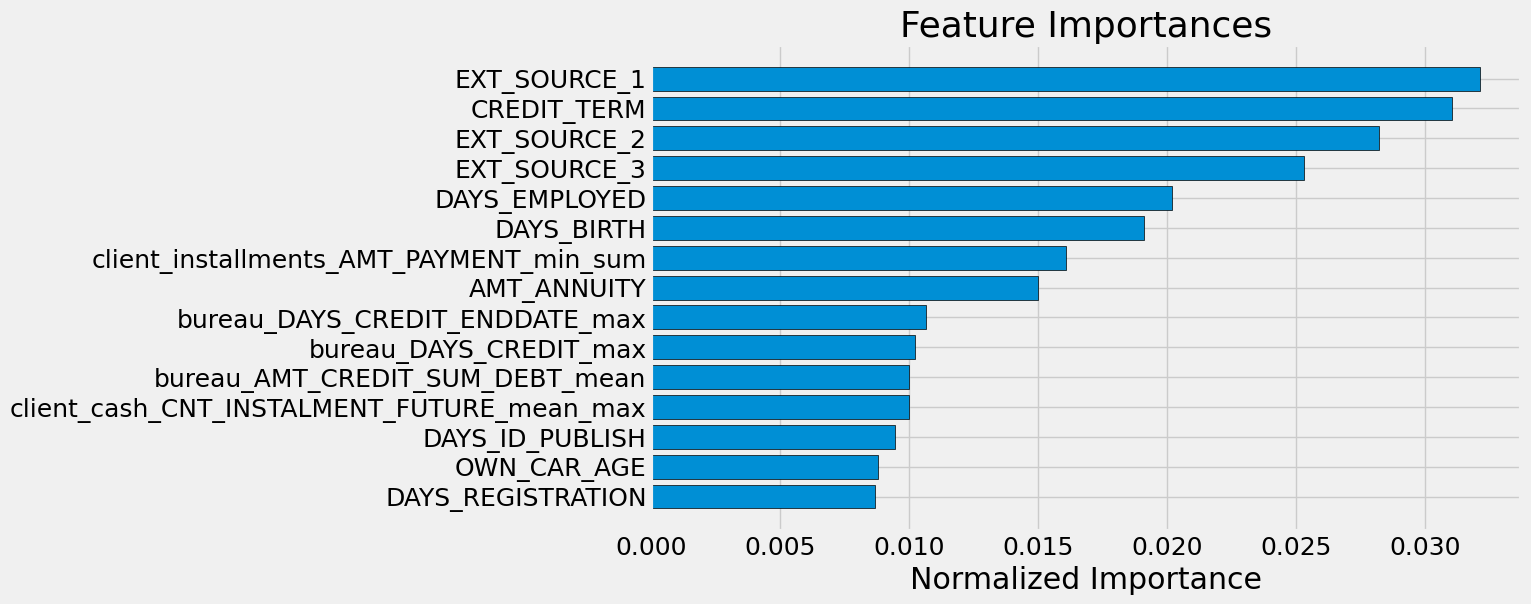

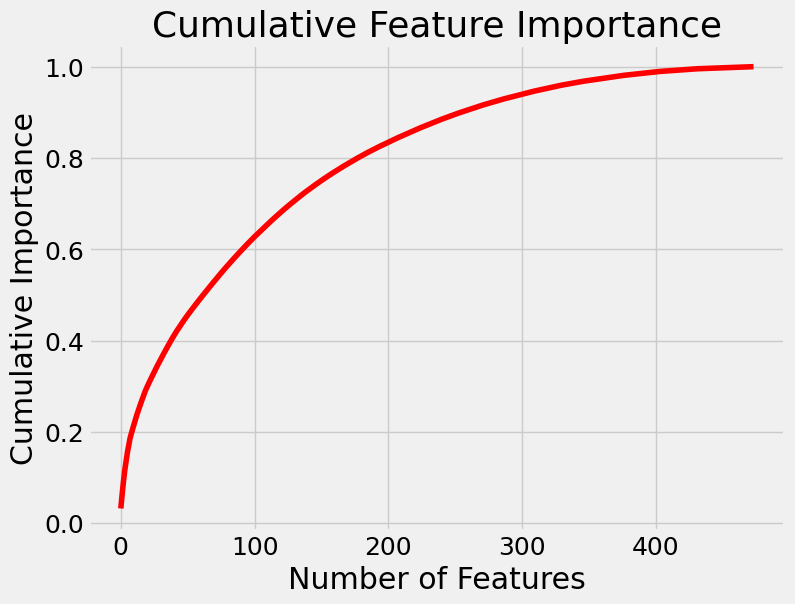

256 features required for 0.90 of cumulative importance


In [215]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [216]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_reduced = df_without_corr_mv_zero_zero[features_to_keep]

In [217]:
train_reduced.head(1)

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                           780.0                  -103.0   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                          49156.2   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                        15.0            -2120          NaN   

   DAYS_REGISTRATION  ANNUITY_INCOME_PERCENT  AMT_CREDIT  \
0            -3648.0                0.121978    406597.5   

   client_installments_AMT_PAYMENT_min_mean  bureau_DAYS_ENDDATE_FACT_max  \
0                                  9251.775                         -36.0   

   client_cash_CNT_INSTALMENT_FUTURE_mean_mean  \
0                                         15.0   

   client_credit_CNT_DRAWINGS_CURRENT_mean_min  previous_CNT_PAYMENT_mean  \
0                                          NaN                       24.0   

   client_cash_CNT_INSTALMENT_FUTURE_min_max  CODE_GENDER_F  \
0                                        6.0          False   

   DAYS_LAST_PHONE_CHANGE  bureau_DAYS_CREDIT_mean  \
0                 -1134.0                   -874.0   

   client_installments_AMT_PAYMENT_min_max  REGION_POPULATION_RELATIVE  \
0                                 9251.775                    0.018801   

   previous_AMT_DOWN_PAYMENT_max  bureau_AMT_CREDIT_MAX_OVERDUE_mean  \
0                            0.0                            1681.029   

   CREDIT_INCOME_PERCENT  bureau_AMT_CREDIT_MAX_OVERDUE_max  \
0               2.007889                           5043.645   

   bureau_AMT_CREDIT_SUM_mean  previous_NAME_CONTRACT_STATUS_Refused_mean  \
0               108131.945625                                         0.0   

   client_installments_AMT_PAYMENT_min_min  bureau_AMT_CREDIT_SUM_sum  \
0                                 9251.775                 865055.565   

   previous_RATE_DOWN_PAYMENT_max  client_installments_AMT_PAYMENT_sum_mean  \
0                             0.0                                  219625.7   

   YEARS_BEGINEXPLUATATION_AVG  bureau_AMT_CREDIT_SUM_max  \
0                       0.9722                   450000.0   

   previous_HOUR_APPR_PROCESS_START_mean  \
0                                    9.0   

   client_cash_CNT_INSTALMENT_FUTURE_mean_min  bureau_DAYS_CREDIT_UPDATE_max  \
0                                        15.0                           -7.0   

   bureau_DAYS_CREDIT_ENDDATE_mean  APARTMENTS_AVG  \
0                           -349.0          0.0247   

   client_installments_NUM_INSTALMENT_VERSION_mean_max  \
0                                           1.052632     

   client_installments_AMT_INSTALMENT_min_mean  \
0                                     9251.775   

   bureau_AMT_CREDIT_SUM_DEBT_max  LANDAREA_AVG  \
0                        245781.0        0.0369   

   client_installments_AMT_INSTALMENT_max_min  \
0                                   53093.746   

   client_installments_NUM_INSTALMENT_VERSION_mean_mean  \
0                                           1.052632      

   client_installments_AMT_PAYMENT_sum_max  CREDIT_ACTIVE_Active_count  \
0                                 219625.7                         2.0   

   previous_RATE_DOWN_PAYMENT_sum  NAME_EDUCATION_TYPE_Higher education  \
0                             0.0                                 False   

   bureau_DAYS_ENDDATE_FACT_mean  previous_DAYS_DECISION_mean  \
0                         -697.5                       -606.0   

   bureau_AMT_CREDIT_SUM_min  client_installments_AMT_INSTALMENT_max_max  \
0                        0.0                                   53093.746   

   previous_NAME_YIELD_GROUP_low_action_mean  bureau_DAYS_CREDIT_sum  \
0                      

In [218]:

print('Training shape: ', train_reduced.shape)

Training shape:  (307511, 315)


In [219]:
train_reduced['TARGET'] = df_labels
train_reduced['SK_ID_CURR'] = df_ids
train_reduced.to_csv('train_reduced.csv', index = False)

In [220]:
train_reduced.head(1)

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                           780.0                  -103.0   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                          49156.2   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                        15.0            -2120          NaN   

   DAYS_REGISTRATION  ANNUITY_INCOME_PERCENT  AMT_CREDIT  \
0            -3648.0                0.121978    406597.5   

   client_installments_AMT_PAYMENT_min_mean  bureau_DAYS_ENDDATE_FACT_max  \
0                                  9251.775                         -36.0   

   client_cash_CNT_INSTALMENT_FUTURE_mean_mean  \
0                                         15.0   

   client_credit_CNT_DRAWINGS_CURRENT_mean_min  previous_CNT_PAYMENT_mean  \
0                                          NaN                       24.0   

   client_cash_CNT_INSTALMENT_FUTURE_min_max  CODE_GENDER_F  \
0                                        6.0          False   

   DAYS_LAST_PHONE_CHANGE  bureau_DAYS_CREDIT_mean  \
0                 -1134.0                   -874.0   

   client_installments_AMT_PAYMENT_min_max  REGION_POPULATION_RELATIVE  \
0                                 9251.775                    0.018801   

   previous_AMT_DOWN_PAYMENT_max  bureau_AMT_CREDIT_MAX_OVERDUE_mean  \
0                            0.0                            1681.029   

   CREDIT_INCOME_PERCENT  bureau_AMT_CREDIT_MAX_OVERDUE_max  \
0               2.007889                           5043.645   

   bureau_AMT_CREDIT_SUM_mean  previous_NAME_CONTRACT_STATUS_Refused_mean  \
0               108131.945625                                         0.0   

   client_installments_AMT_PAYMENT_min_min  bureau_AMT_CREDIT_SUM_sum  \
0                                 9251.775                 865055.565   

   previous_RATE_DOWN_PAYMENT_max  client_installments_AMT_PAYMENT_sum_mean  \
0                             0.0                                  219625.7   

   YEARS_BEGINEXPLUATATION_AVG  bureau_AMT_CREDIT_SUM_max  \
0                       0.9722                   450000.0   

   previous_HOUR_APPR_PROCESS_START_mean  \
0                                    9.0   

   client_cash_CNT_INSTALMENT_FUTURE_mean_min  bureau_DAYS_CREDIT_UPDATE_max  \
0                                        15.0                           -7.0   

   bureau_DAYS_CREDIT_ENDDATE_mean  APARTMENTS_AVG  \
0                           -349.0          0.0247   

   client_installments_NUM_INSTALMENT_VERSION_mean_max  \
0                                           1.052632     

   client_installments_AMT_INSTALMENT_min_mean  \
0                                     9251.775   

   bureau_AMT_CREDIT_SUM_DEBT_max  LANDAREA_AVG  \
0                        245781.0        0.0369   

   client_installments_AMT_INSTALMENT_max_min  \
0                                   53093.746   

   client_installments_NUM_INSTALMENT_VERSION_mean_mean  \
0                                           1.052632      

   client_installments_AMT_PAYMENT_sum_max  CREDIT_ACTIVE_Active_count  \
0                                 219625.7                         2.0   

   previous_RATE_DOWN_PAYMENT_sum  NAME_EDUCATION_TYPE_Higher education  \
0                             0.0                                 False   

   bureau_DAYS_ENDDATE_FACT_mean  previous_DAYS_DECISION_mean  \
0                         -697.5                       -606.0   

   bureau_AMT_CREDIT_SUM_min  client_installments_AMT_INSTALMENT_max_max  \
0                        0.0                                   53093.746   

   previous_NAME_YIELD_GROUP_low_action_mean  bureau_DAYS_CREDIT_sum  \
0                      

# 5 - Nouvelle modélisation LGBM avec features = 95% de l'importance

In [221]:
train_reduced=pd.read_csv('train_reduced.csv')
train_reduced.head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   
1      0.311267     0.027598      0.622246           NaN        -1188.0   
2           NaN     0.050000      0.555912      0.729567         -225.0   
3           NaN     0.094941      0.650442           NaN        -3039.0   
4           NaN     0.042623      0.322738           NaN        -3038.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   
1       16765                               1154108.20      35698.5   
2       19046                                 16071.75       6750.0   
3       19005                                994476.70      29686.5   
4       19932                                483756.38      21865.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                           780.0                  -103.0   
1                          1216.0                  -606.0   
2                          -382.0                  -408.0   
3                             NaN                     NaN   
4                          -783.0                 -1149.0   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                          49156.2   
1                              0.0   
2                              0.0   
3                              NaN   
4                              0.0   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                      15.000            -2120          NaN   
1                                       7.875             -291          NaN   
2                                       2.250            -2531         26.0   
3                                      16.000            -2437          NaN   
4                                      18.500            -3458          NaN   

   DAYS_REGISTRATION  ANNUITY_INCOME_PERCENT  AMT_CREDIT  \
0            -3648.0                0.121978    406597.5   
1            -1186.0                0.132217   1293502.5   
2            -4260.0                0.100000    135000.0   
3            -9833.0                0.219900    312682.5   
4            -4311.0                0.179963    513000.0   

   client_installments_AMT_PAYMENT_min_mean  bureau_DAYS_ENDDATE_FACT_max  \
0                                  9251.775                         -36.0   
1                                 46164.330                        -540.0   
2                                  5357.250                        -382.0   
3                                 62154.793                           NaN   
4                                  7329.642                        -783.0   

   client_cash_CNT_INSTALMENT_FUTURE_mean_mean  \
0                                    15.000000   
1                                     5.785714   
2                                     2.250000   
3                                     8.578231   
4                                     8.969697   

   client_credit_CNT_DRAWINGS_CURRENT_mean_min  previous_CNT_PAYMENT_mean  \
0                                          NaN                  24.000000   
1                                          NaN                  10.000000   
2                                          NaN                   4.000000   
3                                          0.0                  23.000000   
4                                          NaN                  20.666666   

   client_cash_CNT_INSTALMENT_FUTURE_min_max  CODE_GENDER_F  \
0                                        6.0          False   
1                                        1.0           True   
2                                        0.0          False   
3                                        3.0           True   
4                                       13.0          False   

   DAYS_LAST_PHONE_CHANGE  bureau_DAYS_CREDIT_mean  \
0                 -1134.0        

In [222]:
train_reduced_origin=train_reduced.copy()

In [223]:
# extract IDs
id_r = train_reduced['SK_ID_CURR']
        
# Extract the labels for training
y_r = train_reduced['TARGET']
    
# Remove the ids and target
X_r = train_reduced.drop(columns = ['SK_ID_CURR', 'TARGET'])
    

In [224]:
def prepare_modelisation (X,y) :

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a label encoder object
    le = LabelEncoder()
    
    # Iterate through the columns and label encode if object type and nunique <=2
    for col in X_train.columns:
        if X_train[col].dtype == 'object' and len(list(X_train[col].unique())) <= 2:
            # Apply the label encoder to both training and test sets
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.transform(X_test[col])

               
    # one-hot encoding of categorical variables
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    # Assurons-nous que X_train et X_test ont les mêmes colonnes
    X_train, X_test = X_train.align(X_test, join='inner', axis=1)
    
   
    # Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

   
    return X_train, X_test, y_train, y_test

In [225]:
X_train_r, X_test_r, y_train_r, y_test_r=prepare_modelisation (X_r,y_r)

In [226]:
X_train_r.head(1)

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.544382     0.072317      0.419378      0.629055       0.908106   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0    0.894025                                 0.098148     0.057529   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                        0.583347                0.795003   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                         0.025671   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                    0.312084         0.387523     0.340659   

   DAYS_REGISTRATION  ANNUITY_INCOME_PERCENT  AMT_CREDIT  \
0           0.846472                 0.04933    0.127409   

   client_installments_AMT_PAYMENT_min_mean  bureau_DAYS_ENDDATE_FACT_max  \
0                                  0.000988                      0.837548   

   client_cash_CNT_INSTALMENT_FUTURE_mean_mean  \
0                                     0.280154   

   client_credit_CNT_DRAWINGS_CURRENT_mean_min  previous_CNT_PAYMENT_mean  \
0                                      0.00185                   0.321429   

   client_cash_CNT_INSTALMENT_FUTURE_min_max  CODE_GENDER_F  \
0                                       0.05            1.0   

   DAYS_LAST_PHONE_CHANGE  bureau_DAYS_CREDIT_mean  \
0                0.520503                 0.509967   

   client_installments_AMT_PAYMENT_min_max  REGION_POPULATION_RELATIVE  \
0                                  0.00393                    0.491595   

   previous_AMT_DOWN_PAYMENT_max  bureau_AMT_CREDIT_MAX_OVERDUE_mean  \
0                       0.002941                                 0.0   

   CREDIT_INCOME_PERCENT  bureau_AMT_CREDIT_MAX_OVERDUE_max  \
0               0.037564                                0.0   

   bureau_AMT_CREDIT_SUM_mean  previous_NAME_CONTRACT_STATUS_Refused_mean  \
0                    0.001307                                         0.0   

   client_installments_AMT_PAYMENT_min_min  bureau_AMT_CREDIT_SUM_sum  \
0                                  0.00004                   0.001462   

   previous_RATE_DOWN_PAYMENT_max  client_installments_AMT_PAYMENT_sum_mean  \
0                        0.123131                                  0.027018   

   YEARS_BEGINEXPLUATATION_AVG  bureau_AMT_CREDIT_SUM_max  \
0                       0.9821                   0.002646   

   previous_HOUR_APPR_PROCESS_START_mean  \
0                               0.509317   

   client_cash_CNT_INSTALMENT_FUTURE_mean_min  bureau_DAYS_CREDIT_UPDATE_max  \
0                                         0.0                       0.990914   

   bureau_DAYS_CREDIT_ENDDATE_mean  APARTMENTS_AVG  \
0                         0.567007          0.0876   

   client_installments_NUM_INSTALMENT_VERSION_mean_max  \
0                                           0.013035     

   client_installments_AMT_INSTALMENT_min_mean  \
0                                     0.001815   

   bureau_AMT_CREDIT_SUM_DEBT_max  LANDAREA_AVG  \
0                        0.001591        0.0483   

   client_installments_AMT_INSTALMENT_max_min  \
0                                    0.000816   

   client_installments_NUM_INSTALMENT_VERSION_mean_mean  \
0                                           0.015706      

   client_installments_AMT_PAYMENT_sum_max  CREDIT_ACTIVE_Active_count  \
0                                 0.033286                       0.125   

   previous_RATE_DOWN_PAYMENT_sum  NAME_EDUCATION_TYPE_Higher education  \
0                        0.080593                                   0.0   

   bureau_DAYS_ENDDATE_FACT_mean  previous_DAYS_DECISION_mean  \
0                       0.860115                     0.403474   

   bureau_AMT_CREDIT_SUM_min  client_installments_AMT_INSTALMENT_max_max  \
0                        0.0                                    0.046405   

   previous_NAME_YIELD_GROUP_low_action_mean  bureau_DAYS_CREDIT_sum  \
0                      

In [227]:
X_train_r.shape, X_test_r.shape, y_train_r.shape, y_test_r.shape

((246008, 315), (61503, 315), (246008,), (61503,))

In [228]:
model_LGBM_2 = lgb.LGBMClassifier(objective='binary',
                                boosting_type = 'goss',
                                class_weight = 'balanced',
                                random_state = 50)
        
param_grid_LGBM_2 = {
    # 'num_leaves': [20,25],
    'n_estimators' : [100,1000],   
    'learning_rate' : [0.01,0.1]
}

# Paramètres pour early_stopping
fit_params = {
    'early_stopping_rounds': 50,
    'eval_metric': 'auc',
    'eval_set': [(X_test_r, y_test_r)] 
}

In [229]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM_2 = run_grid_search(X_train_r, y_train_r, model_LGBM_2, param_grid_LGBM_2,fit_params, train_size=0.5)

end_training_time = time.time()

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 56580, number of negative: 56580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80154
[LightGBM] [Info] Number of data points in the train set: 113160, number of used features: 315
[LightGB

In [230]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 1206.2 secondes.


In [231]:
best_model_lgbm_2 = results_LGBM_2['best_model']
best_params_lgbm_2 = results_LGBM_2['best_params_']
best_score_lgbm_2 = results_LGBM_2['best_score_']
cv_results_lgbm_2 = results_LGBM_2['cv_results_']

print("Best Params:", best_params_lgbm_2)
print("Best AUC:", best_score_lgbm_2)

Best Params: {'model__learning_rate': 0.01, 'model__n_estimators': 1000}
Best AUC: 0.7653182038589522


In [232]:
best_auc_result_LGBM_2 = extract_best_auc_result(results_LGBM_2)
best_auc_result_LGBM_2.head(1)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1     171.795182      0.111938        14.407504        0.274419   

   param_model__learning_rate  param_model__n_estimators  \
1                        0.01                       1000   

                                              params  split0_test_AUC  \
1  {'model__learning_rate': 0.01, 'model__n_estim...         0.763079   

   split1_test_AUC  mean_test_AUC  std_test_AUC  rank_test_AUC  \
1         0.767557       0.765318      0.002239              1   

   split0_train_AUC  split1_train_AUC  mean_train_AUC  std_train_AUC  \
1          0.861887          0.861924        0.861905       0.000018   

   split0_test_F1_opt  split1_test_F1_opt  mean_test_F1_opt  std_test_F1_opt  \
1            0.281236            0.275726          0.278481         0.002755   

   rank_test_F1_opt  split0_train_F1_opt  split1_train_F1_opt  \
1                 1             0.368632             0.365766   

   mean_train_F1_opt  std_train_F1_opt  split0_test_recall_opt  \
1           0.367199          0.001433                0.638082   

   split1_test_recall_opt  mean_test_recall_opt  std_test_recall_opt  \
1                0.693824              0.665953             0.027871   

   rank_test_recall_opt  split0_train_recall_opt  split1_train_recall_opt  \
1                     1                 0.767371                 0.764682   

   mean_train_recall_opt  std_train_recall_opt  
1               0.766026              0.001345

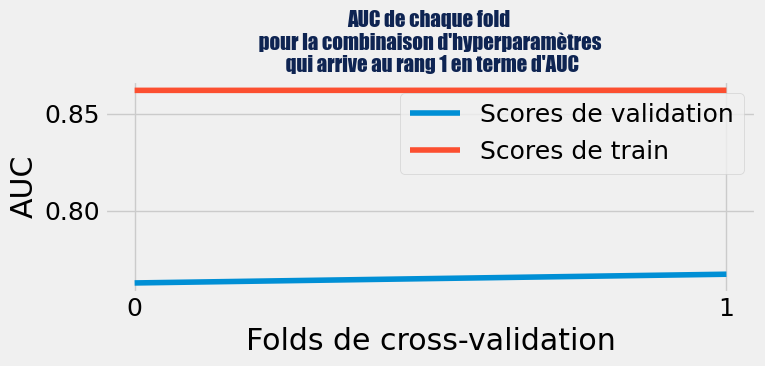

In [233]:
plot_auc_scores(best_auc_result_LGBM_2)

In [234]:
result_lgbm_2=evaluate_model (X_train_r, y_train_r, X_test_r, y_test_r, best_model_lgbm_2)
result_lgbm_2

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 37.92,
 'auc_train': 0.79,
 'auc_test': 0.76,
 'optimal_threshold': 0.1,
 'f1_score_1_test': 0.27,
 'recall_1_test': 0.68,
 'accuracy_test': 0.71}

In [235]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_lgbm_2)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_lgbm_2['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_lgbm_2['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_lgbm_2['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_lgbm_2['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_lgbm_2['auc_train'])
#     mlflow.log_metric("auc_test", result_lgbm_2['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_lgbm_2['predicting_execution_time'])

    
 
    

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "LGBM with 303 features")

#     # Infer the model signature
#     signature = infer_signature(X_train, best_model_lgbm_2.predict(X_train)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_lgbm_2, # le modèle
#         artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=X_train, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


# 6 - Nouvelle réduction drastique de features 

Plusieurs essais avec 10 -50 - 100 features

In [236]:
to_keep=feature_importances.iloc[:15]
features_to_keep_2=to_keep['feature'].tolist()
features_to_keep_2

['EXT_SOURCE_1',
 'CREDIT_TERM',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'client_installments_AMT_PAYMENT_min_sum',
 'AMT_ANNUITY',
 'bureau_DAYS_CREDIT_ENDDATE_max',
 'bureau_DAYS_CREDIT_max',
 'bureau_AMT_CREDIT_SUM_DEBT_mean',
 'client_cash_CNT_INSTALMENT_FUTURE_mean_max',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'DAYS_REGISTRATION']

In [237]:
# Create new datasets with smaller features
train_small = df_without_corr_mv_zero_zero[features_to_keep_2]

In [238]:
train_small.head(1)

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                           780.0                  -103.0   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                          49156.2   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                        15.0            -2120          NaN   

   DAYS_REGISTRATION  
0            -3648.0

In [239]:
print('Training shape: ', train_small.shape)


Training shape:  (307511, 15)


In [240]:
train_small['TARGET'] = df_labels
train_small['SK_ID_CURR'] = df_ids


In [241]:
train_small.to_csv('train_small.csv', index = False)

In [242]:
train_small.head(1)

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                           780.0                  -103.0   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                          49156.2   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                        15.0            -2120          NaN   

   DAYS_REGISTRATION  TARGET  SK_ID_CURR  
0            -3648.0       1      100002

# 7 - Nouvelle modélisation LGBM avec short selection de features

In [243]:
train_small=pd.read_csv('train_small.csv')
train_small.head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   
1      0.311267     0.027598      0.622246           NaN        -1188.0   
2           NaN     0.050000      0.555912      0.729567         -225.0   
3           NaN     0.094941      0.650442           NaN        -3039.0   
4           NaN     0.042623      0.322738           NaN        -3038.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   
1       16765                               1154108.20      35698.5   
2       19046                                 16071.75       6750.0   
3       19005                                994476.70      29686.5   
4       19932                                483756.38      21865.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                           780.0                  -103.0   
1                          1216.0                  -606.0   
2                          -382.0                  -408.0   
3                             NaN                     NaN   
4                          -783.0                 -1149.0   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                          49156.2   
1                              0.0   
2                              0.0   
3                              NaN   
4                              0.0   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                      15.000            -2120          NaN   
1                                       7.875             -291          NaN   
2                                       2.250            -2531         26.0   
3                                      16.000            -2437          NaN   
4                                      18.500            -3458          NaN   

   DAYS_REGISTRATION  TARGET  SK_ID_CURR  
0            -3648.0       1      100002  
1            -1186.0       0      100003  
2            -4260.0       0      100004  
3            -9833.0       0      100006  
4            -4311.0       0      100007

In [244]:
# extract IDs
id_s = train_small['SK_ID_CURR']
        
# Extract the labels for training
y_s = train_small['TARGET']
    
# Remove the ids and target
X_s = train_small.drop(columns = ['SK_ID_CURR', 'TARGET'])
    

In [245]:
X_s.head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.083037     0.060749      0.262949      0.139376         -637.0   
1      0.311267     0.027598      0.622246           NaN        -1188.0   
2           NaN     0.050000      0.555912      0.729567         -225.0   
3           NaN     0.094941      0.650442           NaN        -3039.0   
4           NaN     0.042623      0.322738           NaN        -3038.0   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0        9461                                175783.73      24700.5   
1       16765                               1154108.20      35698.5   
2       19046                                 16071.75       6750.0   
3       19005                                994476.70      29686.5   
4       19932                                483756.38      21865.5   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                           780.0                  -103.0   
1                          1216.0                  -606.0   
2                          -382.0                  -408.0   
3                             NaN                     NaN   
4                          -783.0                 -1149.0   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                          49156.2   
1                              0.0   
2                              0.0   
3                              NaN   
4                              0.0   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                      15.000            -2120          NaN   
1                                       7.875             -291          NaN   
2                                       2.250            -2531         26.0   
3                                      16.000            -2437          NaN   
4                                      18.500            -3458          NaN   

   DAYS_REGISTRATION  
0            -3648.0  
1            -1186.0  
2            -4260.0  
3            -9833.0  
4            -4311.0

In [246]:
X_train_s, X_test_s, y_train_s, y_test_s=prepare_modelisation (X_s,y_s)

In [247]:
X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape

((246008, 15), (61503, 15), (246008,), (61503,))

In [248]:
model_LGBM_3 = lgb.LGBMClassifier(objective='binary',
                                boosting_type = 'goss',
                                class_weight = 'balanced',
                                random_state = 50)
        
param_grid_LGBM_3 = {
    # 'num_leaves': [20,30],
    'learning_rate' : [0.01,0.1], 
    'n_estimators': [100,1000],
    # 'reg_alpha' : [0.1], 
    # 'reg_lambda' : [0.1]

}

# Paramètres pour early_stopping
fit_params = {
    'early_stopping_rounds': 50,
    'eval_metric': 'auc',
    'eval_set': [(X_test_s, y_test_s)] 
}


In [249]:
# Execution de la fonction
start_training_time = time.time()

results_LGBM_3 = run_grid_search(X_train_s, y_train_s, model_LGBM_3, param_grid_LGBM_3,fit_params)

end_training_time = time.time()


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 113066, number of negative: 113066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3821
[LightGBM] [Info] Number of data points in the train set: 226132, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found boosting=goss. Fo

In [250]:
training_execution_time = round(end_training_time - start_training_time,2)  
print(f"Le temps d'exécution est de {training_execution_time} secondes.")

Le temps d'exécution est de 635.49 secondes.


In [251]:
best_model_lgbm_3 = results_LGBM_3['best_model']
best_params_lgbm_3 = results_LGBM_3['best_params_']
best_score_lgbm_3 = results_LGBM_3['best_score_']
cv_results_lgbm_3 = results_LGBM_3['cv_results_']

print("Best Params:", best_params_lgbm_3)
print("Best AUC:", best_score_lgbm_3)


Best Params: {'model__learning_rate': 0.01, 'model__n_estimators': 1000}
Best AUC: 0.7024818187410024


In [252]:
best_auc_result_LGBM_3 = extract_best_auc_result(results_LGBM_3)
best_auc_result_LGBM_3.head(1)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      49.996967      0.043052        29.253392        0.180104   

   param_model__learning_rate  param_model__n_estimators  \
1                        0.01                       1000   

                                              params  split0_test_AUC  \
1  {'model__learning_rate': 0.01, 'model__n_estim...         0.702781   

   split1_test_AUC  mean_test_AUC  std_test_AUC  rank_test_AUC  \
1         0.702183       0.702482      0.000299              1   

   split0_train_AUC  split1_train_AUC  mean_train_AUC  std_train_AUC  \
1          0.723558          0.721966        0.722762       0.000796   

   split0_test_F1_opt  split1_test_F1_opt  mean_test_F1_opt  std_test_F1_opt  \
1            0.234154            0.236533          0.235343          0.00119   

   rank_test_F1_opt  split0_train_F1_opt  split1_train_F1_opt  \
1                 3             0.247866             0.250541   

   mean_train_F1_opt  std_train_F1_opt  split0_test_recall_opt  \
1           0.249204          0.001338                0.617428   

   split1_test_recall_opt  mean_test_recall_opt  std_test_recall_opt  \
1                0.610183              0.613806             0.003622   

   rank_test_recall_opt  split0_train_recall_opt  split1_train_recall_opt  \
1                     1                  0.65164                 0.605253   

   mean_train_recall_opt  std_train_recall_opt  
1               0.628446              0.023194

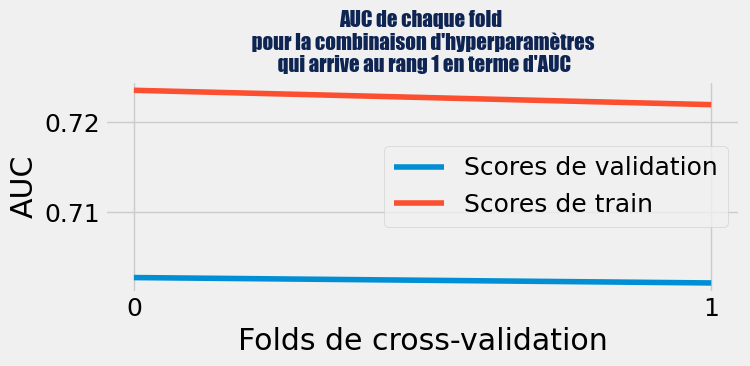

In [253]:
plot_auc_scores(best_auc_result_LGBM_3)

In [254]:
result_lgbm_3=evaluate_model (X_train_s, y_train_s, X_test_s, y_test_s, best_model_lgbm_3)
result_lgbm_3


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


{'predicting_execution_time': 36.75,
 'auc_train': 0.71,
 'auc_test': 0.7,
 'optimal_threshold': 0.32,
 'f1_score_1_test': 0.24,
 'recall_1_test': 0.54,
 'accuracy_test': 0.73}

In [255]:
# # Création d'une nouvelle expérience MLflow
# mlflow.set_experiment("MLflow Credit_Scoring - Projet_7")

# # Commencer une session MLflow
# with mlflow.start_run():
#     # Log les hyperparameters que j'ai déclarés au dessus
#     mlflow.log_params(best_params_lgbm_3)

#     # Log les métriques
    
#     mlflow.log_metric("optimal_threshold", result_lgbm_3['optimal_threshold'])

#     mlflow.log_metric("recall_1_test", result_lgbm_3['recall_1_test'])
#     mlflow.log_metric("f1_score_1_test", result_lgbm_3['f1_score_1_test'])
#     mlflow.log_metric("accuracy du test", result_lgbm_3['accuracy_test'])
    
#     mlflow.log_metric("auc_train", result_lgbm_3['auc_train'])
#     mlflow.log_metric("auc_test", result_lgbm_3['auc_test'])
    
#     mlflow.log_metric("temps_fit", training_execution_time)
#     mlflow.log_metric("temps_predict", result_lgbm_3['predicting_execution_time'])

      

#     # Définir un tag pour se rappeler l'objet de cette session
#     mlflow.set_tag("Training Info", "LGBM with 100 features")

#     # Infer the model signature
#     signature = infer_signature(X_train, best_model_lgbm_3.predict(X_train)) # infer_signature génère automatiquement une "signature" 
#                                                               # qui décrit les entrées et les sorties du modèle. 
#                                                               # Cela inclut les types de données et les formats attendus par le modèle, 
#                                                               # facilitant ainsi l'intégration et la réutilisation du modèle 
#                                                               # dans différents environnements.

    
#     # Log le model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=best_model_lgbm_3, # le modèle
#         artifact_path="lgbm_classifier_model", # le chemin où le modèle sera enregistré
#         signature=signature, # la signature du modèle
#         input_example=X_train, # un exemple d'input pour montrer comment invoquer le modèle
#         registered_model_name="scoring-credit-lgbm_classifier", # nom sous lequel le modèle est enregistré dans le registre de modèles MLflow
#     )


# 8 - Interprétation des résultats

Je repars du modeèle sur les features qui représentent 95% de la feature importance cumulée pq c'est le modèle qui remonte la meilleue AUC

## 8.1 - Feature Importance

In [256]:
importances = best_model_lgbm_2.named_steps['model'].feature_importances_
features= X_train_r.columns

In [257]:
importances

array([ 431,  554, 1006,  869,  253,  290,  494,  223,  168,  107,  149,
        212,  196,  198,   73,  136,  273,   75,  115,   86,   60,   50,
        121,  212,  103,   51,   46,  216,   89,  145,   67,   70,   53,
        162,   98,   20,  146,   29,   34,   40,   17,   76,  160,   37,
         22,  164,   21,  100,  122,   12,   37,   34, 1108,   73,  151,
         28,   25,  152,   19,   14,   49,   42,   16,   66,  453,   14,
          9,   35,  166,   59,   48,  108,  128,  165,   22,   90,  409,
         49,   57,   13,   52,   41,   14,   27,   38,   41,   24,   56,
         58,   31,   25,  502,   45,  221,   19,   77,   68,   27,   16,
         13,   18,  142,   65,   24,  107,   16,   40,   41,   25,  149,
         19,   89,   89,   32,   30,   18,   20,   41,   36,   65,  299,
         52,   77,  401,   24,  143,   19,   46,   32,    6,   24,   23,
         17,   34,   34,   34,  117,  229,   22,  210,    6,   25,   11,
         20,    8,   61,   20,   26,   39,   58,   

In [258]:
X_train_r.head(1)

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.544382     0.072317      0.419378      0.629055       0.908106   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0    0.894025                                 0.098148     0.057529   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                        0.583347                0.795003   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                         0.025671   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                    0.312084         0.387523     0.340659   

   DAYS_REGISTRATION  ANNUITY_INCOME_PERCENT  AMT_CREDIT  \
0           0.846472                 0.04933    0.127409   

   client_installments_AMT_PAYMENT_min_mean  bureau_DAYS_ENDDATE_FACT_max  \
0                                  0.000988                      0.837548   

   client_cash_CNT_INSTALMENT_FUTURE_mean_mean  \
0                                     0.280154   

   client_credit_CNT_DRAWINGS_CURRENT_mean_min  previous_CNT_PAYMENT_mean  \
0                                      0.00185                   0.321429   

   client_cash_CNT_INSTALMENT_FUTURE_min_max  CODE_GENDER_F  \
0                                       0.05            1.0   

   DAYS_LAST_PHONE_CHANGE  bureau_DAYS_CREDIT_mean  \
0                0.520503                 0.509967   

   client_installments_AMT_PAYMENT_min_max  REGION_POPULATION_RELATIVE  \
0                                  0.00393                    0.491595   

   previous_AMT_DOWN_PAYMENT_max  bureau_AMT_CREDIT_MAX_OVERDUE_mean  \
0                       0.002941                                 0.0   

   CREDIT_INCOME_PERCENT  bureau_AMT_CREDIT_MAX_OVERDUE_max  \
0               0.037564                                0.0   

   bureau_AMT_CREDIT_SUM_mean  previous_NAME_CONTRACT_STATUS_Refused_mean  \
0                    0.001307                                         0.0   

   client_installments_AMT_PAYMENT_min_min  bureau_AMT_CREDIT_SUM_sum  \
0                                  0.00004                   0.001462   

   previous_RATE_DOWN_PAYMENT_max  client_installments_AMT_PAYMENT_sum_mean  \
0                        0.123131                                  0.027018   

   YEARS_BEGINEXPLUATATION_AVG  bureau_AMT_CREDIT_SUM_max  \
0                       0.9821                   0.002646   

   previous_HOUR_APPR_PROCESS_START_mean  \
0                               0.509317   

   client_cash_CNT_INSTALMENT_FUTURE_mean_min  bureau_DAYS_CREDIT_UPDATE_max  \
0                                         0.0                       0.990914   

   bureau_DAYS_CREDIT_ENDDATE_mean  APARTMENTS_AVG  \
0                         0.567007          0.0876   

   client_installments_NUM_INSTALMENT_VERSION_mean_max  \
0                                           0.013035     

   client_installments_AMT_INSTALMENT_min_mean  \
0                                     0.001815   

   bureau_AMT_CREDIT_SUM_DEBT_max  LANDAREA_AVG  \
0                        0.001591        0.0483   

   client_installments_AMT_INSTALMENT_max_min  \
0                                    0.000816   

   client_installments_NUM_INSTALMENT_VERSION_mean_mean  \
0                                           0.015706      

   client_installments_AMT_PAYMENT_sum_max  CREDIT_ACTIVE_Active_count  \
0                                 0.033286                       0.125   

   previous_RATE_DOWN_PAYMENT_sum  NAME_EDUCATION_TYPE_Higher education  \
0                        0.080593                                   0.0   

   bureau_DAYS_ENDDATE_FACT_mean  previous_DAYS_DECISION_mean  \
0                       0.860115                     0.403474   

   bureau_AMT_CREDIT_SUM_min  client_installments_AMT_INSTALMENT_max_max  \
0                        0.0                                    0.046405   

   previous_NAME_YIELD_GROUP_low_action_mean  bureau_DAYS_CREDIT_sum  \
0                      

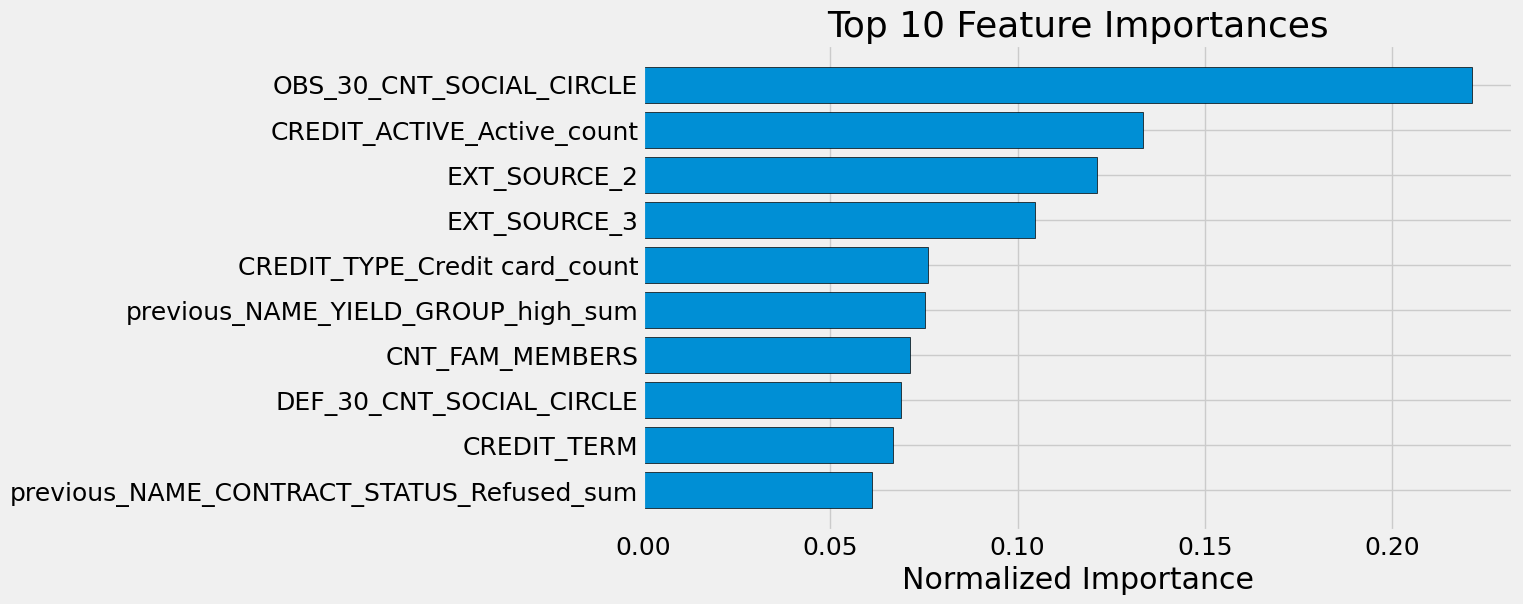

feature  importance  \
0                   OBS_30_CNT_SOCIAL_CIRCLE        1835   
1                 CREDIT_ACTIVE_Active_count        1108   
2                               EXT_SOURCE_2        1006   
3                               EXT_SOURCE_3         869   
4              CREDIT_TYPE_Credit card_count         630   
5         previous_NAME_YIELD_GROUP_high_sum         624   
6                            CNT_FAM_MEMBERS         592   
7                   DEF_30_CNT_SOCIAL_CIRCLE         571   
8                                CREDIT_TERM         554   
9  previous_NAME_CONTRACT_STATUS_Refused_sum         506   

   importance_normalized  
0               0.221218  
1               0.133574  
2               0.121278  
3               0.104762  
4               0.075949  
5               0.075226  
6               0.071368  
7               0.068837  
8               0.066787  
9               0.061001

In [259]:
show_feature_importances(importances, features)

## 8.2 - Shap Values

### 8.2.1 - Interprétation globale

In [260]:
# Création de l'explainer SHAP pour le modèle LightGBM
best_model_explainer = shap.TreeExplainer(best_model_lgbm_2.named_steps['model'])

In [261]:
# Calcul des valeurs SHAP pour les données test
shap_values = best_model_explainer.shap_values(X_test_r)

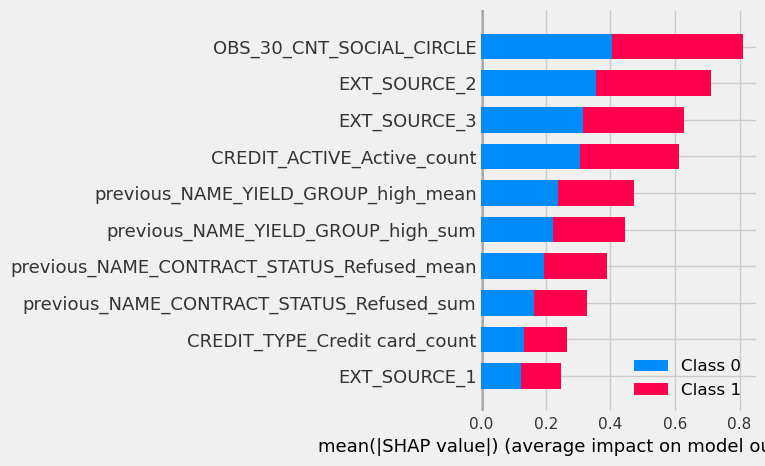

In [262]:
shap.summary_plot(best_model_explainer.shap_values(X_test_r),
                  features = X_test_r,
                  plot_type="bar",
                  feature_names=features,
                   max_display=10,
                   plot_size=(8, 5))

Si on regarde ce qui se passe pour la classe 1 :

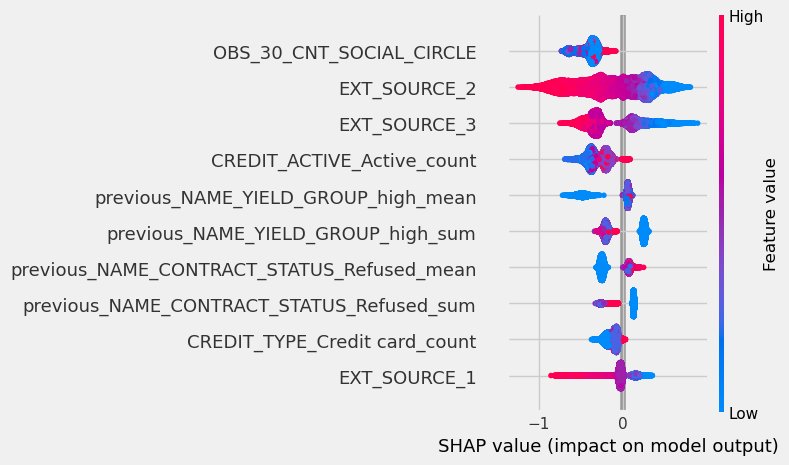

In [263]:
shap.summary_plot(best_model_explainer.shap_values(X_test_r)[1],
                  features = X_test_r,
                  feature_names=features,
                   max_display=10,
                   plot_size=(8, 5))

### 8.2.2 - Interprétation locale

In [264]:
X_test_r.head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.705732     0.889266      0.707479      0.000000       0.957459   
1      0.444220     0.157447      0.497486      0.794687       0.936300   
2      0.547108     0.556254      0.621942      0.231648       0.964326   
3      0.524898     0.740962      0.811136      0.685538       0.610205   
4      0.683325     0.287297      0.655778      0.710063       0.938310   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0    0.327396                                 0.004421     0.199000   
1    0.410879                                 0.197013     0.184591   
2    0.587260                                 0.011368     0.146227   
3    0.684160                                 0.000034     0.090962   
4    0.723675                                 0.014431     0.055563   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                        0.576120                0.955852   
1                        0.702708                0.899042   
2                        0.589233                0.863450   
3                        0.545527                0.252225   
4                        0.594982                0.925736   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                         0.025108   
1                         0.024224   
2                         0.029556   
3                         0.024224   
4                         0.027856   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                    0.073171         0.401556     0.208791   
1                                    0.093496         0.368348     0.120879   
2                                    0.060976         0.796999     0.043956   
3                                    0.038049         0.561206     0.098901   
4                                    0.100610         0.931360     0.098901   

   DAYS_REGISTRATION  ANNUITY_INCOME_PERCENT  AMT_CREDIT  \
0           0.972796                0.134020    0.104983   
1           0.931244                0.103827    0.308792   
2           0.892936                0.101355    0.112360   
3           0.523104                0.052029    0.052360   
4           0.688290                0.073515    0.065701   

   client_installments_AMT_PAYMENT_min_mean  bureau_DAYS_ENDDATE_FACT_max  \
0                                  0.000416                      0.922064   
1                                  0.007675                      0.981988   
2                                  0.001632                      0.863526   
3                                  0.000007                      0.572567   
4                                  0.001357                      0.759958   

   client_cash_CNT_INSTALMENT_FUTURE_mean_mean  \
0                                     0.096377   
1                                     0.073864   
2                                     0.075397   
3                                     0.052000   
4                                     0.094872   

   client_credit_CNT_DRAWINGS_CURRENT_mean_min  previous_CNT_PAYMENT_mean  \
0                                     0.001780                   0.077778   
1                                     0.010923                   0.137731   
2                                     0.001780                   0.194444   
3                                     0.001780                   0.166667   
4                                     0.000000                   0.104167   

   client_cash_CNT_INSTALMENT_FUTURE_min_max  CODE_GENDER_F  \
0                                     0.0125            0.0   
1                                     0.0125            1.0   
2                                     0.0000            1.0   
3                                     0.0000            1.0   
4                                     0.0000            0.0   

   DAYS_LAST_PHONE_CHANGE  bureau_DAYS_CREDIT_mean  \
0                0.999534        

In [265]:
recontruct=X_test_r

In [266]:
y_test_pred_proba = best_model_lgbm_2.predict_proba(X_test_r)[:, 1]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [267]:
y_test_series = pd.Series(y_test_r)
y_test_proba_series = pd.Series(y_test_pred_proba)

In [268]:
recontruct['target']=y_test_series.values
recontruct['proba']=y_test_proba_series.values
recontruct.head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
0      0.705732     0.889266      0.707479      0.000000       0.957459   
1      0.444220     0.157447      0.497486      0.794687       0.936300   
2      0.547108     0.556254      0.621942      0.231648       0.964326   
3      0.524898     0.740962      0.811136      0.685538       0.610205   
4      0.683325     0.287297      0.655778      0.710063       0.938310   

   DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
0    0.327396                                 0.004421     0.199000   
1    0.410879                                 0.197013     0.184591   
2    0.587260                                 0.011368     0.146227   
3    0.684160                                 0.000034     0.090962   
4    0.723675                                 0.014431     0.055563   

   bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
0                        0.576120                0.955852   
1                        0.702708                0.899042   
2                        0.589233                0.863450   
3                        0.545527                0.252225   
4                        0.594982                0.925736   

   bureau_AMT_CREDIT_SUM_DEBT_mean  \
0                         0.025108   
1                         0.024224   
2                         0.029556   
3                         0.024224   
4                         0.027856   

   client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0                                    0.073171         0.401556     0.208791   
1                                    0.093496         0.368348     0.120879   
2                                    0.060976         0.796999     0.043956   
3                                    0.038049         0.561206     0.098901   
4                                    0.100610         0.931360     0.098901   

   DAYS_REGISTRATION  ANNUITY_INCOME_PERCENT  AMT_CREDIT  \
0           0.972796                0.134020    0.104983   
1           0.931244                0.103827    0.308792   
2           0.892936                0.101355    0.112360   
3           0.523104                0.052029    0.052360   
4           0.688290                0.073515    0.065701   

   client_installments_AMT_PAYMENT_min_mean  bureau_DAYS_ENDDATE_FACT_max  \
0                                  0.000416                      0.922064   
1                                  0.007675                      0.981988   
2                                  0.001632                      0.863526   
3                                  0.000007                      0.572567   
4                                  0.001357                      0.759958   

   client_cash_CNT_INSTALMENT_FUTURE_mean_mean  \
0                                     0.096377   
1                                     0.073864   
2                                     0.075397   
3                                     0.052000   
4                                     0.094872   

   client_credit_CNT_DRAWINGS_CURRENT_mean_min  previous_CNT_PAYMENT_mean  \
0                                     0.001780                   0.077778   
1                                     0.010923                   0.137731   
2                                     0.001780                   0.194444   
3                                     0.001780                   0.166667   
4                                     0.000000                   0.104167   

   client_cash_CNT_INSTALMENT_FUTURE_min_max  CODE_GENDER_F  \
0                                     0.0125            0.0   
1                                     0.0125            1.0   
2                                     0.0000            1.0   
3                                     0.0000            1.0   
4                                     0.0000            0.0   

   DAYS_LAST_PHONE_CHANGE  bureau_DAYS_CREDIT_mean  \
0                0.999534        

In [269]:
recontruct['target'].value_counts()

target
0    56554
1     4949
Name: count, dtype: int64

In [270]:
recontruct[recontruct['target']==1].head()

EXT_SOURCE_1  CREDIT_TERM  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_EMPLOYED  \
10      0.353393     0.287016      0.482730      0.713783       0.984368   
11      0.524898     0.265223      0.529907      0.270982       0.954835   
24      0.327077     0.263208      0.478755      0.400258       0.956565   
26      0.329541     0.284427      0.421516      0.599166       0.953662   
40      0.524898     0.556096      0.839730      0.788042       0.961143   

    DAYS_BIRTH  client_installments_AMT_PAYMENT_min_sum  AMT_ANNUITY  \
10    0.326437                                 0.019272     0.060302   
11    0.053495                                 0.018286     0.036890   
24    0.366291                                 0.006520     0.058547   
26    0.188670                                 0.007788     0.198263   
40    0.189290                                 0.011328     0.072166   

    bureau_DAYS_CREDIT_ENDDATE_max  bureau_DAYS_CREDIT_max  \
10                        0.587344                0.734771   
11                        0.948943                0.923682   
24                        0.669911                0.924025   
26                        0.585400                0.896988   
40                        0.569960                0.800137   

    bureau_AMT_CREDIT_SUM_DEBT_mean  \
10                         0.025290   
11                         0.024785   
24                         0.254746   
26                         0.025212   
40                         0.024224   

    client_cash_CNT_INSTALMENT_FUTURE_mean_max  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
10                                    0.070122         0.321940     0.098901   
11                                    0.102439         0.883563     0.021978   
24                                    0.475610         0.512297     0.098901   
26                                    0.090592         0.947200     0.021978   
40                                    0.182927         0.614701     0.098901   

    DAYS_REGISTRATION  ANNUITY_INCOME_PERCENT  AMT_CREDIT  \
10           0.851768                0.133324    0.071640   
11           0.861975                0.042026    0.044944   
24           0.991331                0.077146    0.073469   
26           0.739836                0.413180    0.244629   
40           0.970661                0.147442    0.052360   

    client_installments_AMT_PAYMENT_min_mean  bureau_DAYS_ENDDATE_FACT_max  \
10                                  0.006569                      0.896086   
11                                  0.001719                      0.880499   
24                                  0.000711                      0.880499   
26                                  0.001634                      0.880499   
40                                  0.003089                      0.924143   

    client_cash_CNT_INSTALMENT_FUTURE_mean_mean  \
10                                     0.066667   
11                                     0.095513   
24                                     0.374053   
26                                     0.123810   
40                                     0.181818   

    client_credit_CNT_DRAWINGS_CURRENT_mean_min  previous_CNT_PAYMENT_mean  \
10                                      0.00178                   0.129630   
11                                      0.00178                   0.104167   
24                                      0.00178                   0.500000   
26                                      0.00178                   0.194444   
40                                      0.00178                   0.208333   

    client_cash_CNT_INSTALMENT_FUTURE_min_max  CODE_GENDER_F  \
10                                       0.00            1.0   
11                                       0.05            0.0   
24                                       0.00            1.0   
26                                       0.00            1.0   
40                                       0.15            1.0   

    DAYS_LAST_PHONE_CHANGE  

In [271]:
# Choix de l'indice de l'individu à expliquer, par exemple le premier individu
index_to_explain = 0

# Création de l'objet Explanation pour l'individu spécifique en classe 1 
individual_shap_values_1 = shap.Explanation(
    values=shap_values[1][index_to_explain],  # Les valeurs SHAP pour la classe positive
    base_values=best_model_explainer.expected_value[1],  # La valeur de base pour la classe positive
    data=X_test_r.iloc[index_to_explain]         # Les valeurs des caractéristiques de l'individu
)

# Création de l'objet Explanation pour l'individu spécifique en classe 0
individual_shap_values_0 = shap.Explanation(
    values=shap_values[0][index_to_explain],  # Les valeurs SHAP pour la classe négative
    base_values=best_model_explainer.expected_value[0],  # La valeur de base pour la classe positive
    data=X_test_r.iloc[index_to_explain]         # Les valeurs des caractéristiques de l'individu
)


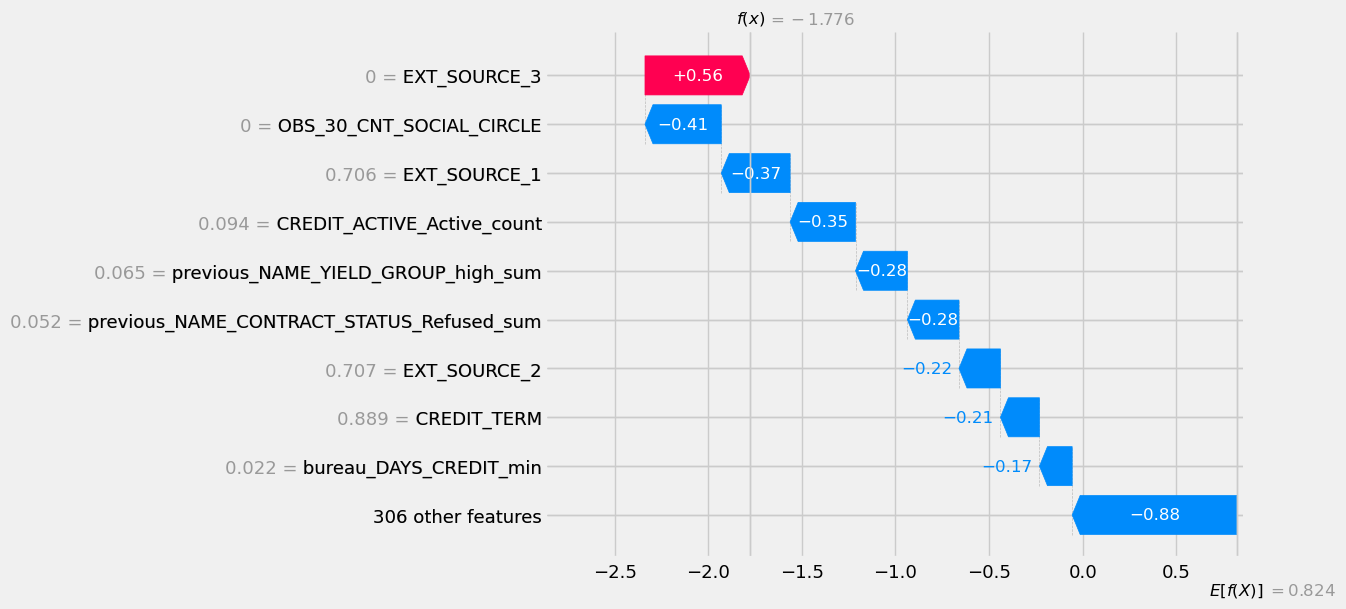

In [272]:
# Afficher le Waterfall Plot pour cet individu
shap.waterfall_plot(individual_shap_values_1)

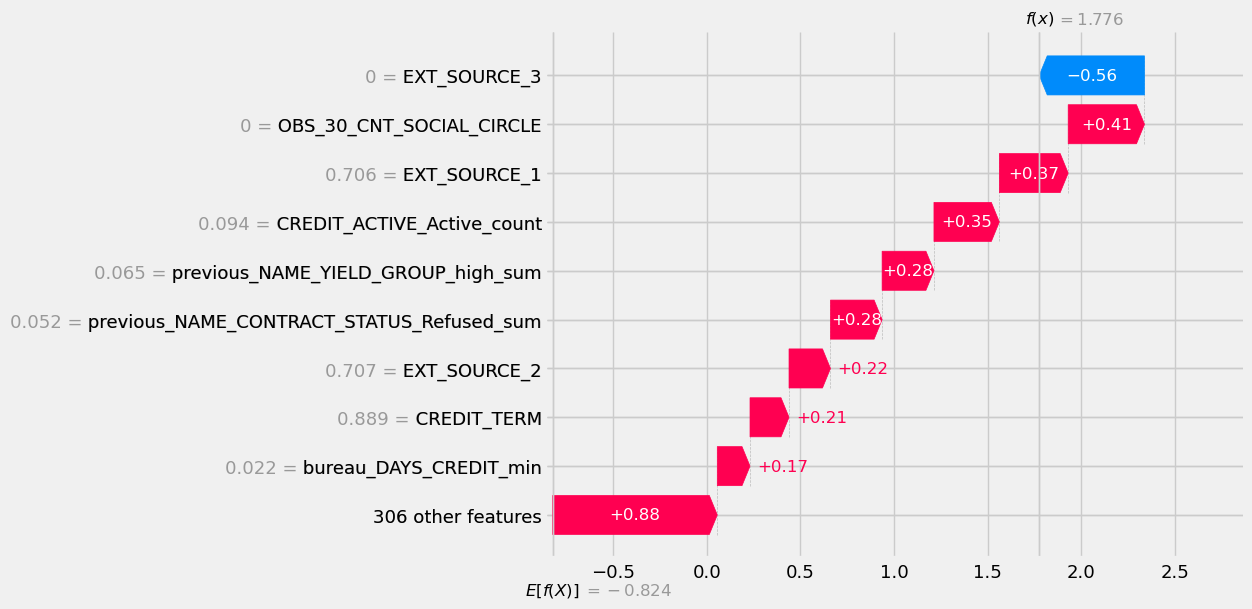

In [273]:
shap.waterfall_plot(individual_shap_values_0)

__Follow-up Notebooks__

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Automated Model Tuning](https://www.kaggle.com/willkoehrsen/automated-model-tuning)
* [Model Tuning Results](https://www.kaggle.com/willkoehrsen/model-tuning-results-random-vs-bayesian-opt/notebook)




### Follow-up Notebooks

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)

As always, I welcome feedback and constructive criticism. I write for Towards Data Science at https://medium.com/@williamkoehrsen/ and can be reached on Twitter at https://twitter.com/koehrsen_will

Will



+ faire woe ?
+ shapley
+ poids de chaque variable
+ récupération de la p value de chaque variable 
+ techniques de rééchantillonage
+ Faire courbe aucroc
+ Faire courbe Lift
+ faire taux de cible par décile